# SWB Regression Pipeline - Theta Power 
Created: 09/30/2024 \
Updated: 10/01/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



10012024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'theta' 
theta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
theta_reg_df = theta_df.copy()
theta_reg_df = theta_reg_df[theta_reg_df.roi.isin(keep_rois)]

# Test Single Electrode Regressions 

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'cpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit+rpe+cpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2722.89it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2703.05it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2676.11it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2687.97it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2706.86it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit', 'rpe', 'cpe']

In [14]:
results = single_elec_permutation_results(results_dict,theta_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.178532   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.027547   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.100227   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.074052   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.150687   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.134208   
1184  DA039_rpins2-rpins3   DA039   pins   22                    -0.062428   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.019109   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.119892   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.146735   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.121315                   0.057614   
1                                   0.097663                  -0.411165   
2                                   0.026397                  -0.230580   
3                                   0.033745                  -0.134145   
4                                   0.043390                  -0.115698   
...                                      ...                        ...   
1183                                0.009262                   0.491453   
1184                                0.180661                   0.542159   
1185                                0.031036                   0.193208   
1186                                0.124217                   0.220672   
1187                                0.140017                   0.383283   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                    -0.097763               0.108548               0.011917   
1                     0.556902              -0.264509              -0.045543   
2                     0.140344              -0.182327              -0.014402   
3                     0.378797              -0.382133               0.027778   
4                     0.219249              -0.184222               0.001610   
...                        ...                    ...                    ...   
1183                 -0.719121               0.603570              -0.074981   
1184                 -0.532408               0.342477               0.101231   
1185                 -0.378206               0.168503               0.099545   
1186                 -0.421068               0.364894              -0.036988   
1187                 -0.677003               0.371520               0.086370   

      ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_rpe  Z_Score_cpe  \
0     ...         0.201873       -0.256656     0.412616     0.160963   
1     ...        -1.233495        1.250340    -0.904788    -0.385318   
2     ...        -0.767864        0.335731    -0.685780    -0.117249   
3     ...        -0.380632        0.841007    -1.280967     0.280761   
4     ...        -0.349633        0.495417    -0.621791     0.031150   
...   ...              ...             ...          ...          ...   
1183  ...         1.460943       -1.370013     1.575399    -0.481823   
1184  ...         1.922345       -1.191134     1.085042     0.858626   
1185  ...         0.597780       -0.761067     0.460088     0.877110   
1186  ...         0.776779       -0.946273     1.163049    -0.371608   
1187  ...         1.306826       -1.453313     1.092220     0.763128   

      P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0              0.125272                      0.125275         0.840016   
1              0.336480                      0.336160         0.217391   
2              0.724365                      0.718342         0.442568   
3              0.706580                      0.7088

### Save results as pickle file

In [15]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_combomodel-Profit_rpe_cpe_regression_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# CPE Results

In [16]:
sig_data = results[results.P_Value_cpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
51    MS002_racas6-racas7   MS002  dmpfc   14                     0.073404   
85    MS003_laimm2-laimm3   MS003   ains    8                     0.391450   
86    MS003_laimm3-laimm4   MS003   ains    8                     0.362176   
102   MS003_racas4-racas5   MS003    acc    8                     0.088014   
106   MS003_racas8-racas9   MS003  dmpfc    8                     0.025111   
...                   ...     ...    ...  ...                          ...   
1093  MS050_rmcms1-rmcms2   MS050    acc    9                     0.075881   
1108        DA8_lam2-lam3     DA8    amy   13                    -0.119801   
1115        DA8_ltp4-ltp5     DA8   pins   13                    -0.047732   
1132      DA023_lam5-lam6   DA023    amy   14                     0.046817   
1181    DA039_rof10-rof11   DA039  dlpfc   22                    -0.080349   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
51                                  0.129527                  -0.316632   
85                                  0.073977                   0.957003   
86                                  0.144727                   1.471634   
102                                 0.009172                   0.532291   
106                                -0.096465                  -0.064908   
...                                      ...                        ...   
1093                                0.087813                   0.080496   
1108                                0.046405                  -0.025672   
1115                                0.141900                   0.233315   
1132                               -0.079106                  -0.014600   
1181                                0.123206                   0.064178   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
51                    0.372701              -0.437324               0.271046   
85                   -1.663802               1.147049               0.600410   
86                   -2.458795               1.621310               0.639944   
102                  -0.863875               0.372067               0.448497   
106                   0.023090              -0.322645               0.297495   
...                        ...                    ...                    ...   
1093                 -0.184246              -0.024109               0.277521   
1108                  0.058460              -0.115166               0.114668   
1115                 -0.171175               0.024491               0.240319   
1132                  0.088656              -0.190077               0.177085   
1181                  0.136696               0.091673              -0.298522   

      ...  Z_Score_TrialEV  Z_Score_Profit  Z_Score_rpe  Z_Score_cpe  \
51    ...        -0.922735        0.797369    -1.409179     2.299557   
85    ...         1.657755       -1.725317     1.643470     1.961987   
86    ...         2.475402       -2.474646     2.256694     2.182776   
102   ...         1.946971       -1.865110     1.113945     3.057774   
106   ...        -0.185705        0.002765    -0.860255     2.096247   
...   ...              ...             ...          ...          ...   
1093  ...         0.270493       -0.333400    -0.000580     2.010585   
1108  ...        -0.114049        0.207606    -0.783789     2.406965   
1115  ...         0.841266       -0.409700     0.107860     2.505084   
1132  ...        -0.084531        0.273808    -0.789534     2.129096   
1181  ...         0.206329        0.326540     0.277193    -2.826883   

      P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
51             0.183708                      0.175607         0.356145   
85             0.597308                      0.650343         0.097367   
86             0.301100                      0.344093         0.013309   
102            0.833281                      0.9025

In [17]:
sig_data.roi.value_counts()



roi
dmpfc    13
acc      11
dlpfc     9
hpc       9
amy       7
ofc       7
ains      6
vlpfc     5
pins      3
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['dmpfc', 'ains', 'acc', 'vlpfc', 'amy', 'pins', 'dlpfc', 'ofc',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [19]:
# add mask col for sig cpe elecs 
results['cpe_sig']   = results['P_Value_cpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.178532   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.027547   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.100227   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.074052   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.150687   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.121315                   0.057614   
1                                0.097663                  -0.411165   
2                                0.026397                  -0.230580   
3                                0.033745                  -0.134145   
4                                0.043390                  -0.115698   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                 -0.097763               0.108548               0.011917   
1                  0.556902              -0.264509              -0.045543   
2                  0.140344              -0.182327              -0.014402   
3                  0.378797              -0.382133               0.027778   
4                  0.219249              -0.184222               0.001610   

   ...  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
0  ...     0.412616     0.160963           0.125272   
1  ...    -0.904788    -0.385318           0.336480   
2  ...    -0.685780    -0.117249           0.724365   
3  ...    -1.280967     0.280761           0.706580   
4  ...    -0.621791     0.031150           0.622994   

   P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  P_Value_rpe  \
0                      0.125275         0.840016        0.797444     0.679888   
1                      0.336160         0.217391        0.211175     0.365578   
2                      0.718342         0.442568        0.737074     0.492852   
3                      0.708887         0.703476        0.400344     0.200205   
4                      0.623199         0.726614        0.620306     0.534080   

   P_Value_cpe  cpe_sig  bdi_split  
0     0.872123        0          0  
1     0.700002        0          0  
2     0.906663        0          0  
3     0.778894        0          0  
4     0.975150        0          0  

[5 rows x 36 columns]

In [20]:
cpe_var = 'Z_Score_cpe'

In [21]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [22]:
results.groupby('roi').agg('mean',numeric_only=True)[cpe_var][bar_order]



roi
dlpfc    0.150670
vlpfc    0.140324
dmpfc    0.137634
ofc      0.242123
ains     0.294241
pins     0.097335
acc      0.114277
amy     -0.064194
hpc     -0.124635
Name: Z_Score_cpe, dtype: float64

In [23]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[cpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.cpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].cpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [24]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     11  0.056995              1    1.557894    0.120905   
1  dmpfc      225     13  0.057778              0    2.009066    0.045730   
2    amy      113      7  0.061947              1   -0.677477    0.499501   
3   ains       71      6  0.084507              0    2.190596    0.031813   
4  vlpfc       82      5  0.060976              0    1.186997    0.238698   
5    hpc      135      9  0.066667              0   -1.349704    0.179387   
6    ofc      202      7  0.034653              1    3.754365    0.000227   
7   pins       60      3  0.050000              0    0.869401    0.388151   
8  dlpfc      107      9  0.084112              2    1.363754    0.175534   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.032288            1.0    0.056995      0.3721  
1      0.034511            1.0    0.057778      0.3367  
2      0.029432            1.0    0.061947      0.3362  
3      0.037443            1.0    0.084507      0.1440  
4      0.024331            1.0    0.060976      0.3912  
5      0.035217            1.0    0.066667      0.2349  
6      0.016375            1.0    0.034653      0.8823  
7      0.013765            1.0    0.050000      0.5826  
8      0.044581            1.0    0.084112      0.0880

In [25]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

Empty DataFrame
Columns: [roi, n_total, n_sig, prop_sig, n_sig_highbdi, ttest_stat, ttest_pval, binom_ci_low, binom_ci_high, binom_prop, binom_pval]
Index: []

In [26]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-cpe_coeff_barplot_{epoch_len}.pdf'


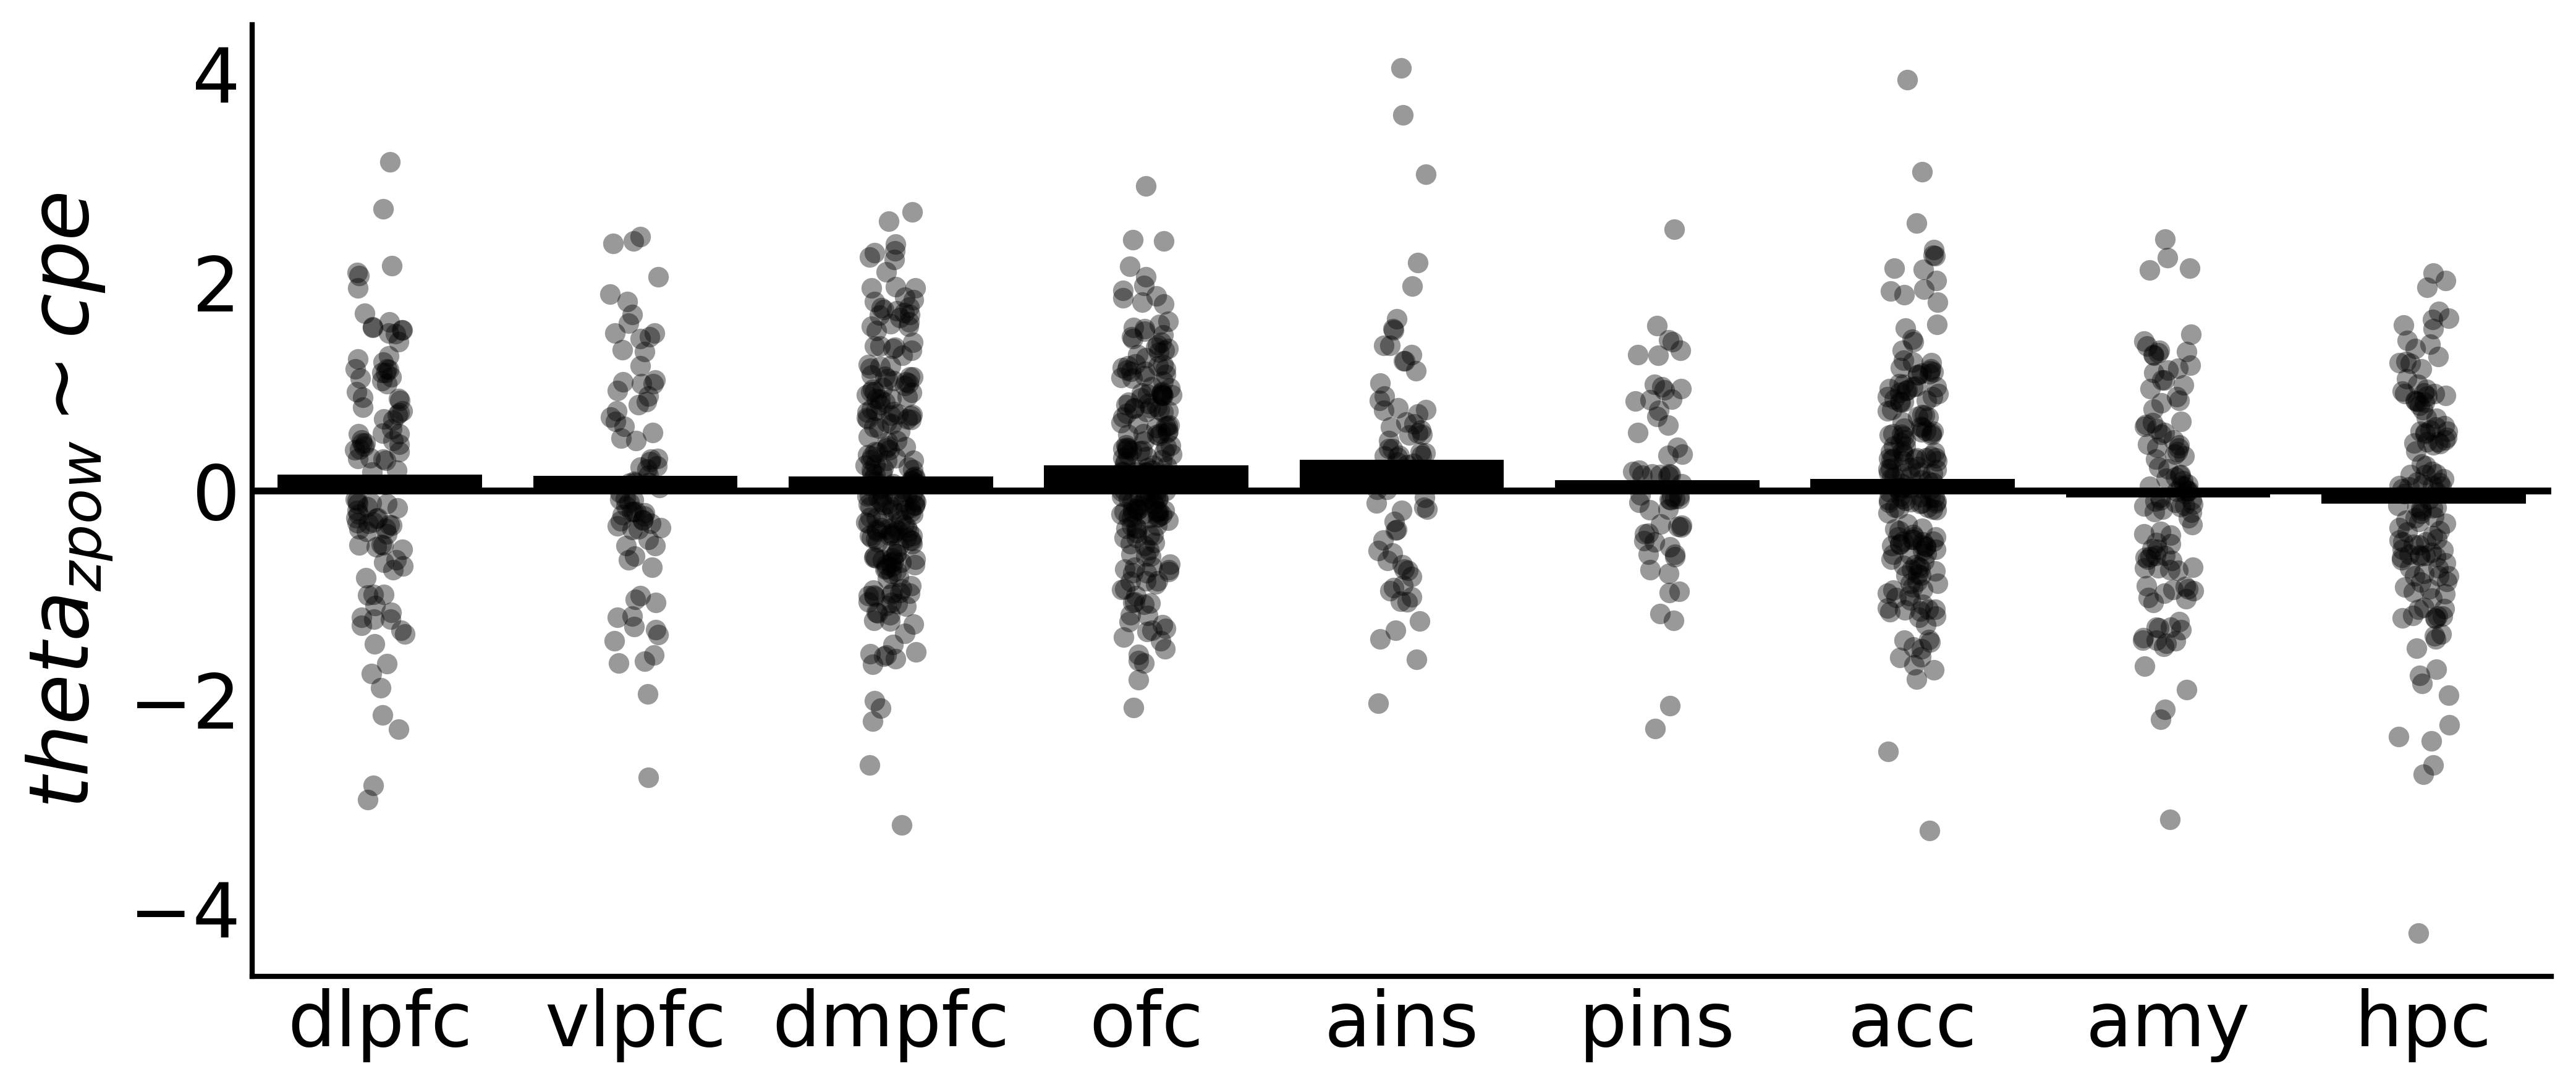

In [27]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim cpe$'


plot_roi_model_results(results,'roi',cpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

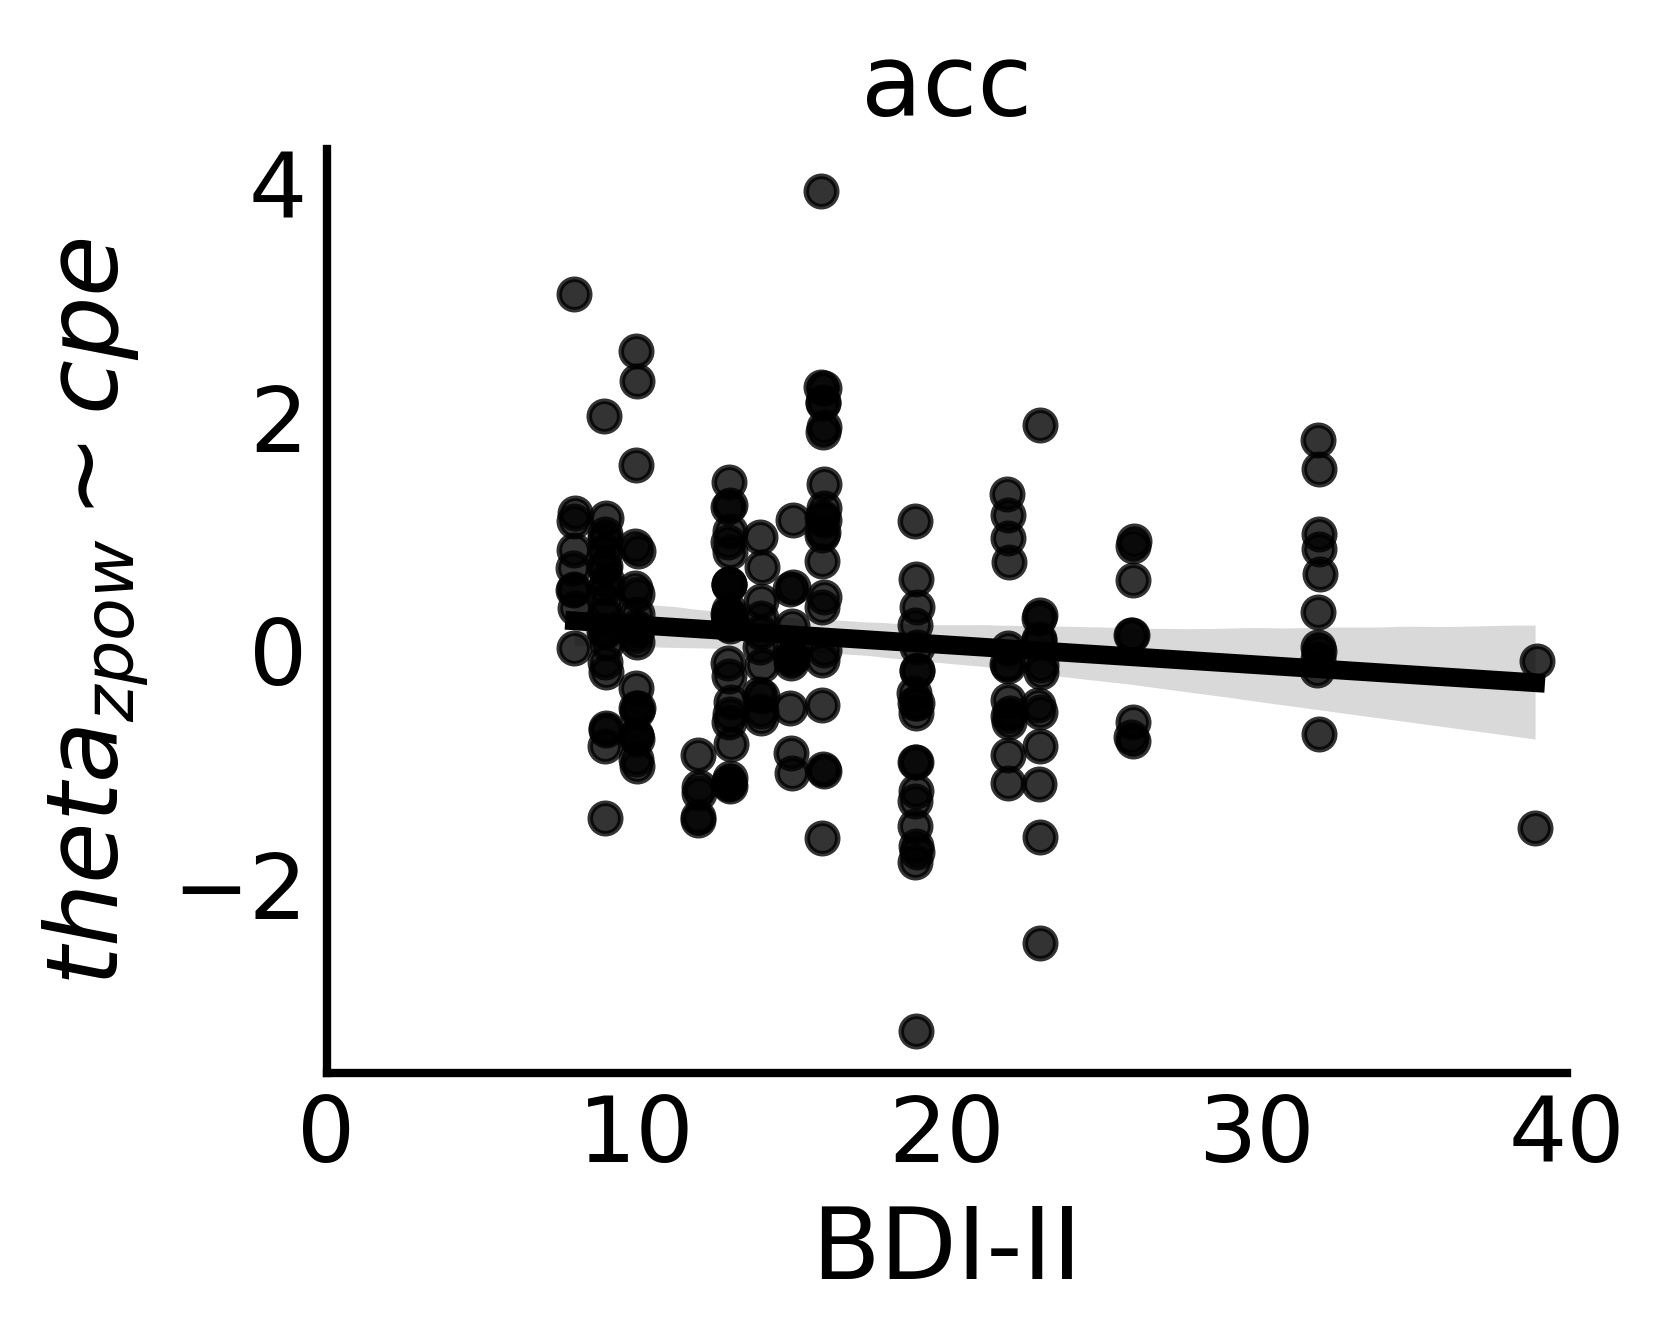

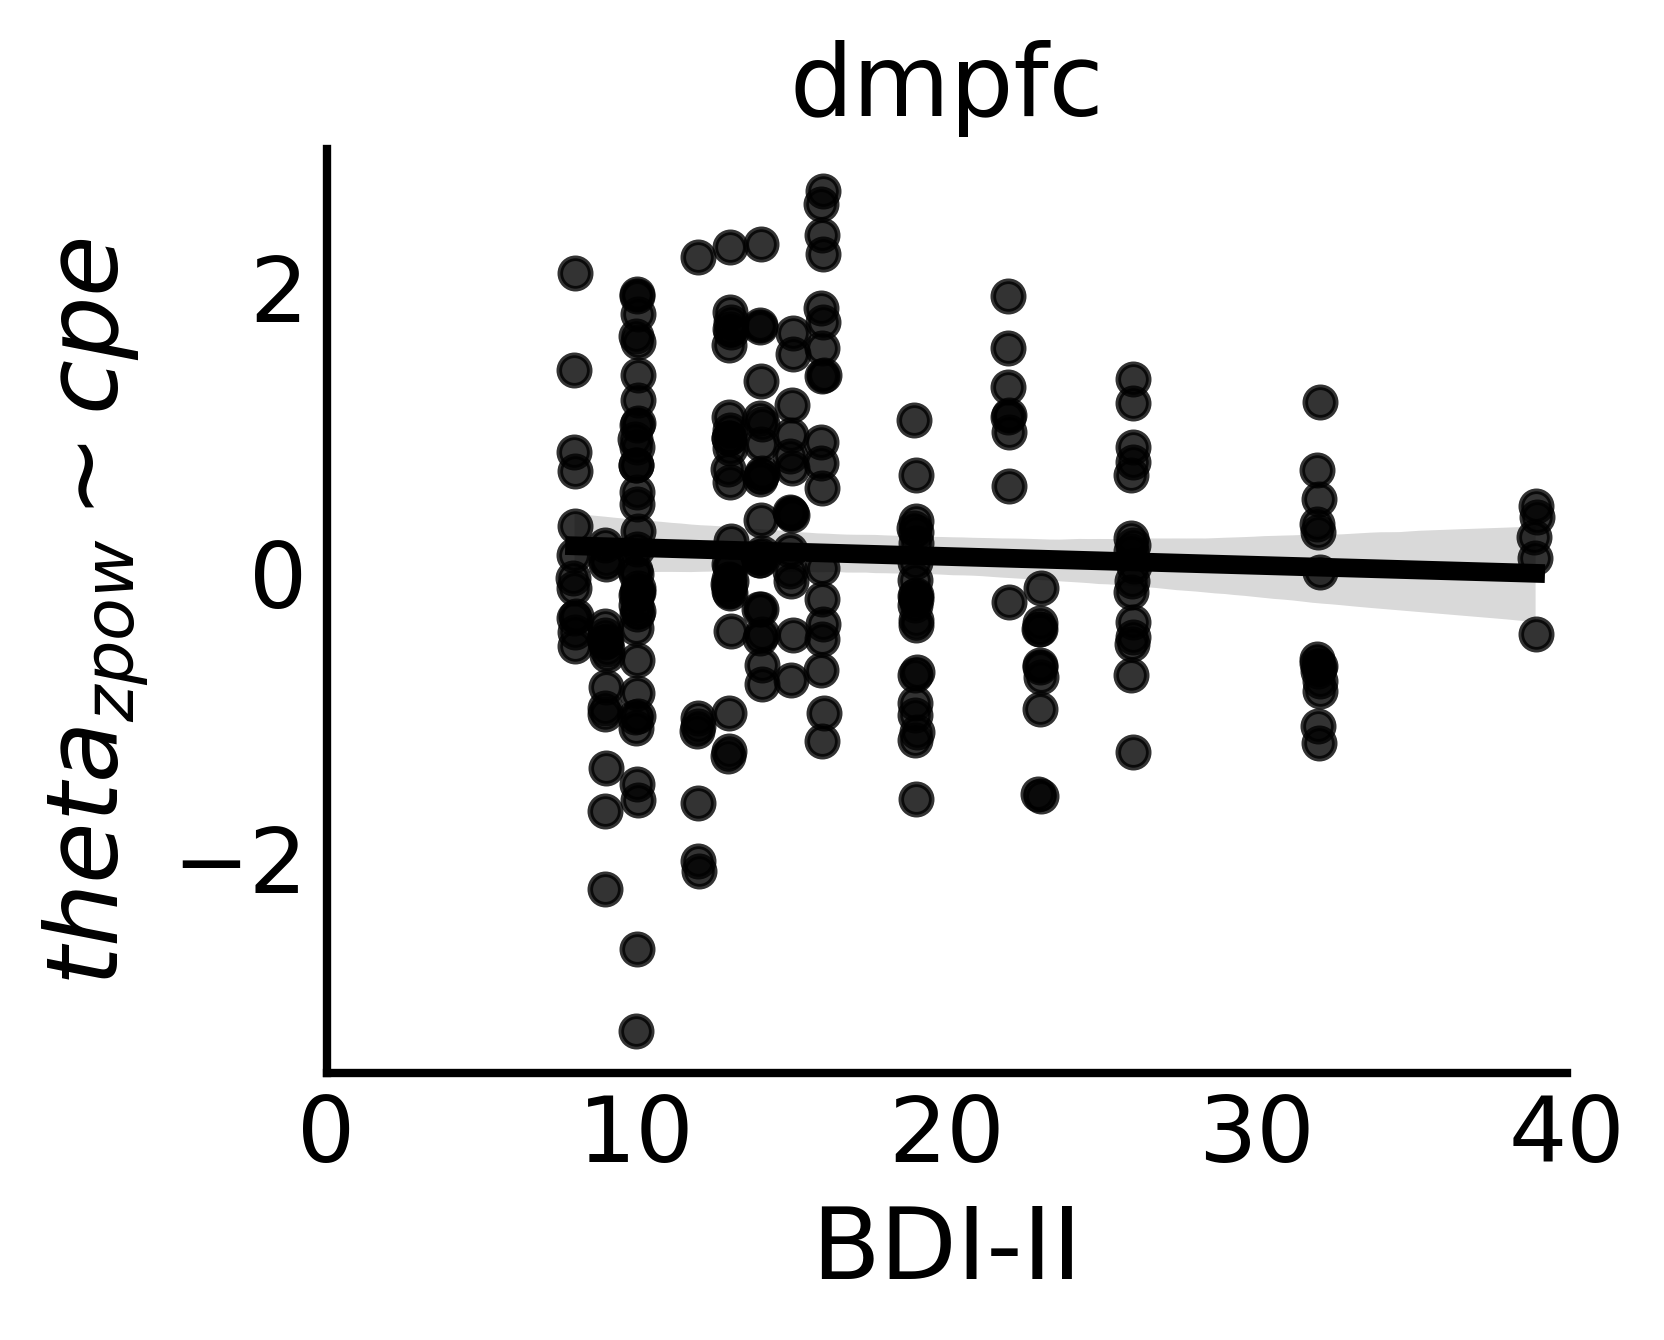

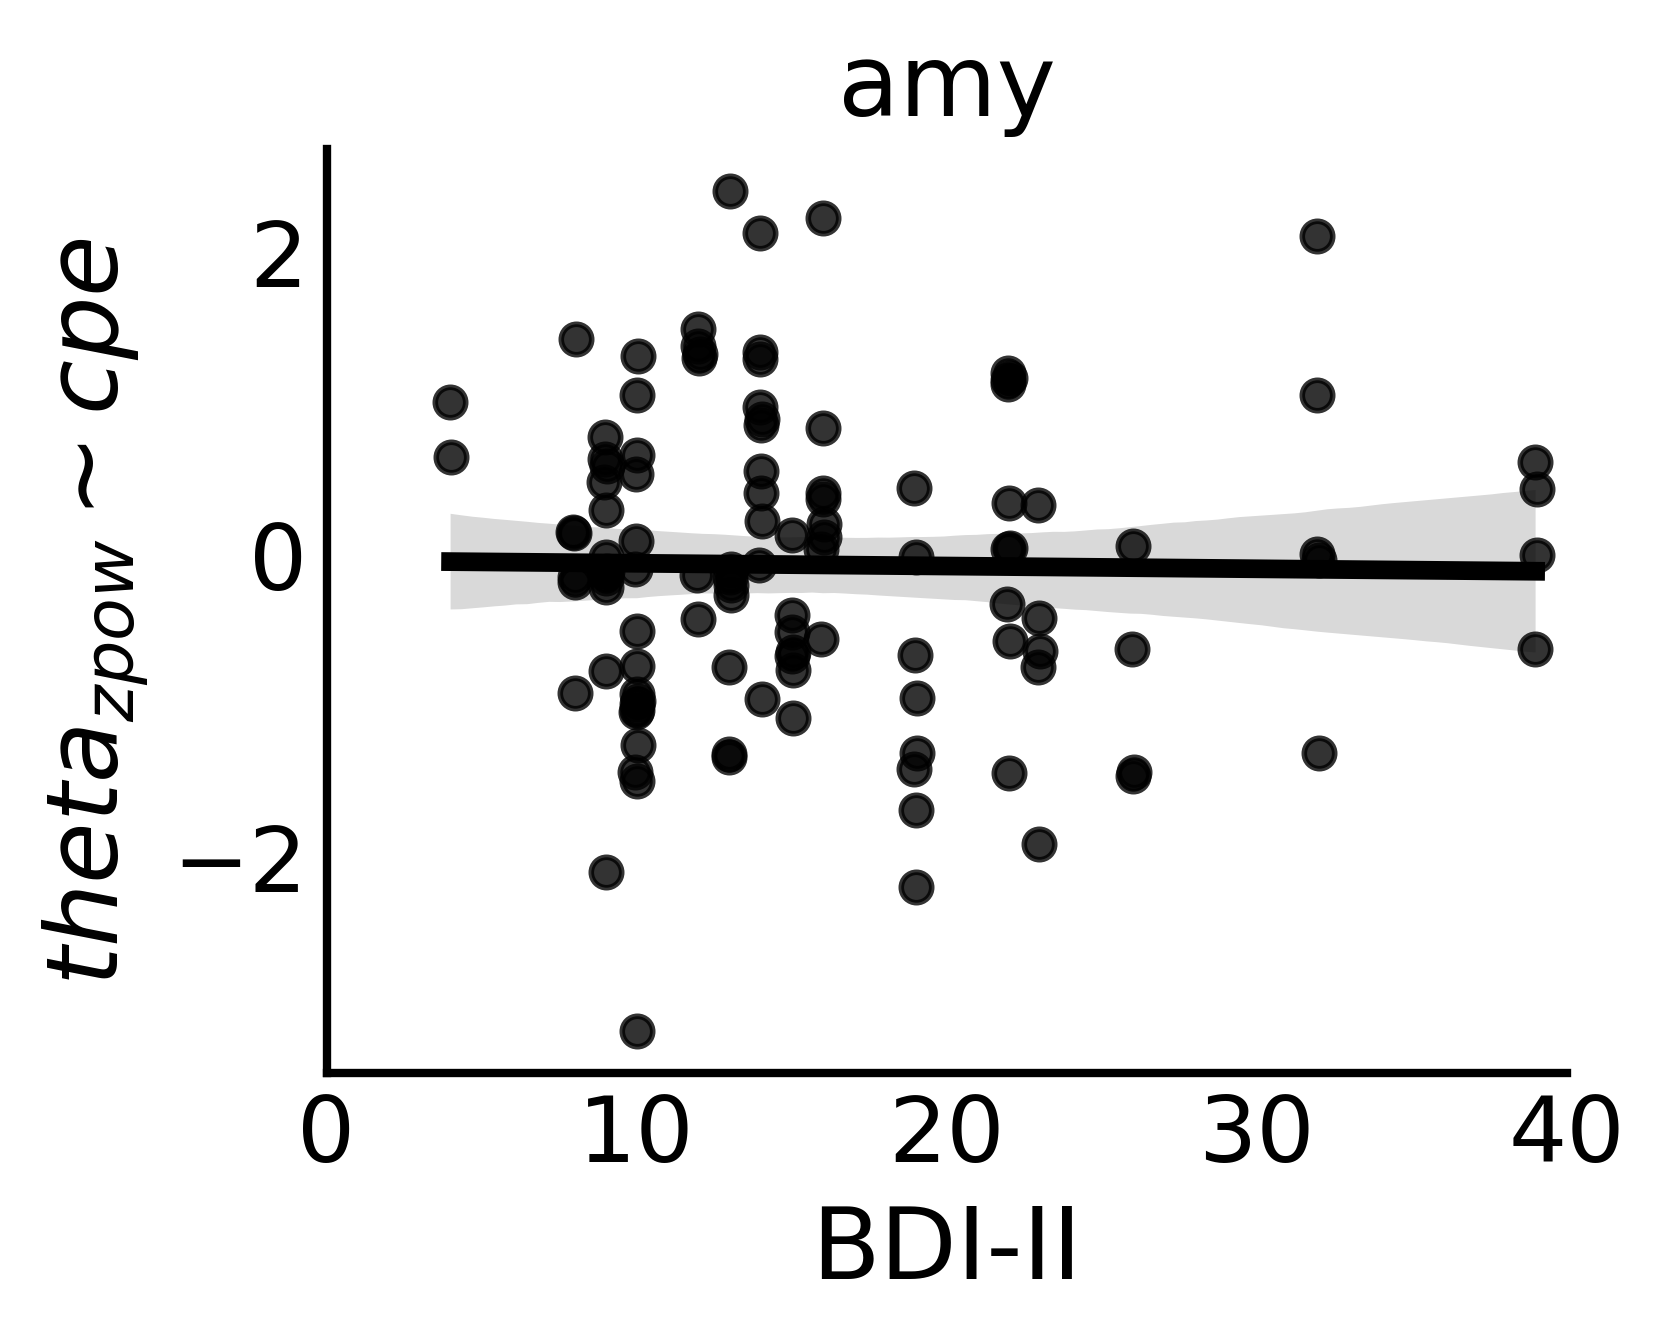

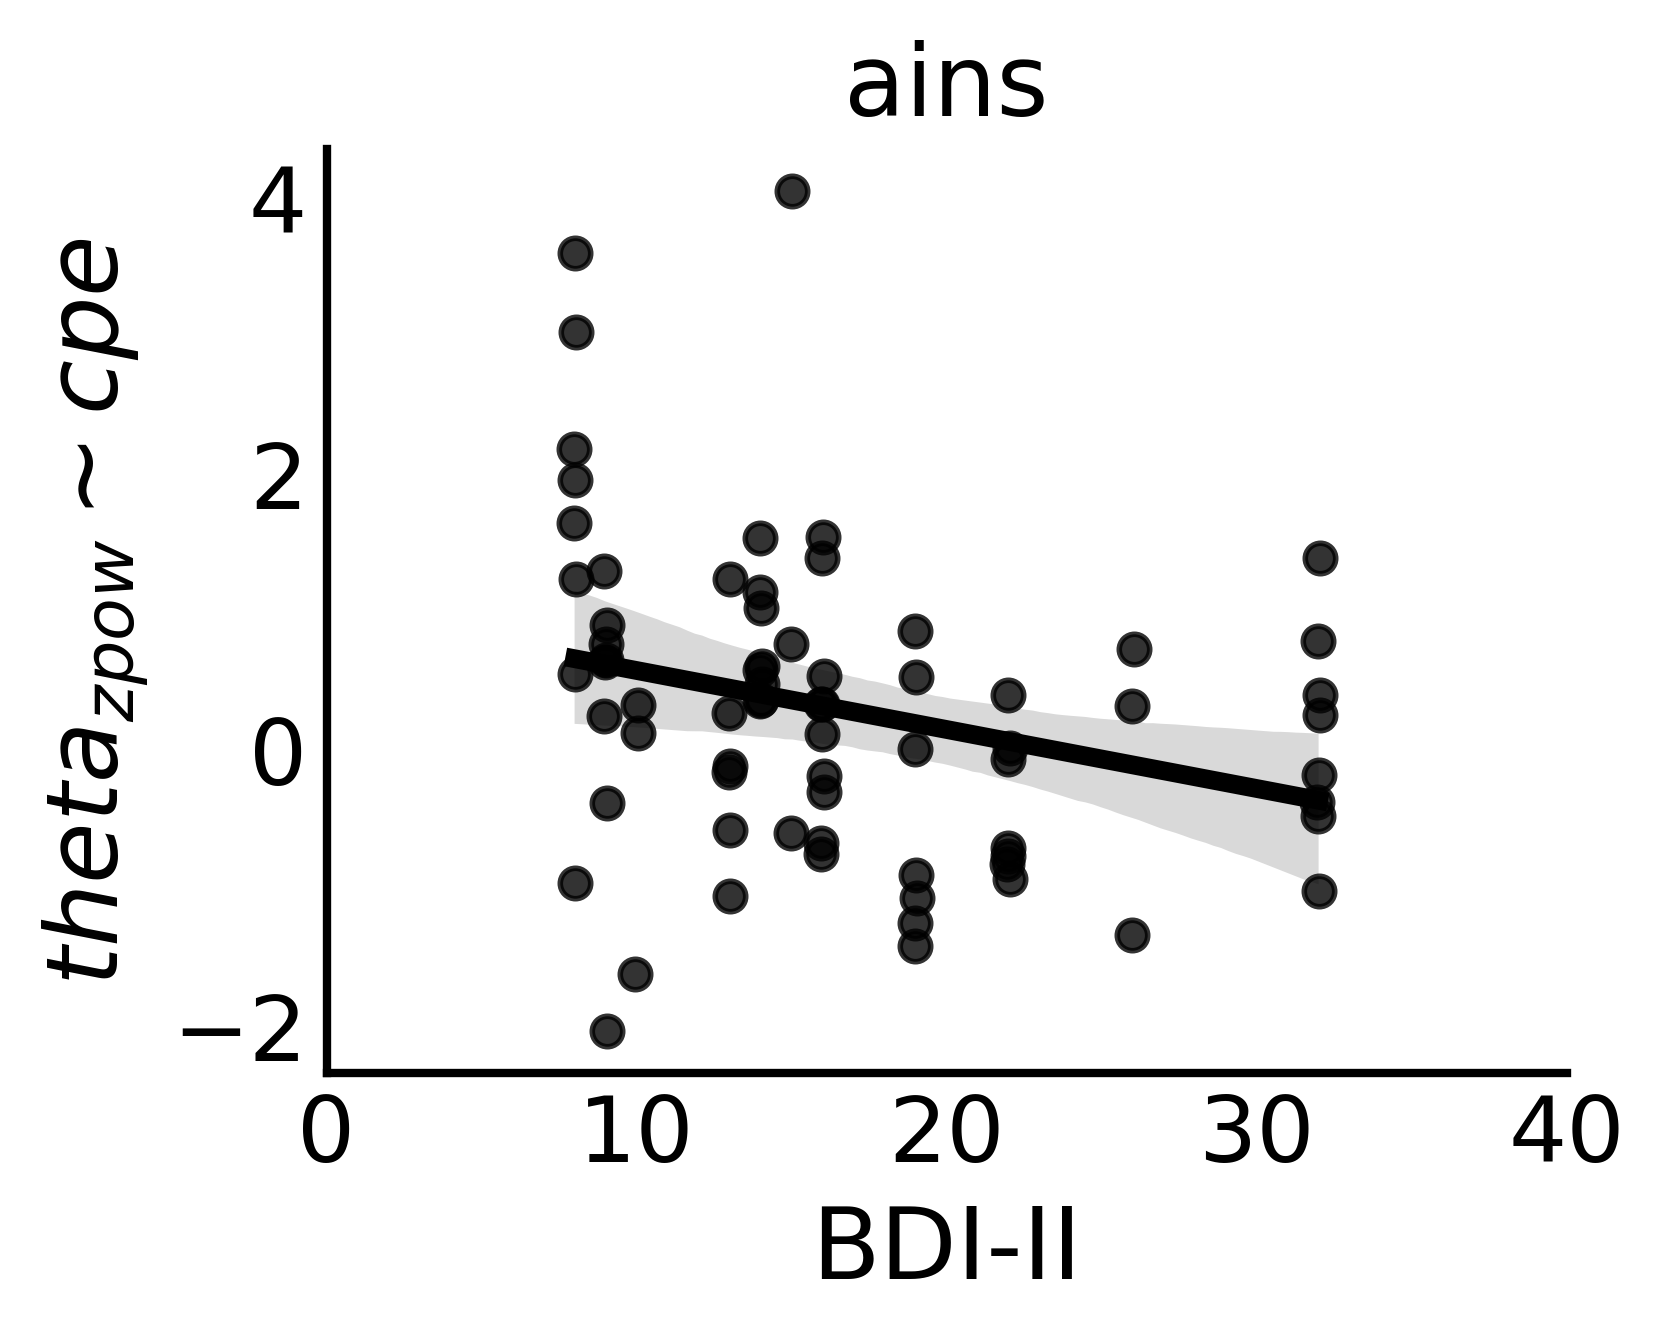

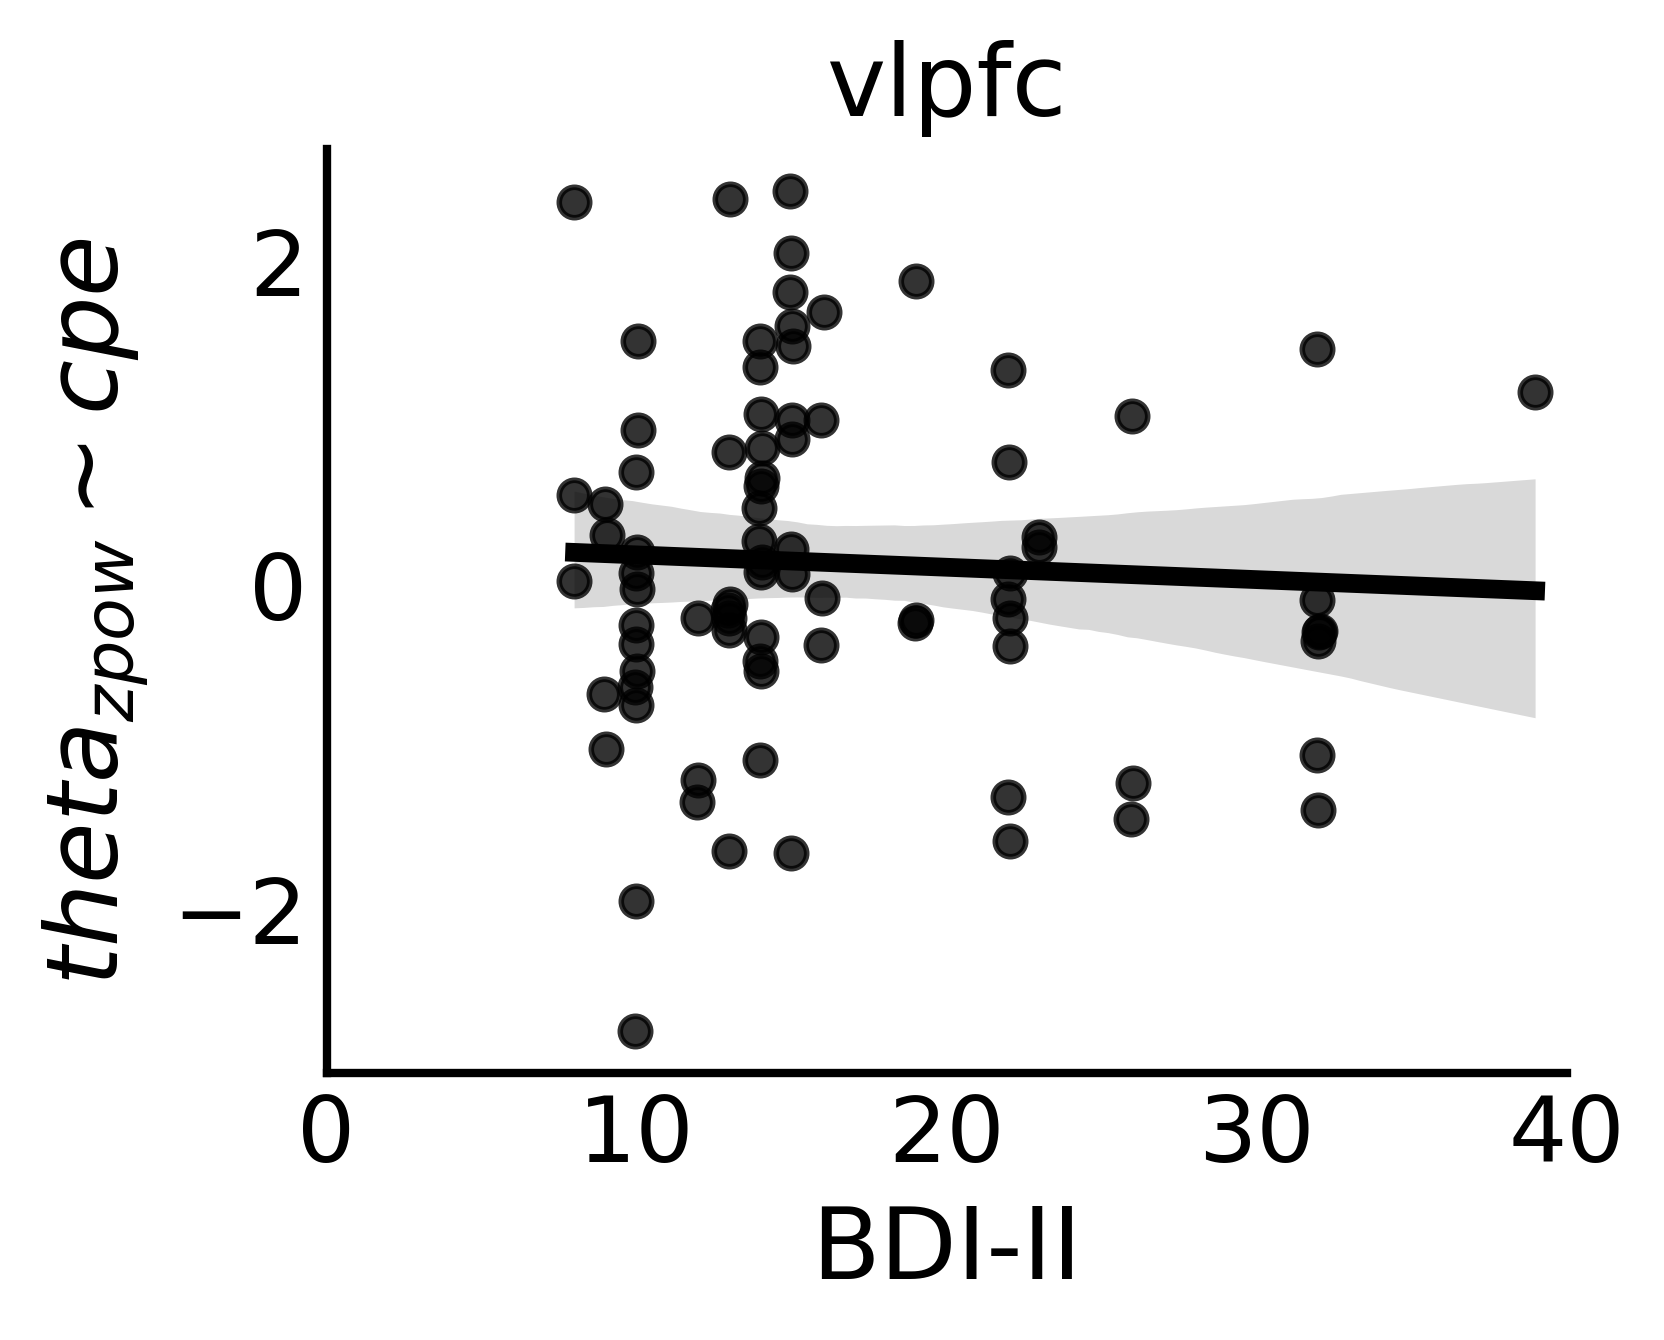

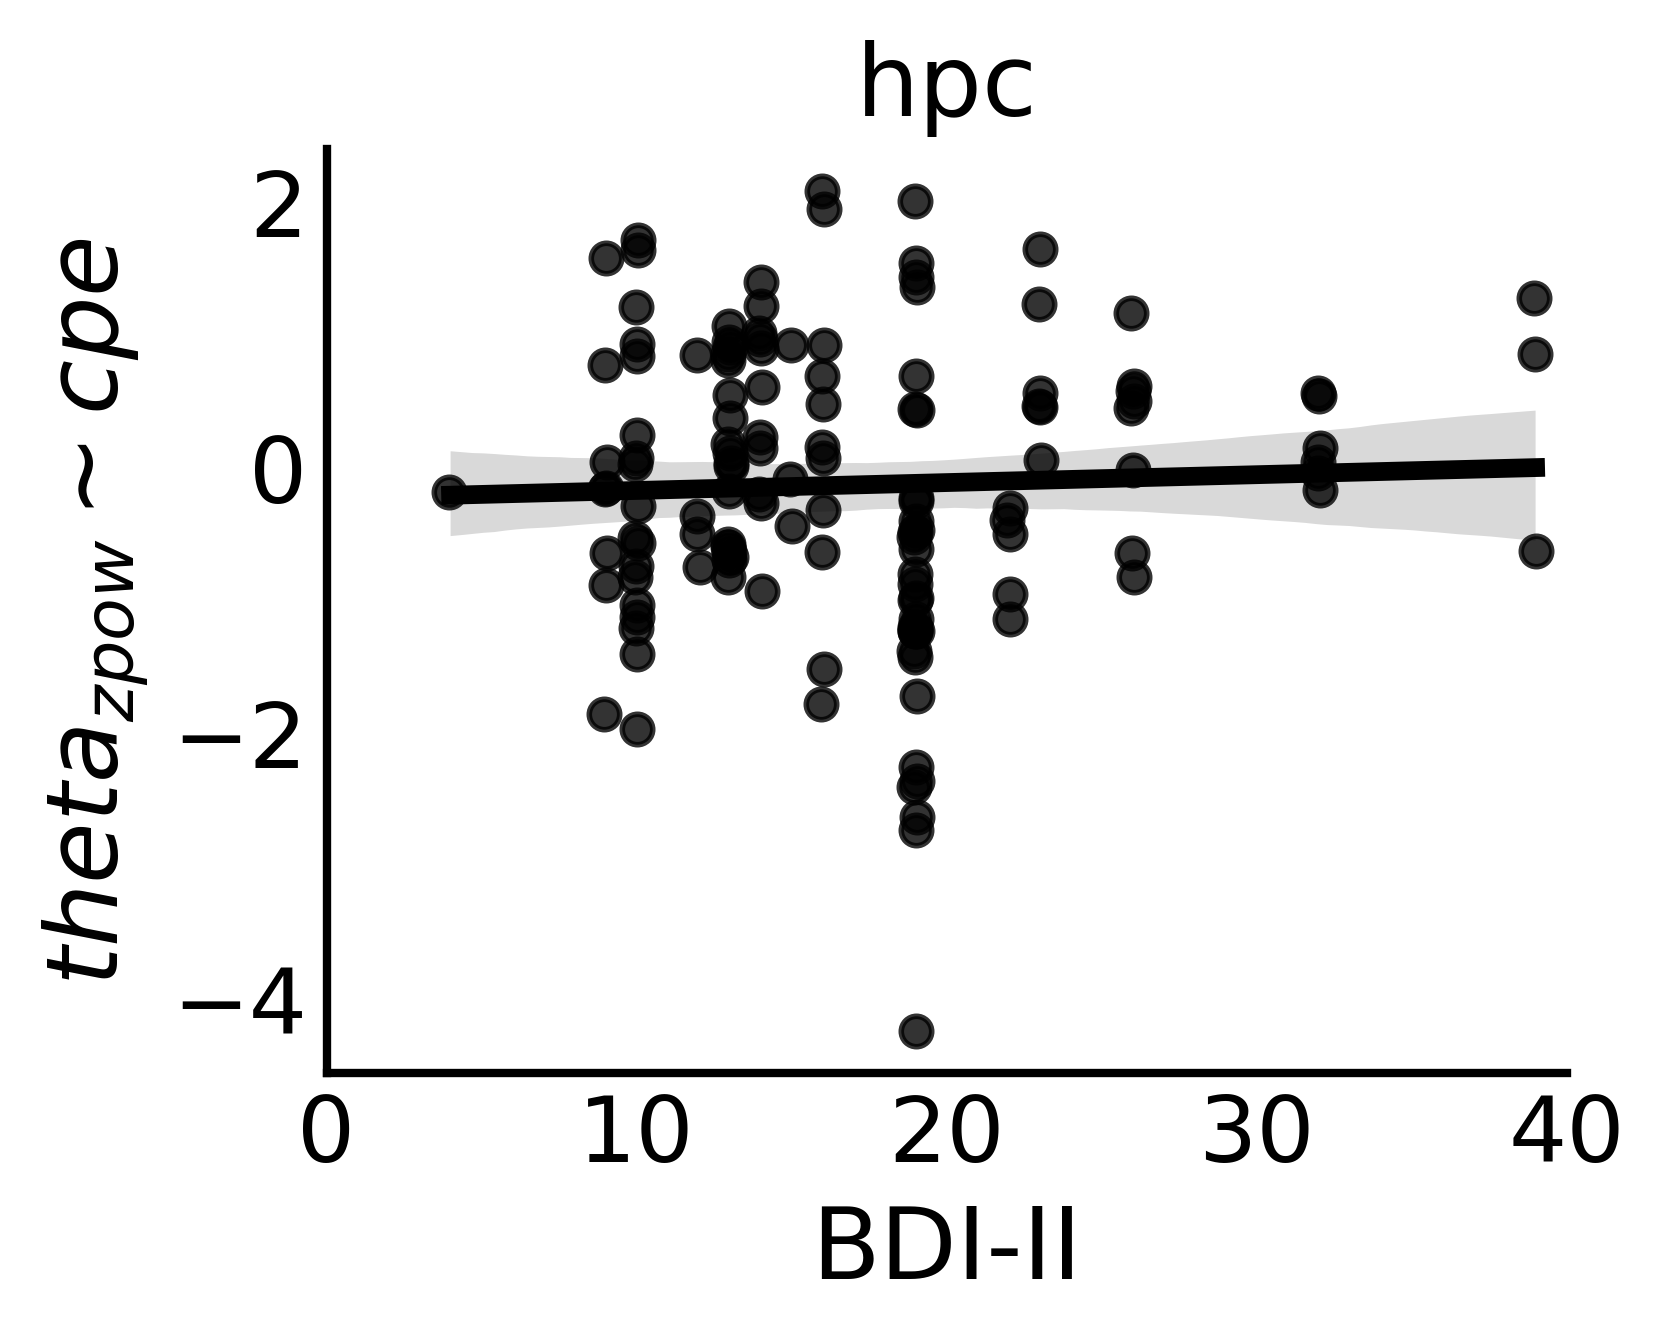

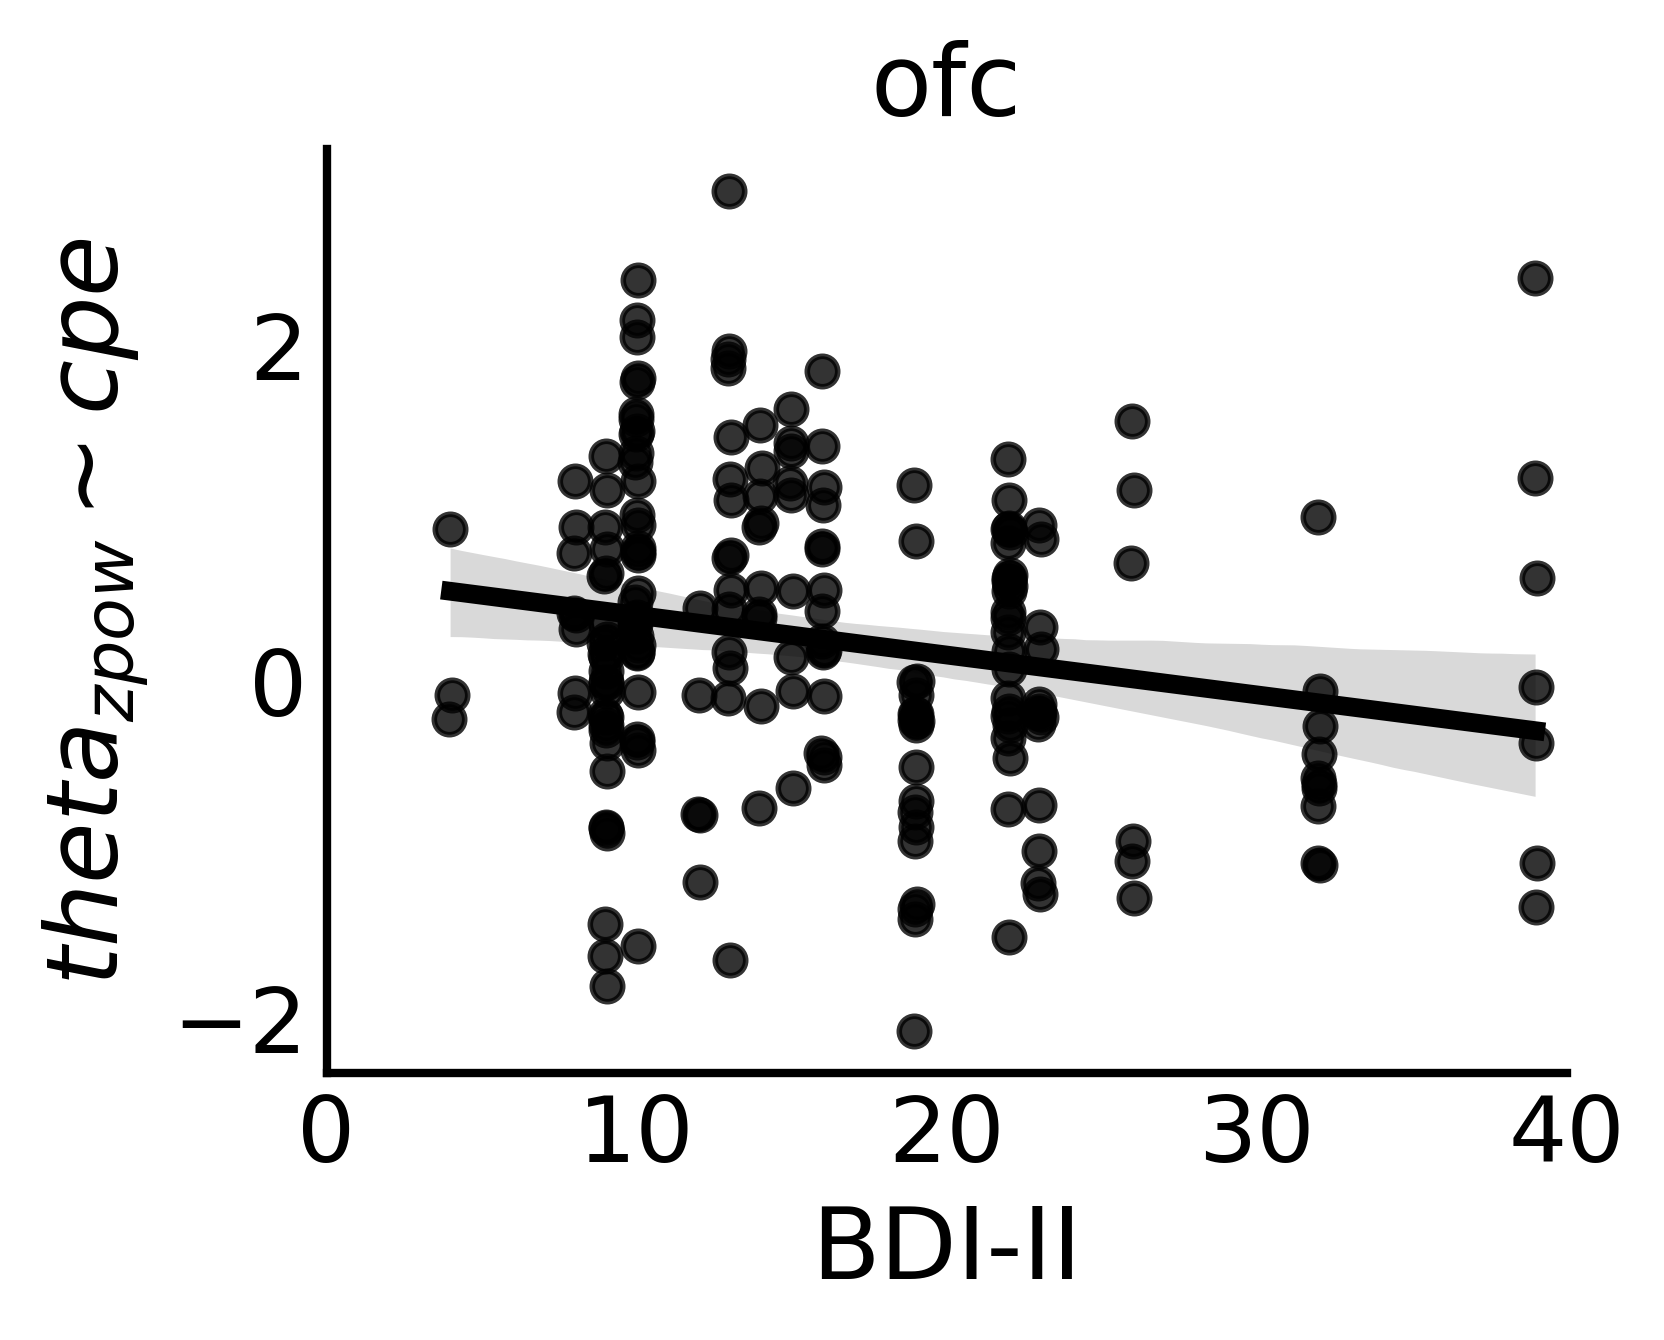

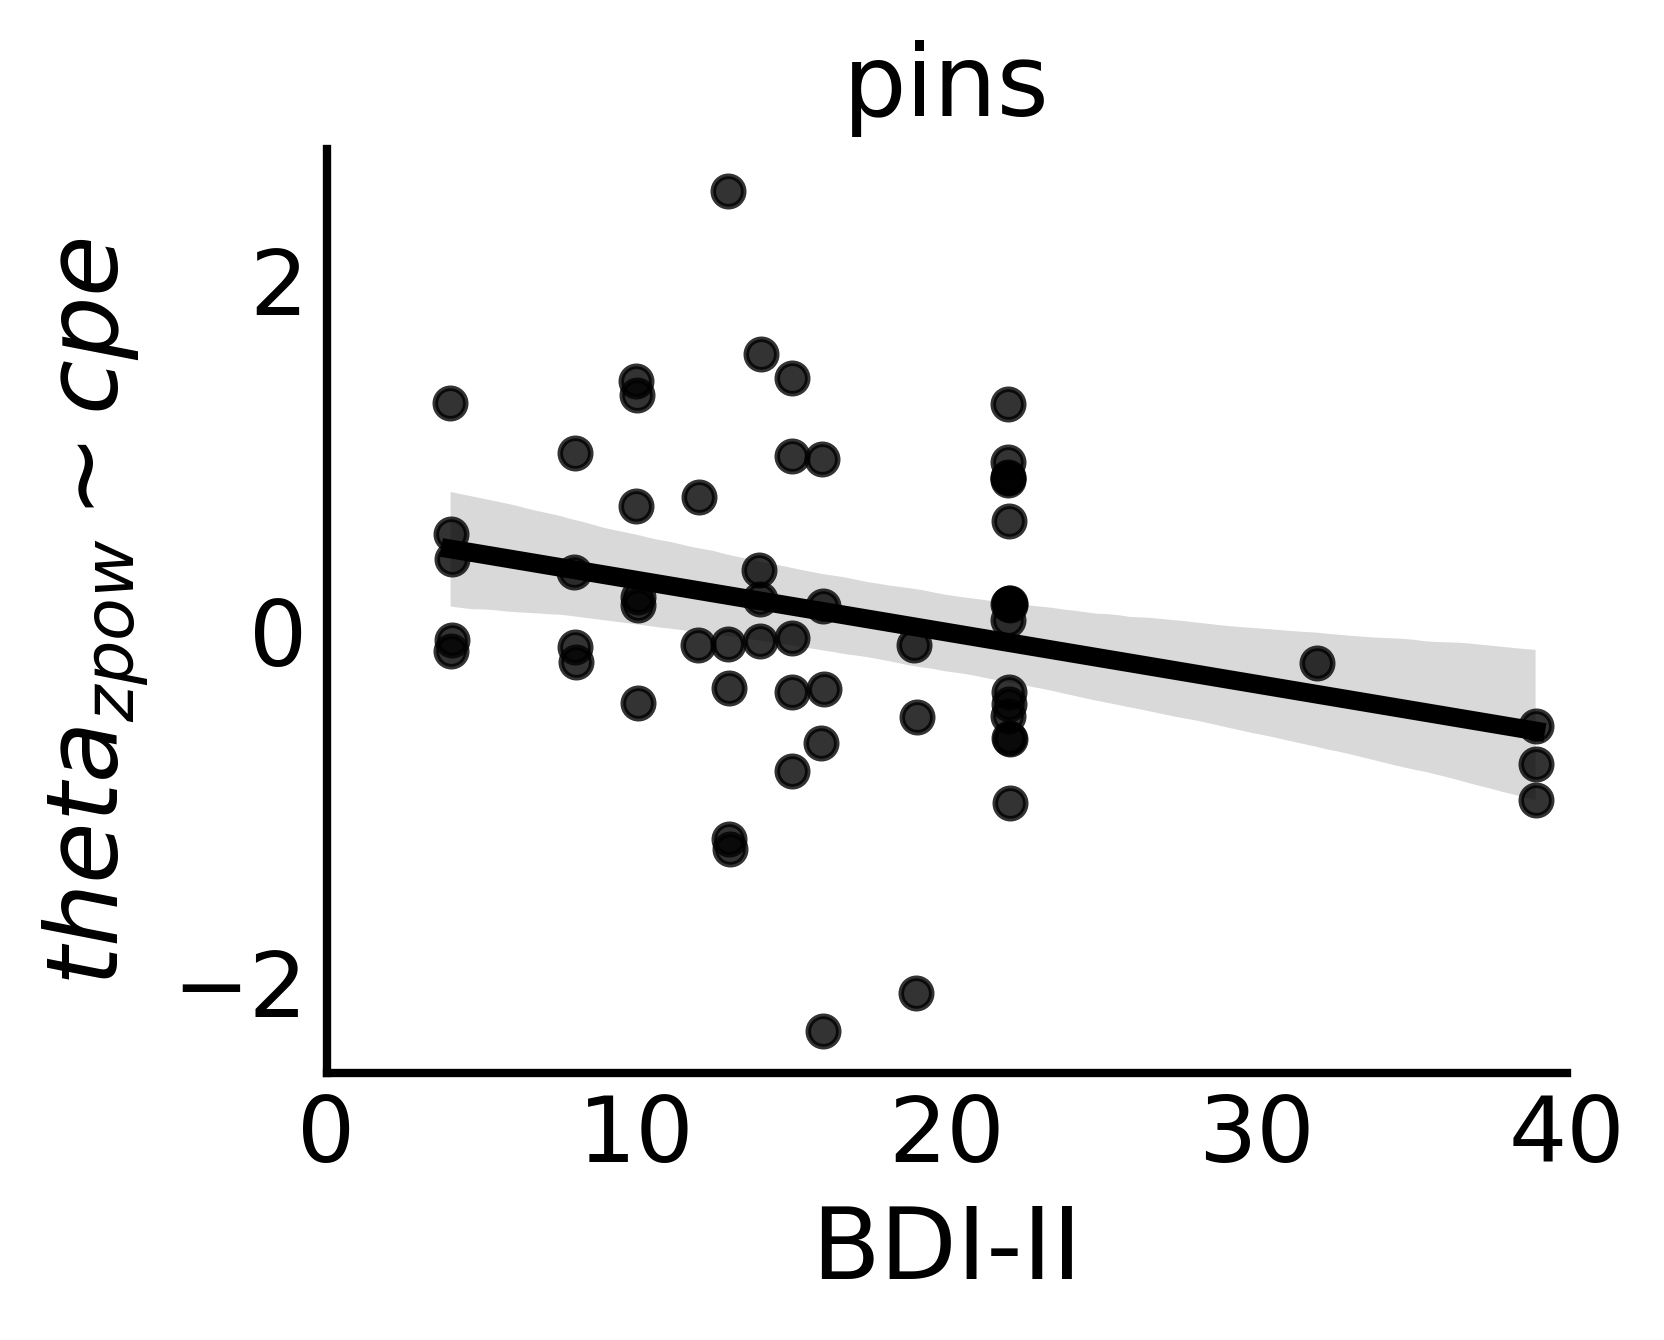

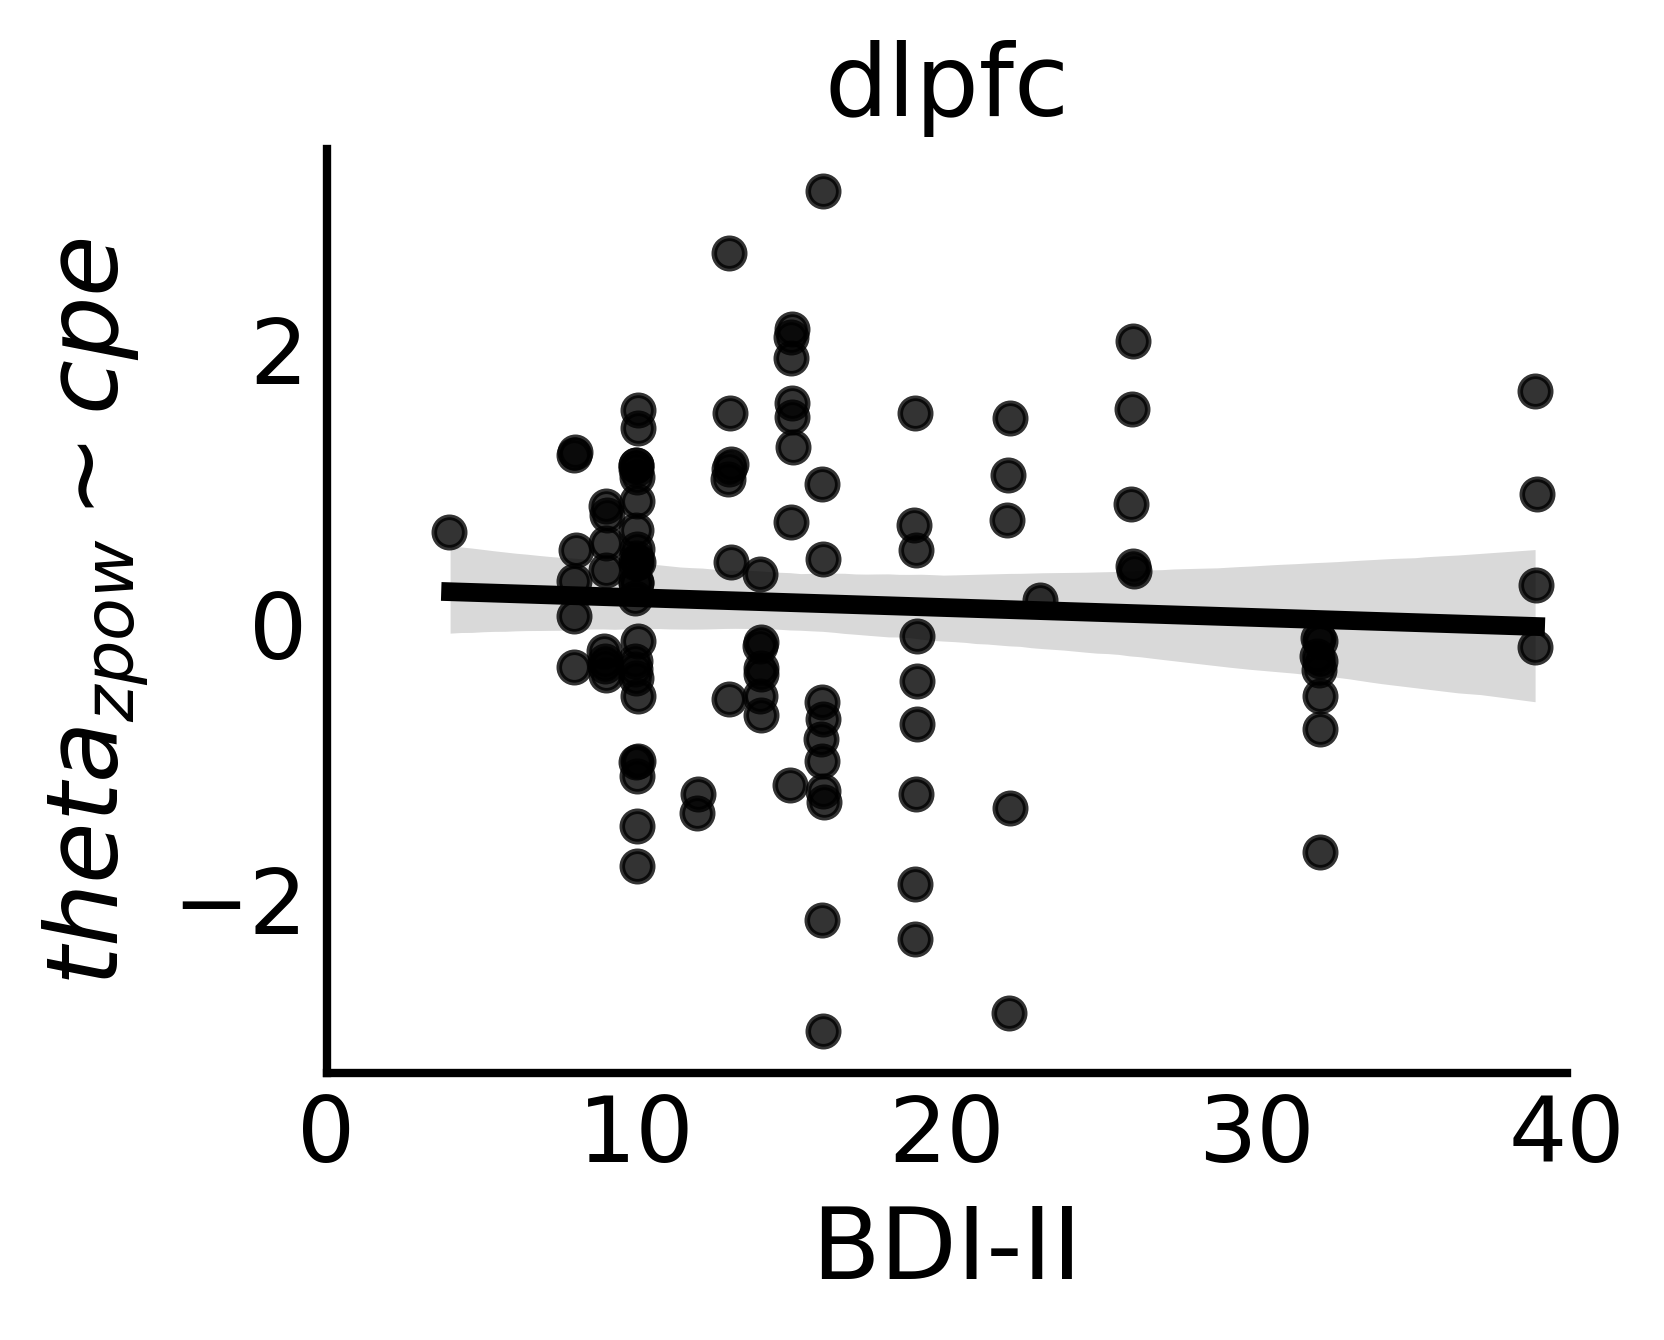

In [28]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-bdi_cpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_cpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim cpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [29]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_cpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        10:37:26                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8573      0.438     36.210     

In [43]:
# del cpe_var

# RPE Results

In [30]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
29    MS002_lloif6-lloif7   MS002  vlpfc   14                     0.080259   
86    MS003_laimm3-laimm4   MS003   ains    8                     0.362176   
136   MS009_lacas4-lacas5   MS009    acc   16                     0.172137   
157   MS009_lmcms1-lmcms2   MS009    acc   16                    -0.043490   
185   MS011_lmcps6-lmcps7   MS011  dmpfc   13                     0.006448   
...                   ...     ...    ...  ...                          ...   
1045  MS050_lacas3-lacas4   MS050    acc    9                     0.164407   
1081  MS050_ragit2-ragit3   MS050    amy    9                     0.067957   
1128      DA023_lam1-lam2   DA023    amy   14                     0.068252   
1133      DA023_lmc8-lmc9   DA023  dmpfc   14                    -0.017029   
1171      DA039_rfp6-rfp7   DA039    ofc   22                    -0.194069   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
29                                 -0.052651                  -0.594205   
86                                  0.144727                   1.471634   
136                                -0.063367                   0.855816   
157                                 0.078016                  -0.598570   
185                                -0.075917                   0.718695   
...                                      ...                        ...   
1045                                0.039324                   1.079961   
1081                               -0.059779                   0.381177   
1128                               -0.067178                   0.577212   
1133                                0.005680                   0.093130   
1171                                0.307108                   0.703045   

      Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
29                    0.908650              -0.671441              -0.029327   
86                   -2.458795               1.621310               0.639944   
136                  -1.115485               0.984997               0.132167   
157                   0.908604              -0.555177              -0.146327   
185                  -1.034453               0.722248               0.095970   
...                        ...                    ...                    ...   
1045                 -1.816006               1.224777               0.053726   
1081                 -0.883763               0.768738               0.031691   
1128                 -0.804230               0.637334               0.085488   
1133                 -0.151019               0.124541               0.023597   
1171                 -1.215408               0.811363               0.132922   

      ...  Z_Score_rpe  Z_Score_cpe  P_Value_Intercept  \
29    ...    -2.587556    -0.317302           0.528152   
86    ...     2.256694     2.182776           0.301100   
136   ...     2.933088     1.018196           0.471095   
157   ...    -2.082867    -1.600266           0.266710   
185   ...     2.365271     0.875825           0.372723   
...   ...          ...          ...                ...   
1045  ...     2.011164     0.309416           0.701679   
1081  ...     2.009301     0.299502           0.464089   
1128  ...     2.341032     0.898221           0.421735   
1133  ...     2.134475     1.086104           0.723953   
1171  ...     2.142724     1.083664           0.000679   

      P_Value_GambleChoice[T.safe]  P_Value_TrialEV  P_Value_Profit  \
29                        0.526692         0.039749        0.018826   
86                        0.344093         0.013309        0.013337   
136                       0.480549         0.015120        0.020147   
157                       0.243337         0.029567        0.017334   
185                       0.365687         0.015556        0.016557   
...                            ...              ...             ...   
1045              

In [31]:
sig_data.roi.value_counts()



roi
dmpfc    14
acc      11
hpc       9
ofc       7
ains      6
amy       6
pins      4
vlpfc     3
dlpfc     1
Name: count, dtype: int64

In [32]:
sig_data.roi.unique()



array(['vlpfc', 'ains', 'acc', 'dmpfc', 'hpc', 'ofc', 'amy', 'pins',
       'dlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [33]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.178532   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.027547   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.100227   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.074052   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.150687   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.121315                   0.057614   
1                                0.097663                  -0.411165   
2                                0.026397                  -0.230580   
3                                0.033745                  -0.134145   
4                                0.043390                  -0.115698   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                 -0.097763               0.108548               0.011917   
1                  0.556902              -0.264509              -0.045543   
2                  0.140344              -0.182327              -0.014402   
3                  0.378797              -0.382133               0.027778   
4                  0.219249              -0.184222               0.001610   

   ...  Z_Score_cpe  P_Value_Intercept  P_Value_GambleChoice[T.safe]  \
0  ...     0.160963           0.125272                      0.125275   
1  ...    -0.385318           0.336480                      0.336160   
2  ...    -0.117249           0.724365                      0.718342   
3  ...     0.280761           0.706580                      0.708887   
4  ...     0.031150           0.622994                      0.623199   

   P_Value_TrialEV  P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  \
0         0.840016        0.797444     0.679888     0.872123        0   
1         0.217391        0.211175     0.365578     0.700002        0   
2         0.442568        0.737074     0.492852     0.906663        0   
3         0.703476        0.400344     0.200205     0.778894        0   
4         0.726614        0.620306     0.534080     0.975150        0   

   bdi_split  rpe_sig  
0          0        0  
1          0        0  
2          0        0  
3          0        0  
4          0        0  

[5 rows x 37 columns]

In [34]:
rpe_var = 'Z_Score_rpe'

In [35]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [36]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc    0.262554
vlpfc    0.187081
dmpfc    0.168392
ofc      0.195082
ains     0.492308
pins    -0.206088
acc      0.138154
amy     -0.004442
hpc     -0.018334
Name: Z_Score_rpe, dtype: float64

In [37]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [38]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     11  0.056995              3    2.016814    0.045108   
1  dmpfc      225     14  0.062222              3    2.419591    0.016336   
2    amy      113      6  0.053097              1   -0.050423    0.959875   
3   ains       71      6  0.084507              2    3.943710    0.000188   
4  vlpfc       82      3  0.036585              1    1.649992    0.102817   
5    hpc      135      9  0.066667              1   -0.204504    0.838270   
6    ofc      202      7  0.034653              3    2.995903    0.003081   
7   pins       60      4  0.066667              2   -1.522899    0.133126   
8  dlpfc      107      1  0.009346              0    3.085360    0.002594   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.032288            1.0    0.056995      0.3721  
1      0.038006            1.0    0.062222      0.2380  
2      0.023374            1.0    0.053097      0.4994  
3      0.037443            1.0    0.084507      0.1440  
4      0.010045            1.0    0.036585      0.7836  
5      0.035217            1.0    0.066667      0.2349  
6      0.016375            1.0    0.034653      0.8823  
7      0.023091            1.0    0.066667      0.3527  
8      0.000479            1.0    0.009346      0.9959

In [39]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

Empty DataFrame
Columns: [roi, n_total, n_sig, prop_sig, n_sig_highbdi, ttest_stat, ttest_pval, binom_ci_low, binom_ci_high, binom_prop, binom_pval]
Index: []

# Plot Results

In [40]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-rpe_coeff_barplot_{epoch_len}.pdf'


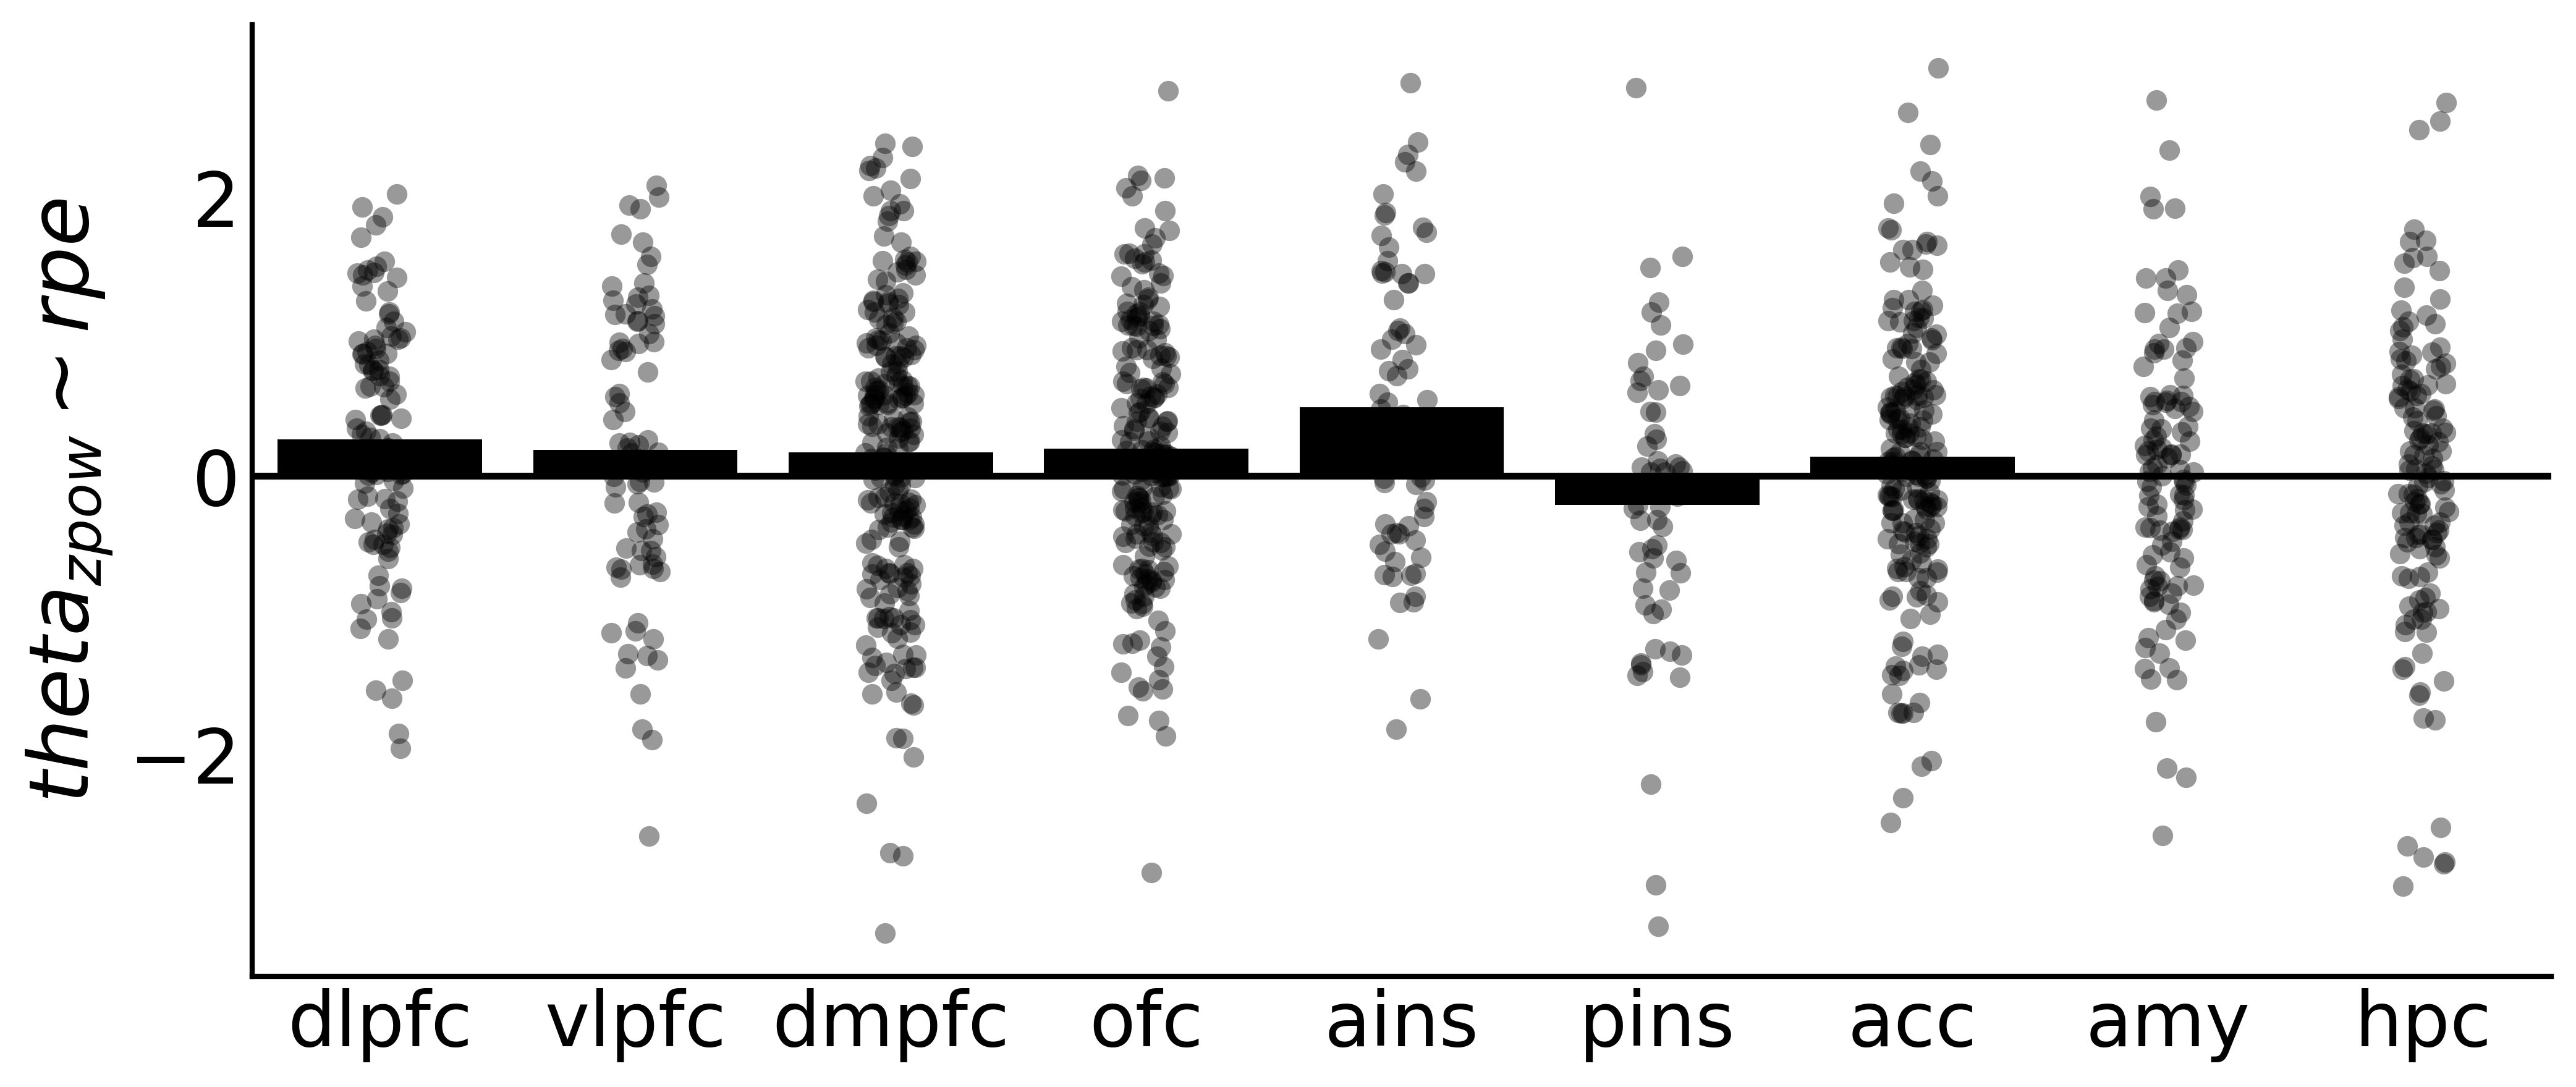

In [41]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim rpe$'


plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

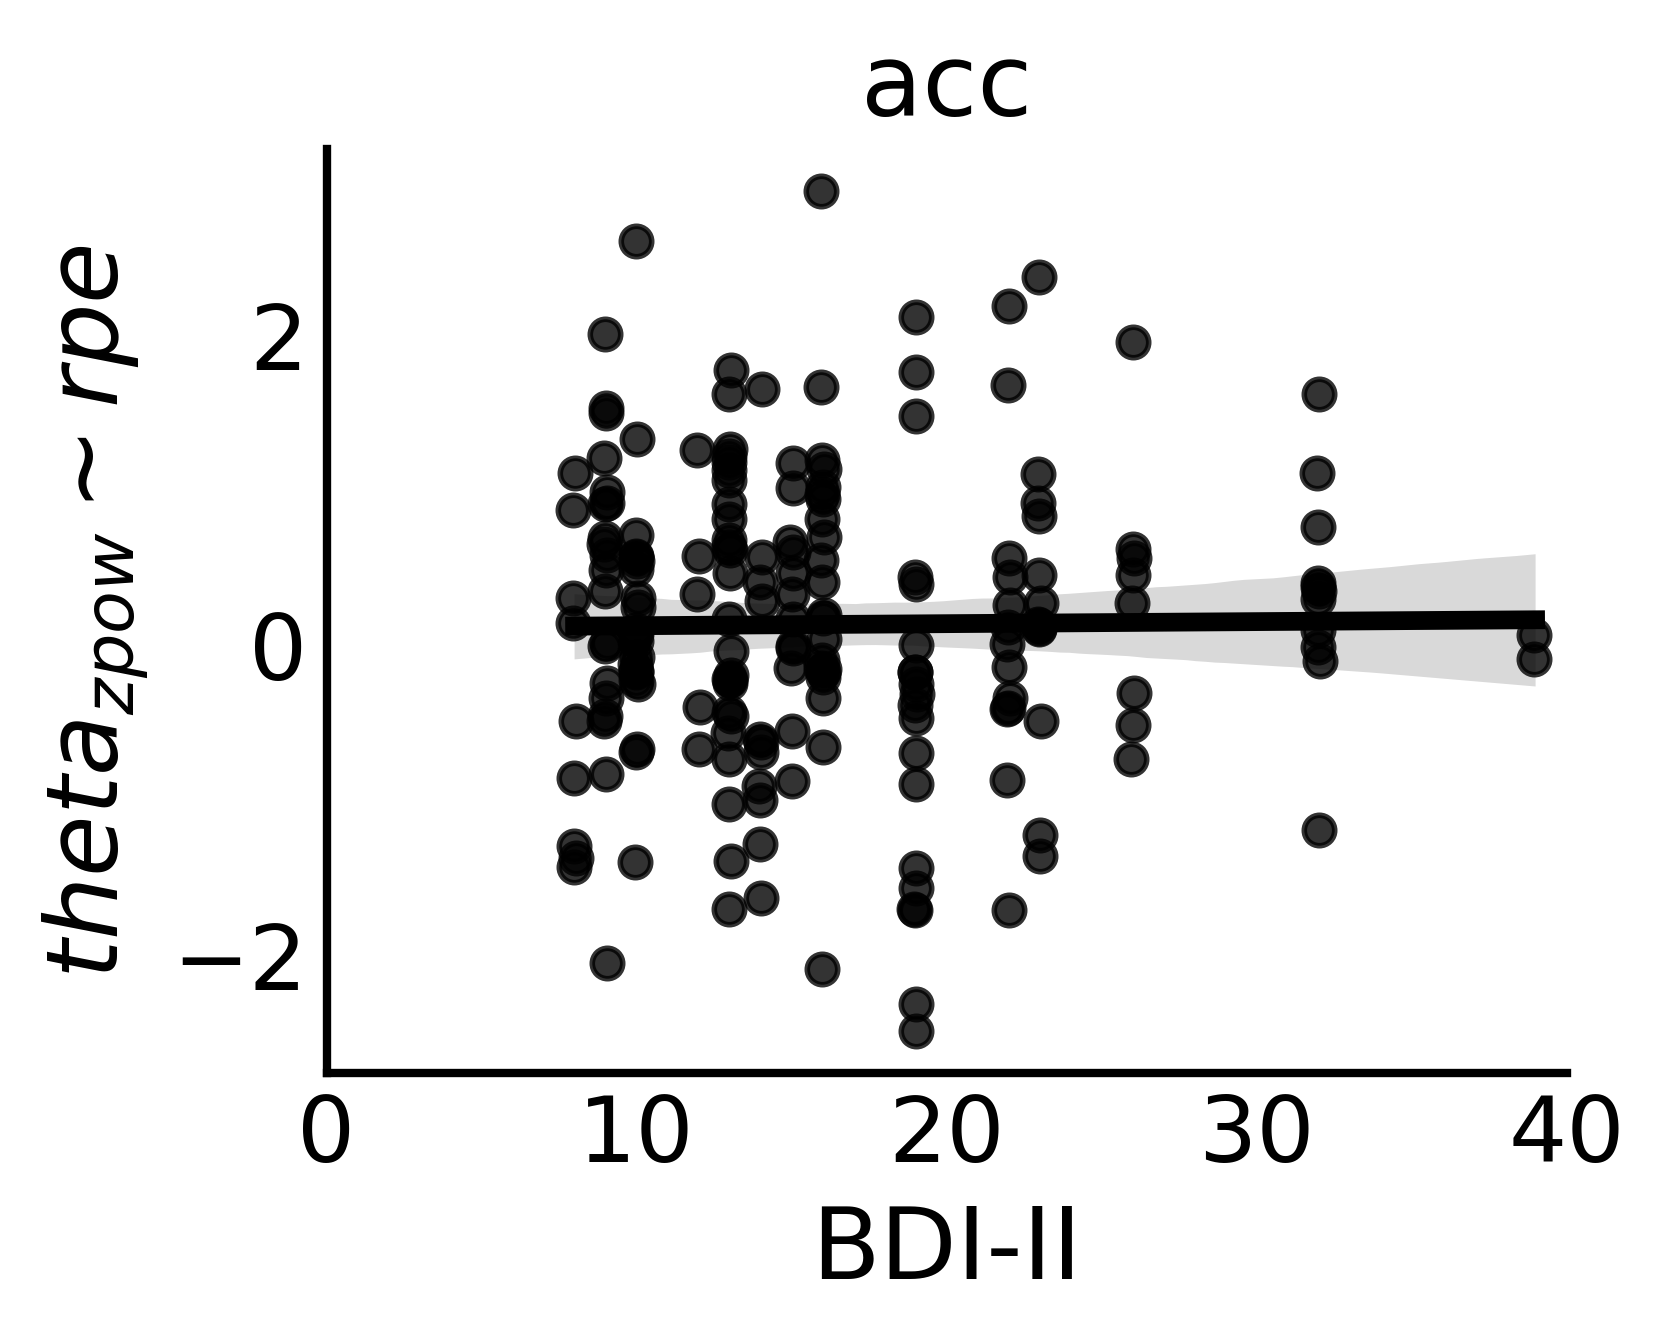

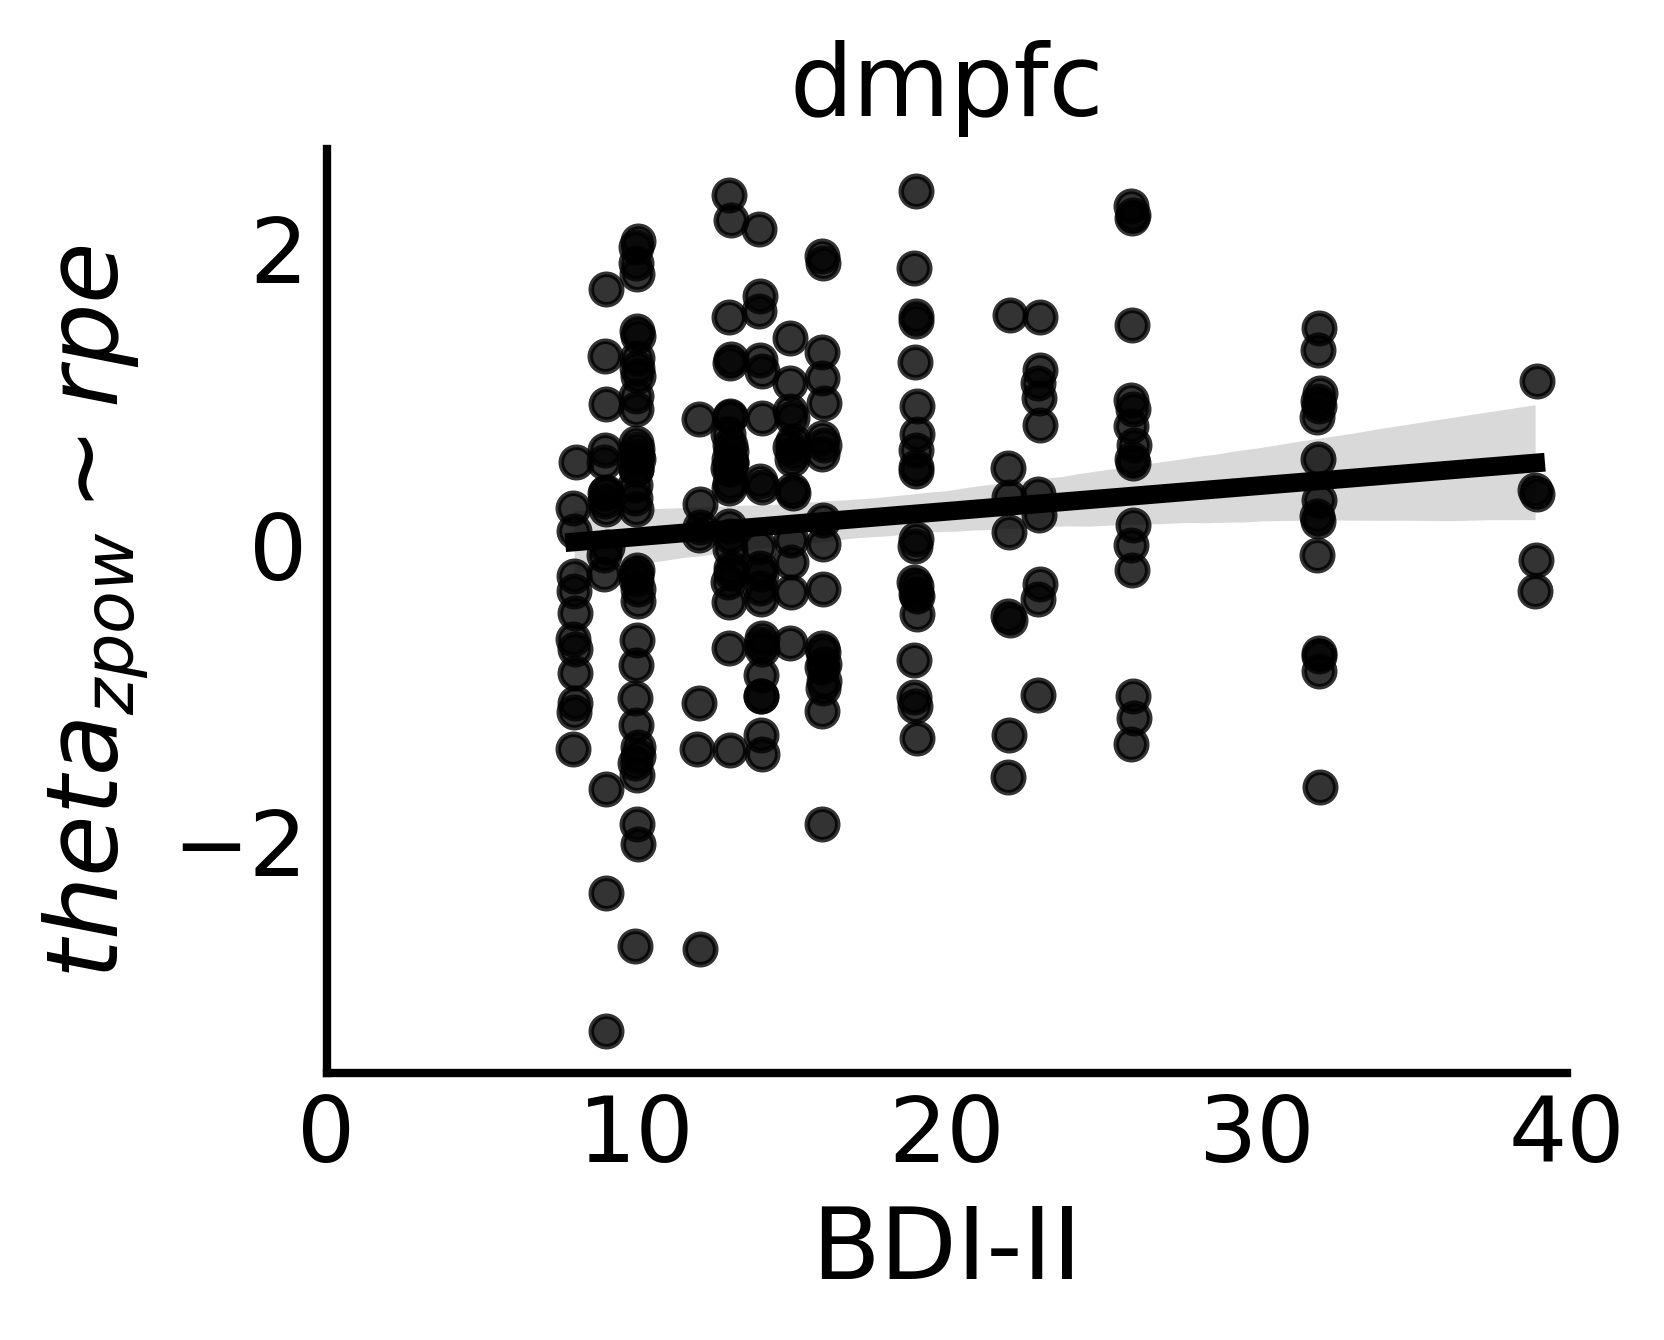

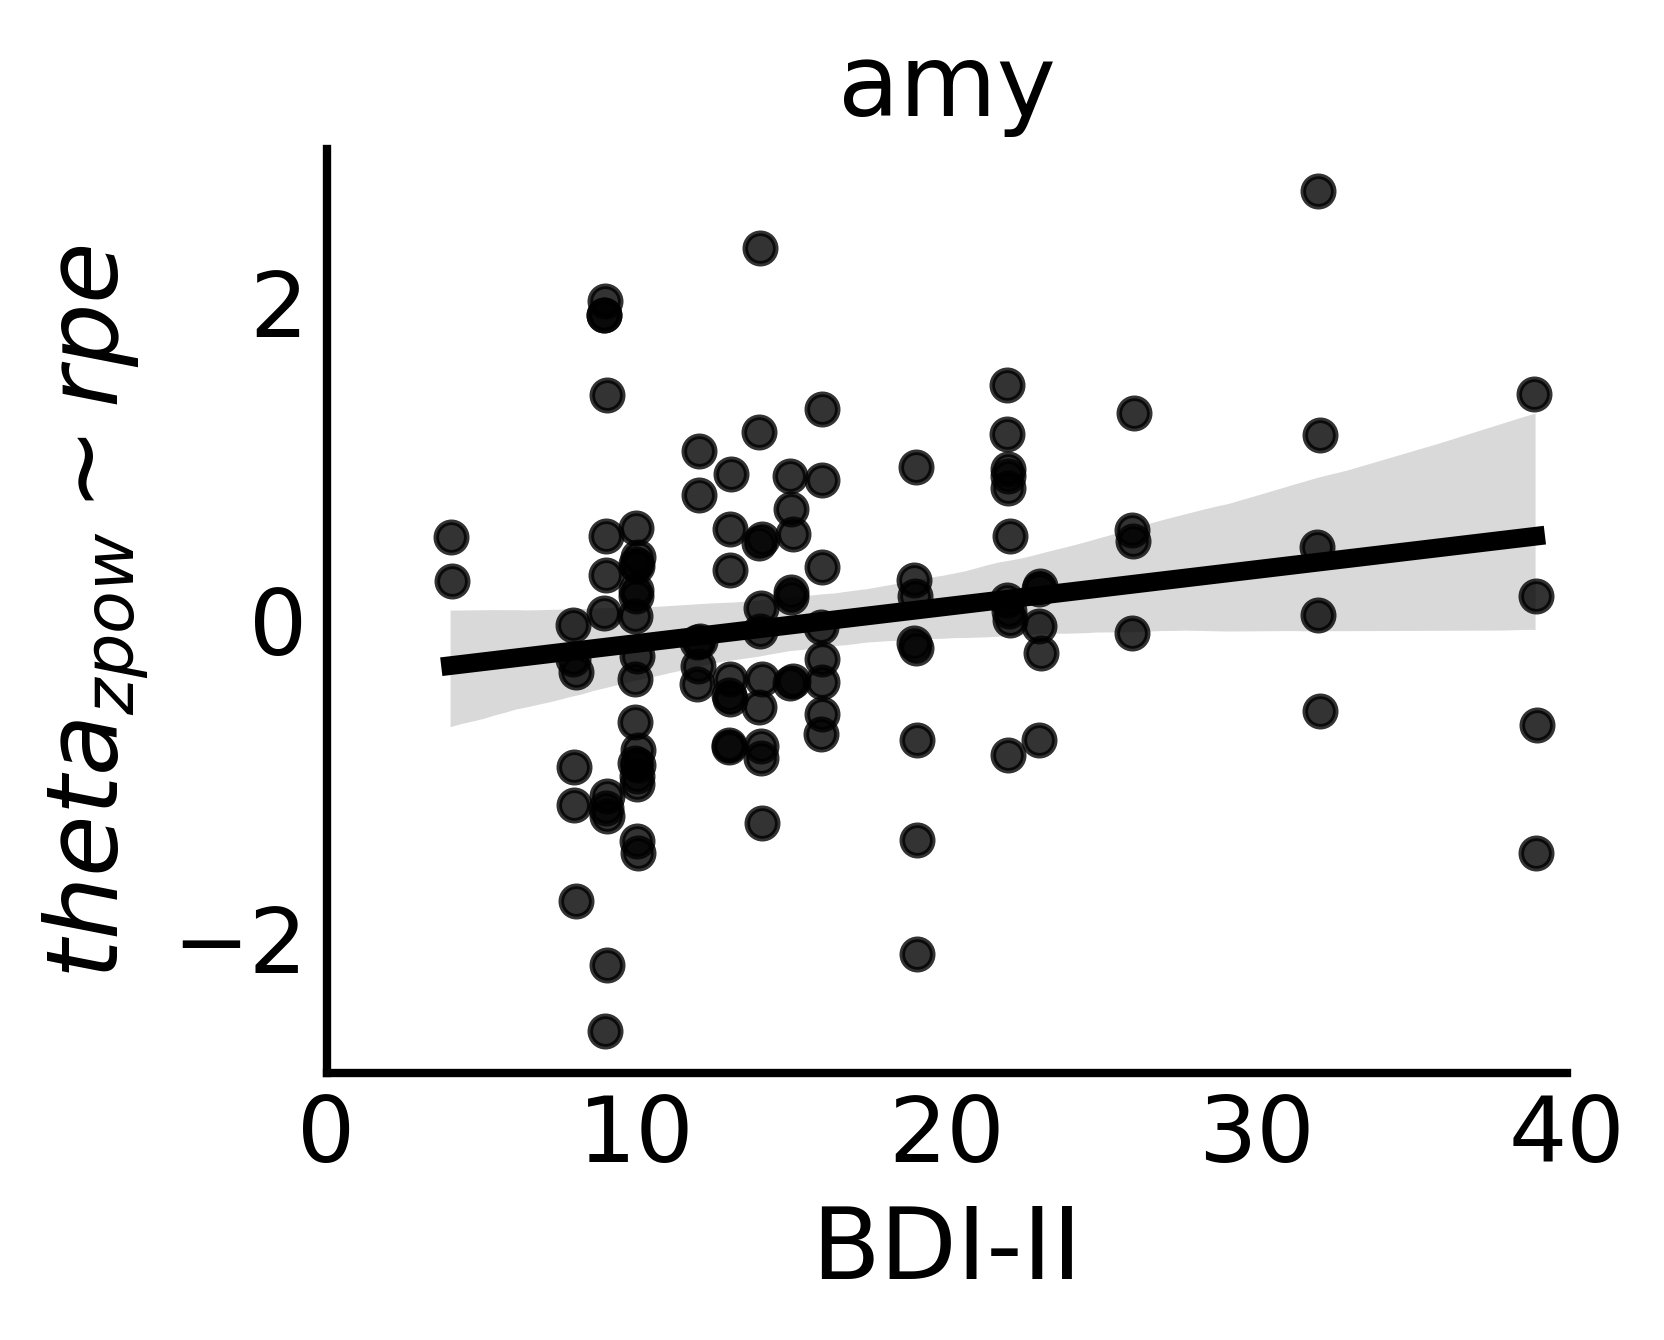

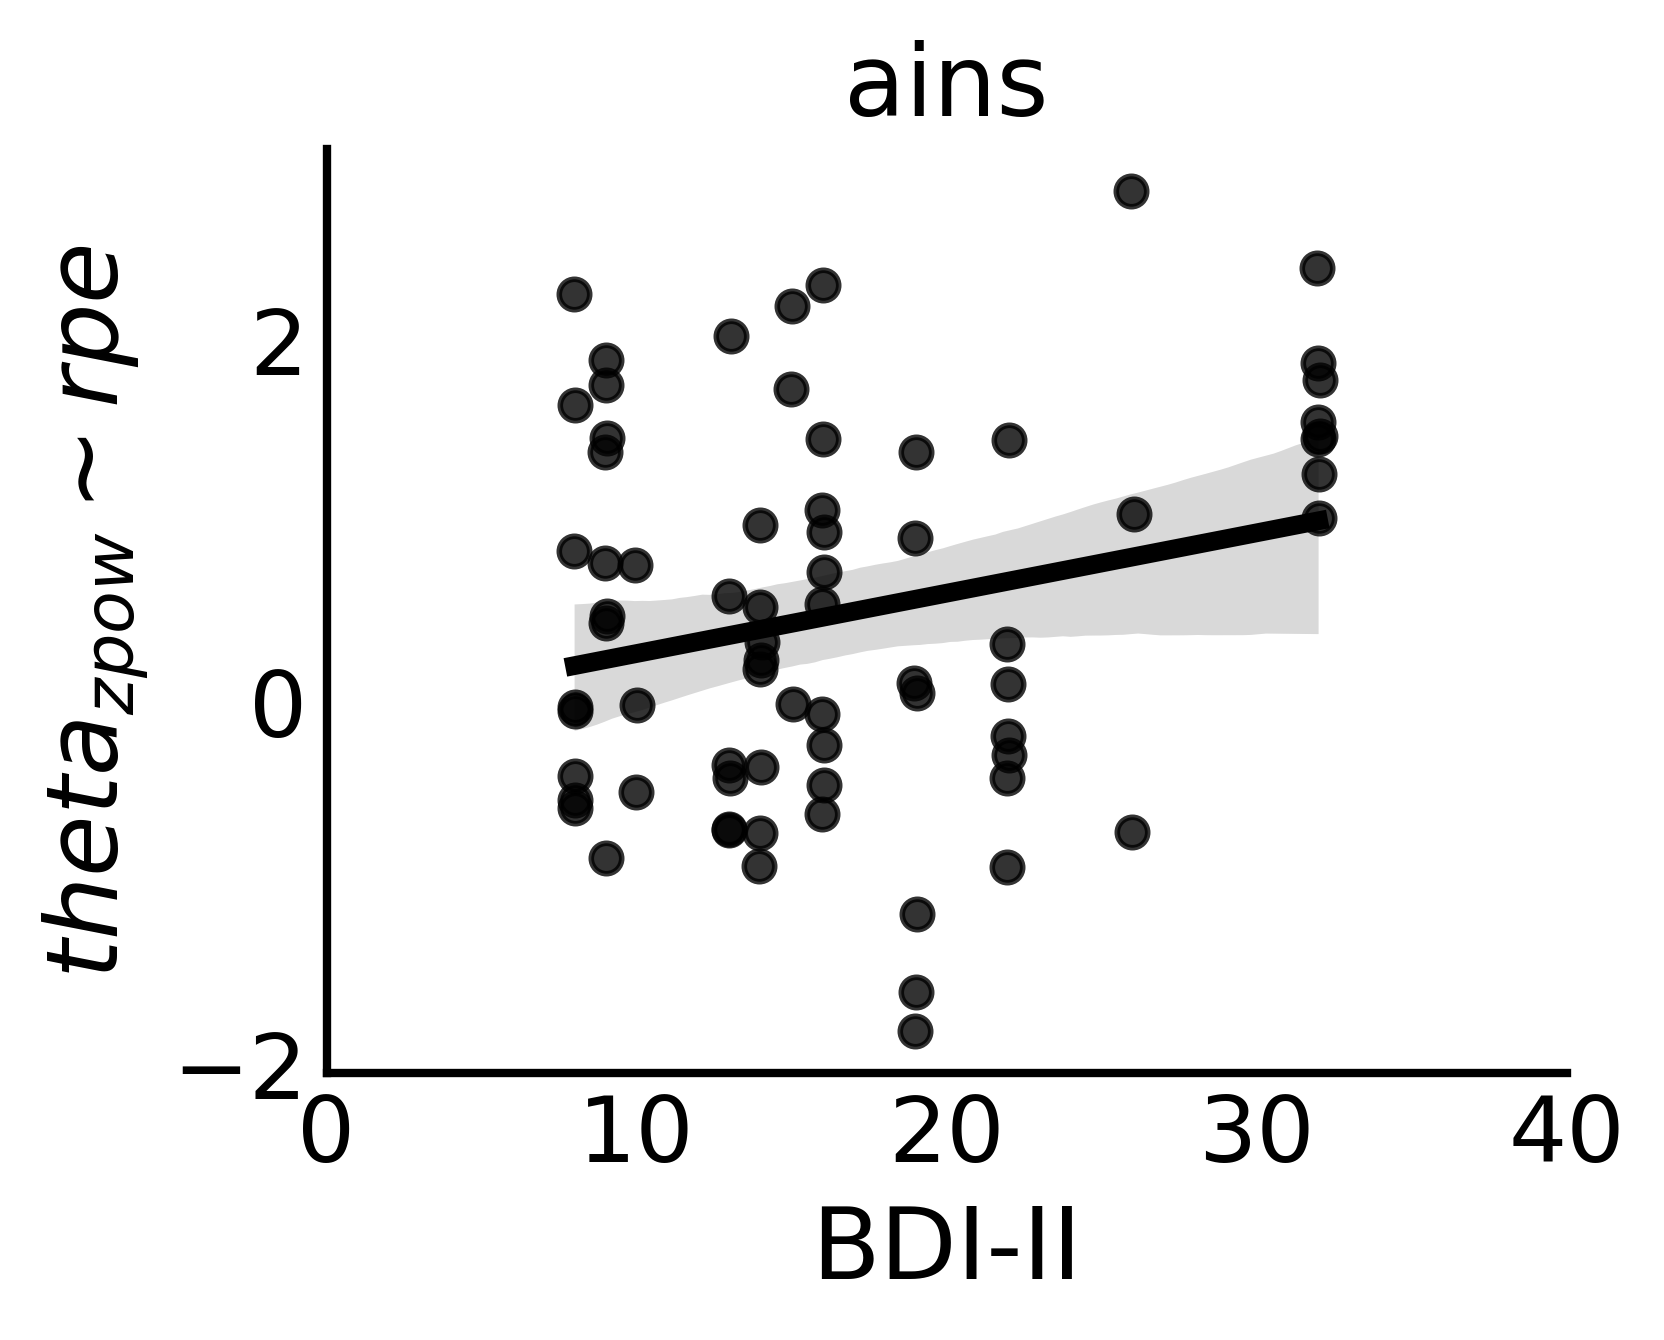

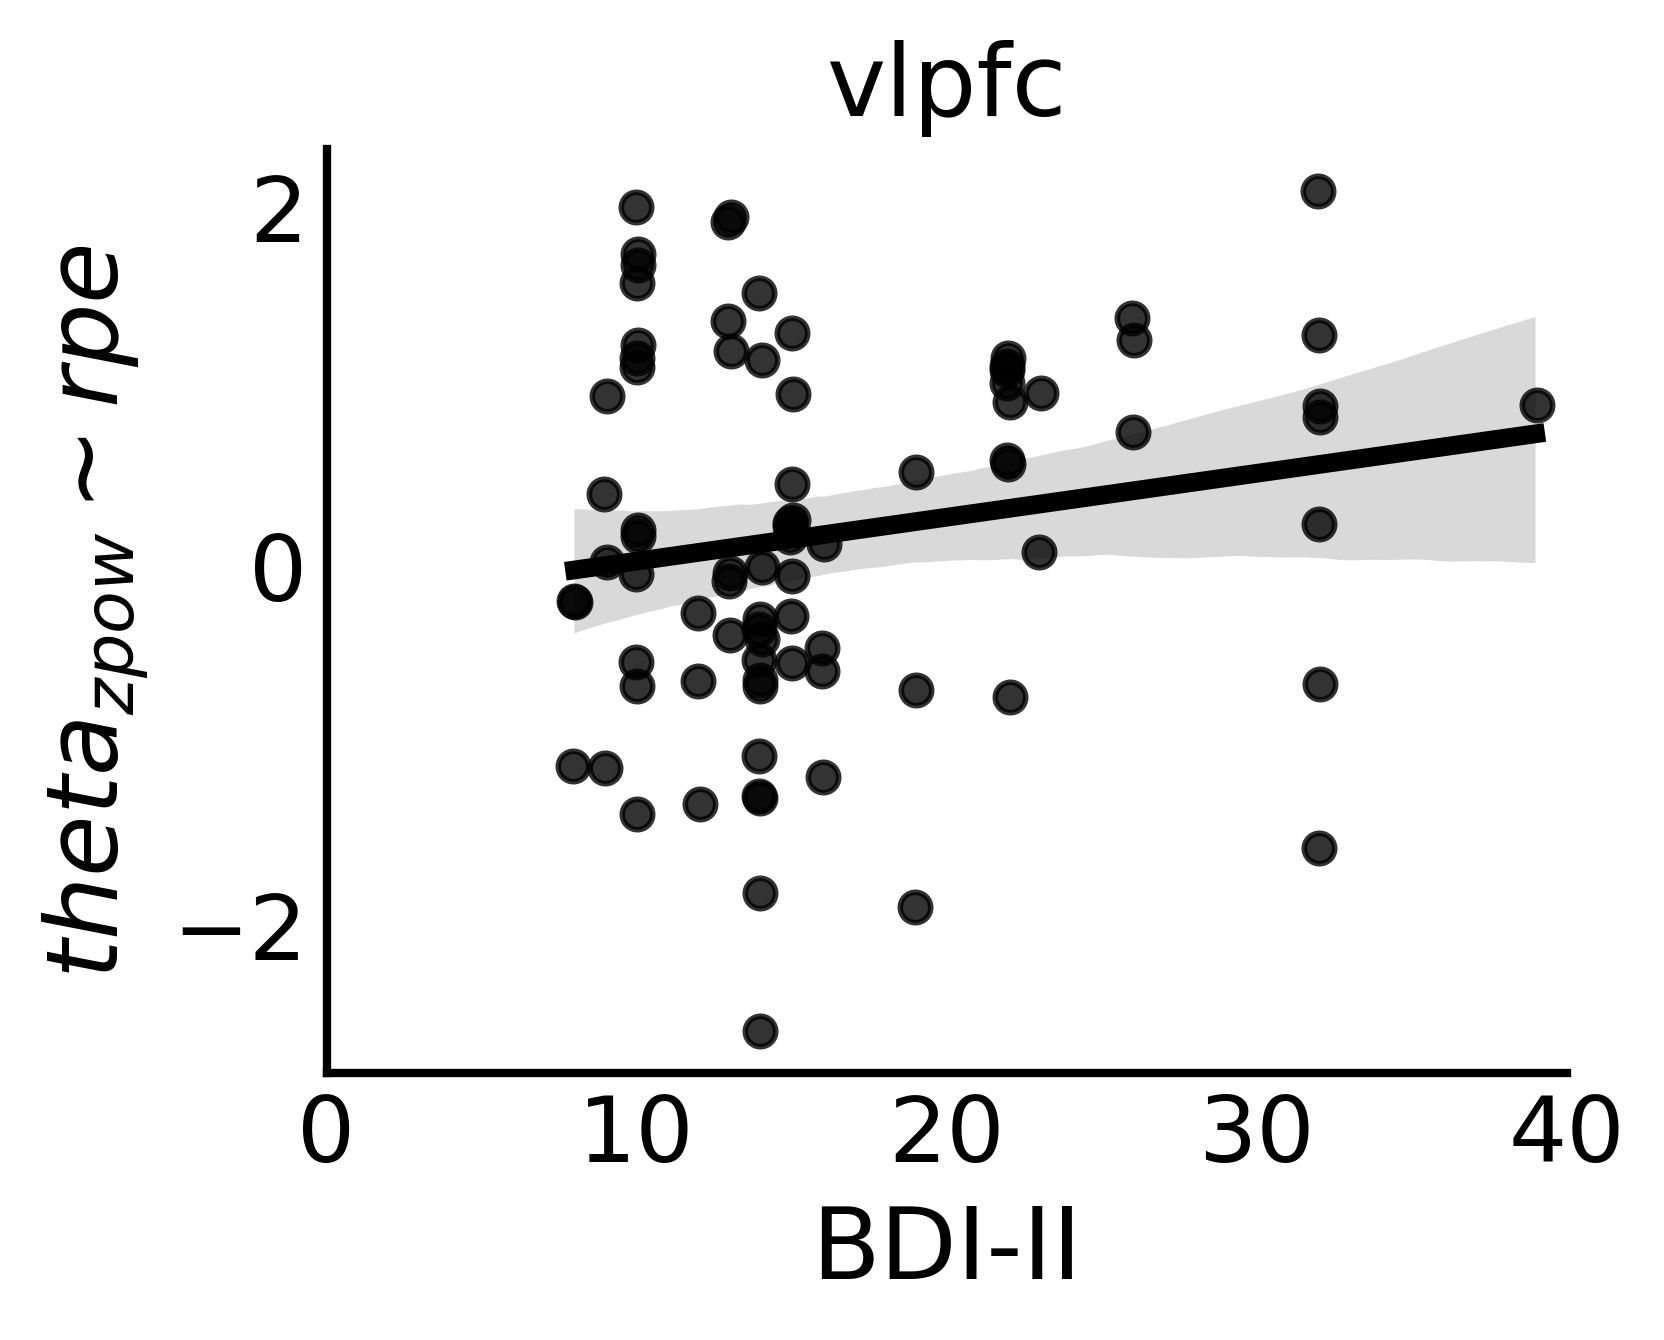

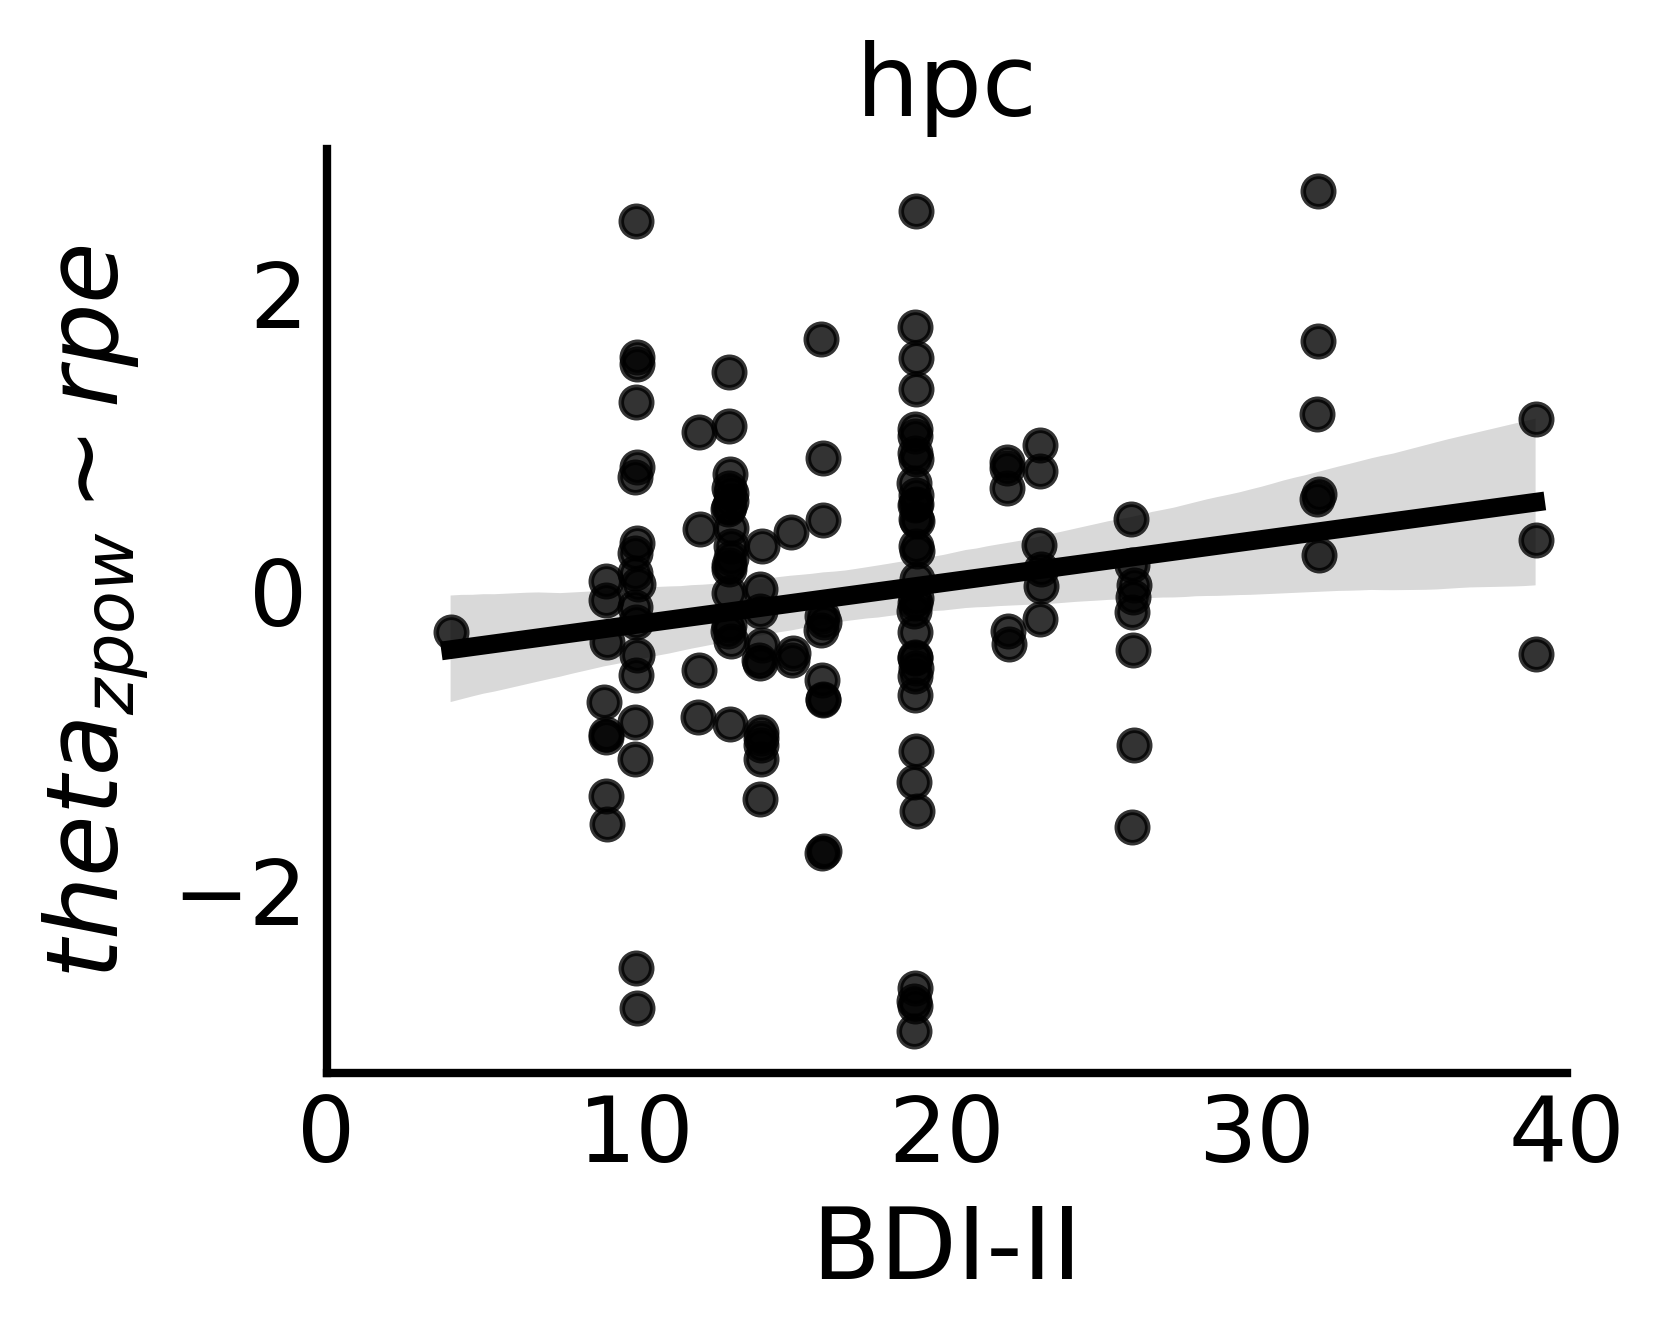

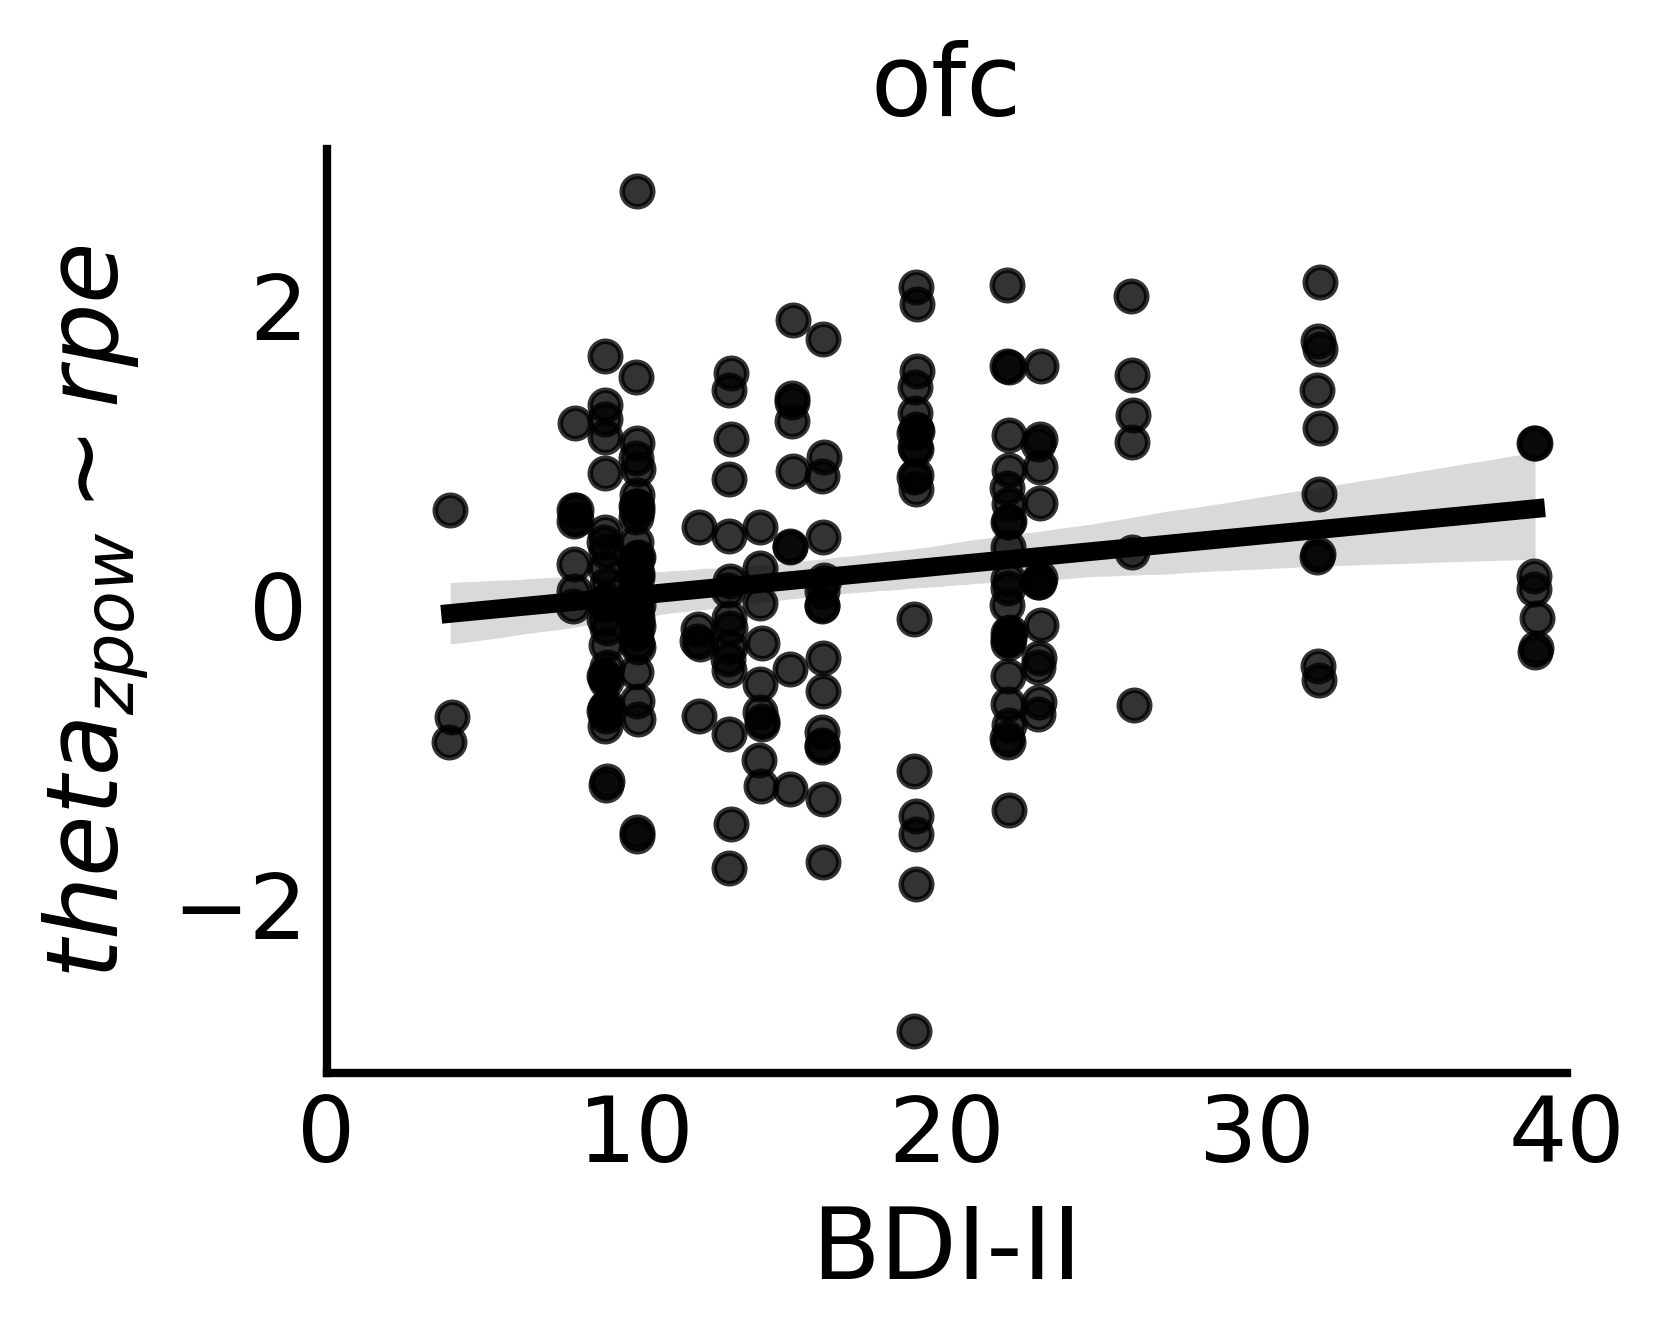

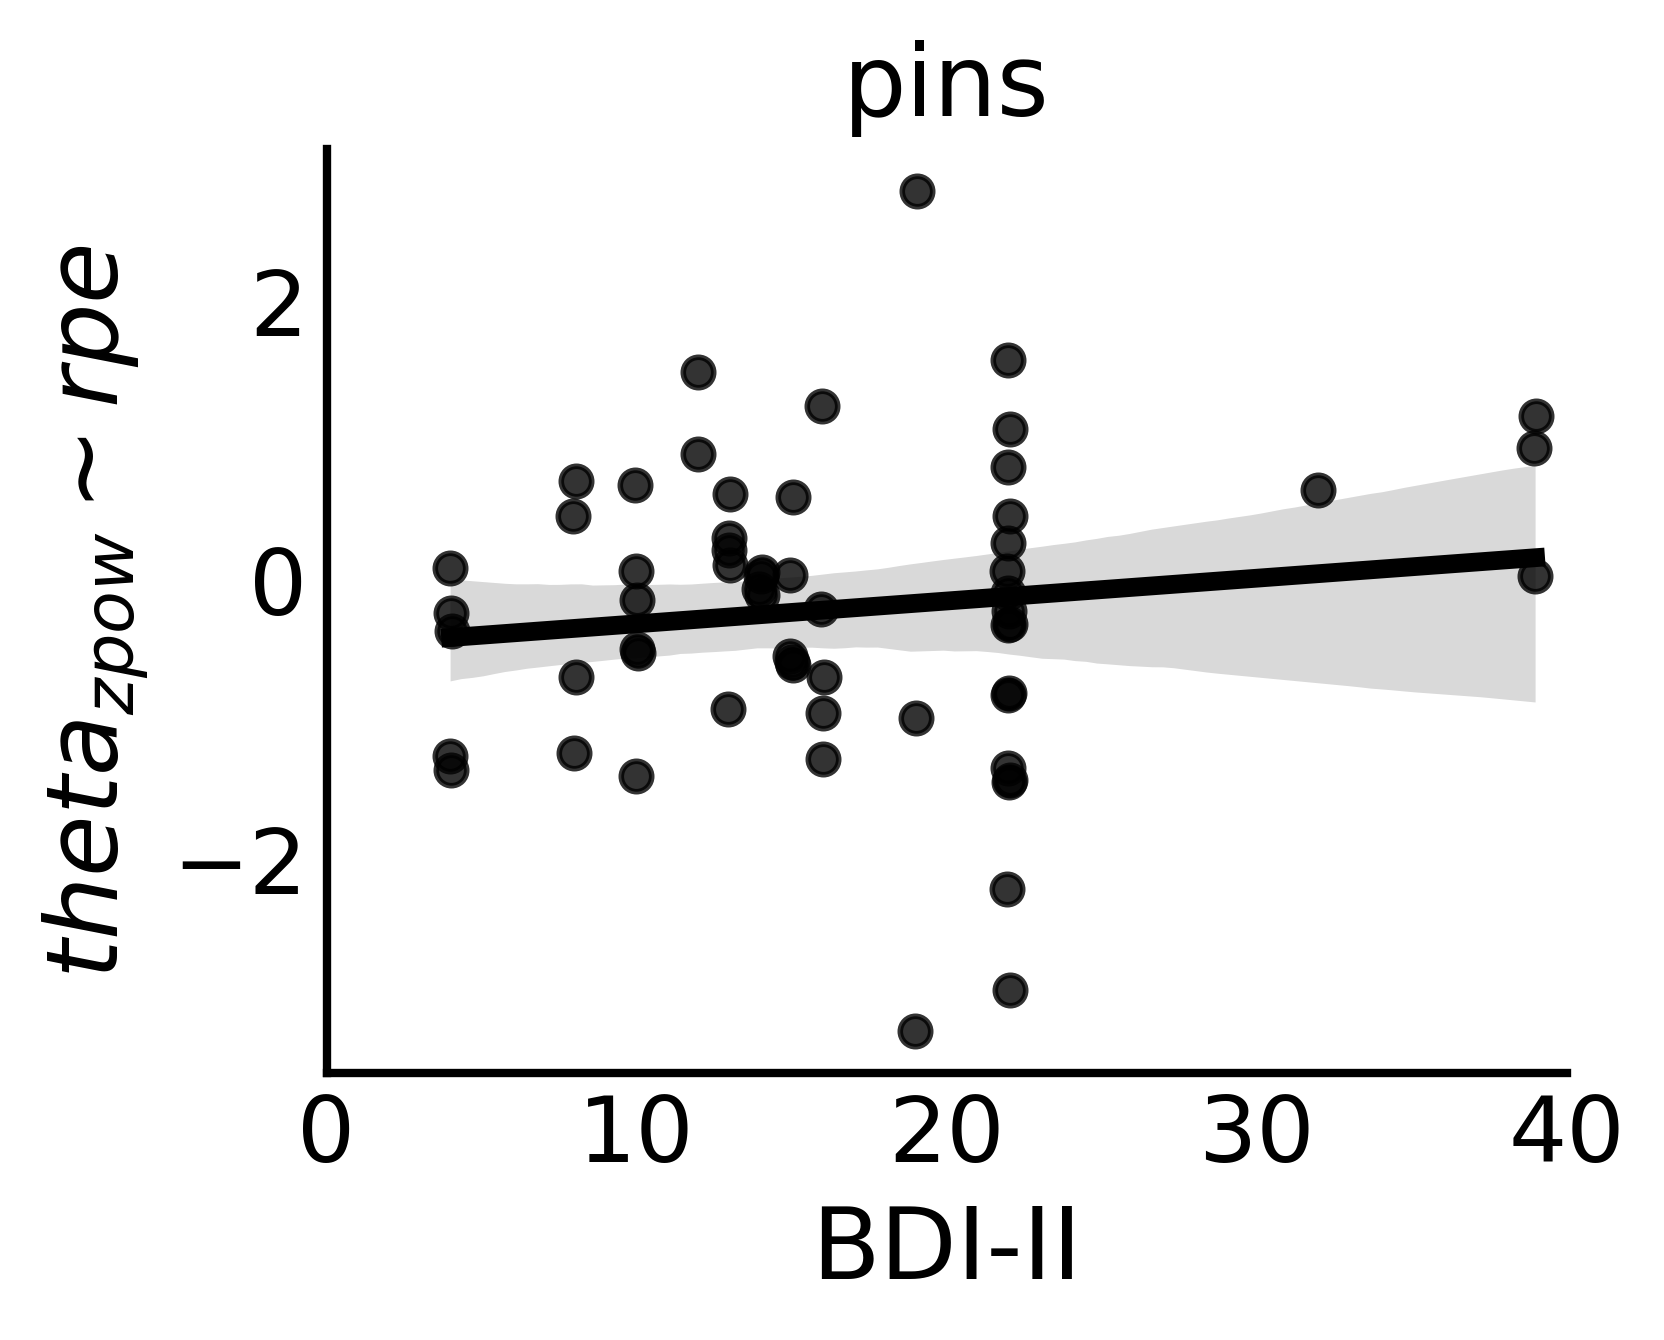

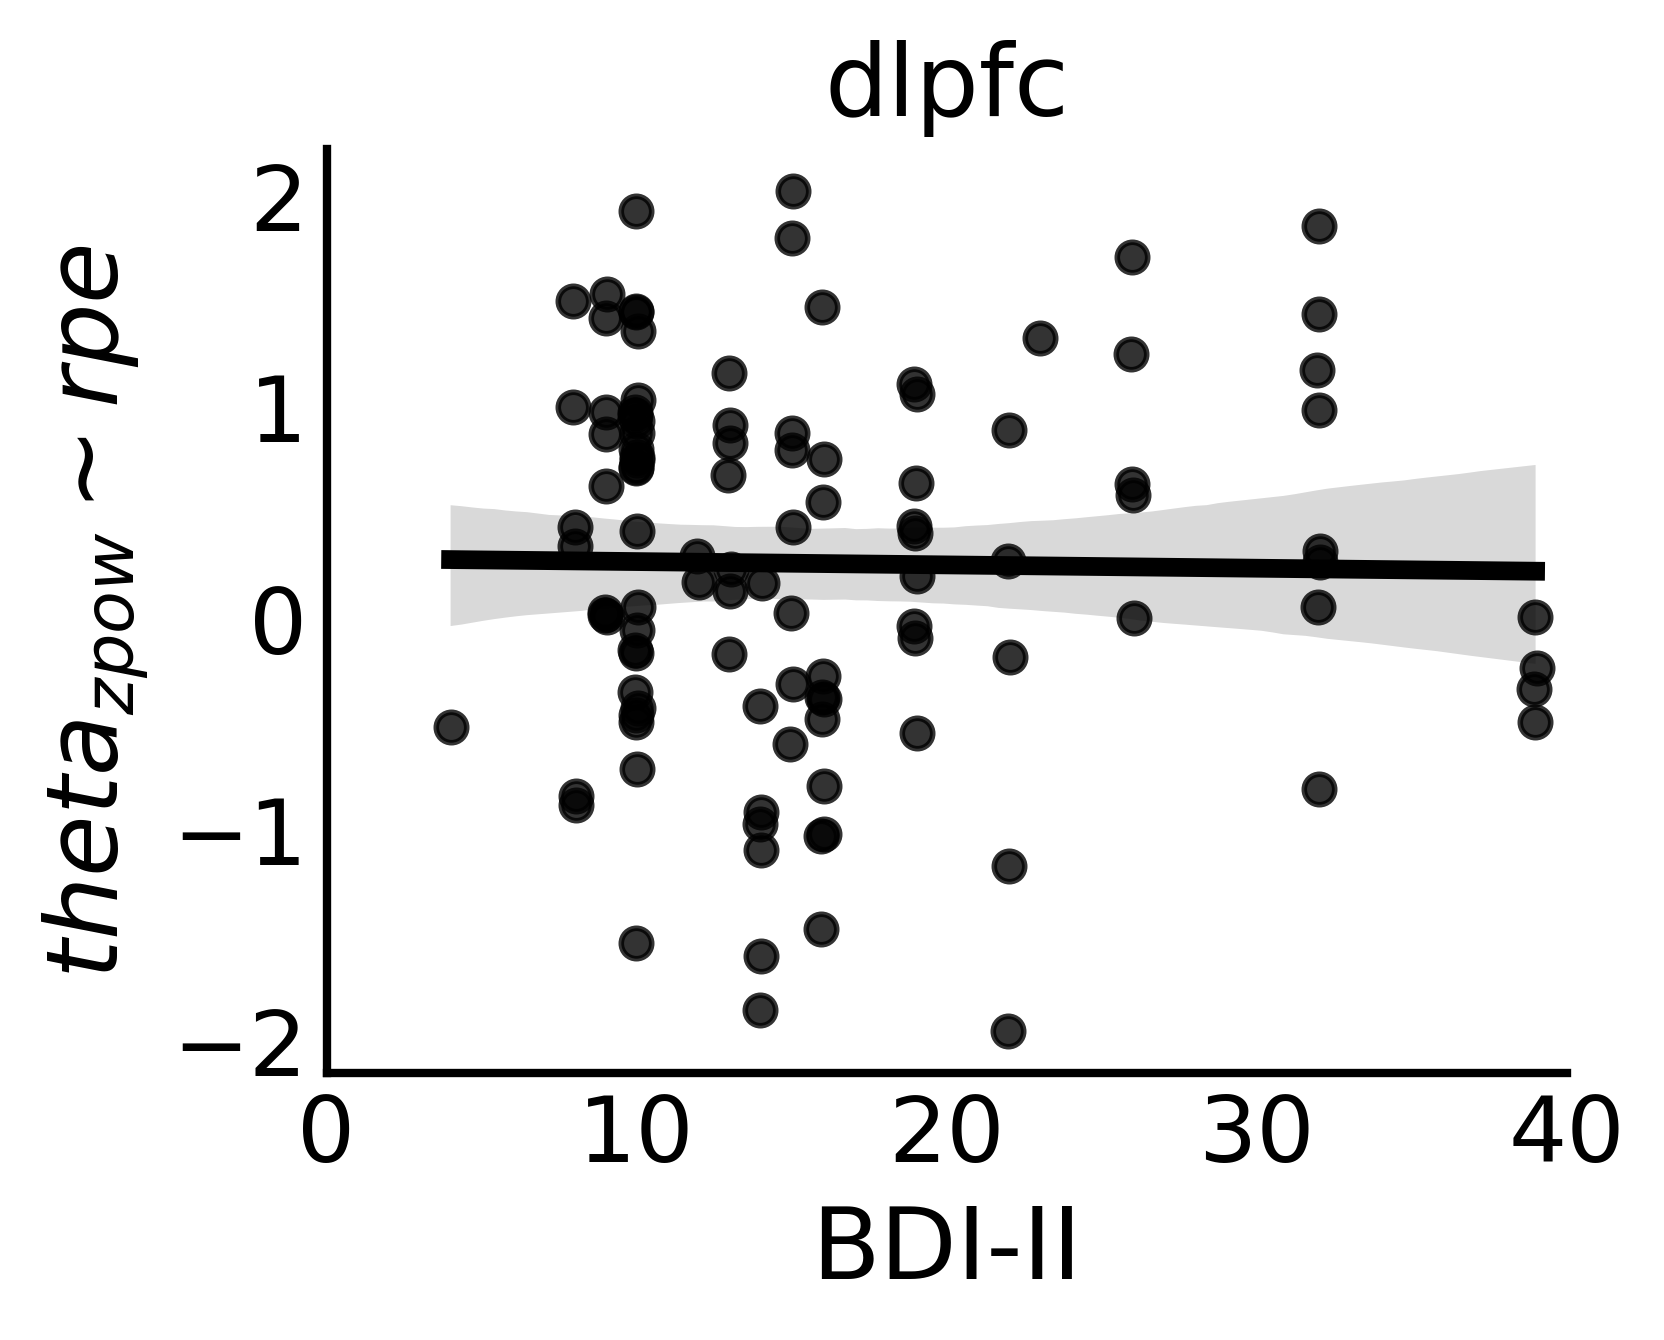

In [42]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-bdi_rpe_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [43]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        10:37:36                                         
No. Iterations:                    12                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.9528      0.457     34.875     

In [59]:
# del rpe_var

# Profit Results

In [44]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  \
17        MS002_laims6-laims7   MS002  vlpfc   14   
29        MS002_lloif6-lloif7   MS002  vlpfc   14   
63      MS002_raims11-raims12   MS002  dlpfc   14   
86        MS003_laimm3-laimm4   MS003   ains    8   
136       MS009_lacas4-lacas5   MS009    acc   16   
157       MS009_lmcms1-lmcms2   MS009    acc   16   
185       MS011_lmcps6-lmcps7   MS011  dmpfc   13   
188       MS011_lmolf5-lmolf6   MS011  vlpfc   13   
249       MS016_lmcms2-lmcms3   MS016    acc   10   
266       MS016_rhpit1-rhpit2   MS016    hpc   10   
273       MS017_lacas5-lacas6   MS017    acc   26   
277      MS017_lacas9-lacas10   MS017  dmpfc   26   
281       MS017_lalps2-lalps3   MS017   ains   26   
291       MS017_lmolf1-lmolf2   MS017    ofc   26   
293       MS017_lmolf3-lmolf4   MS017    ofc   26   
300       MS019_lacas8-lacas9   MS019  dmpfc   12   
342     MS022_lpcsma6-lpcsma7   MS022  dmpfc   10   
344     MS022_lpcsma8-lpcsma9   MS022  dmpfc   10   
388       MS024_raimm1-raimm2   MS024   ains   16   
406       MS024_rmolf2-rmolf3   MS024    ofc   16   
418       MS025_lhplt4-lhplt5   MS025    hpc   10   
468     MS026_racas10-racas11   MS026  dmpfc    9   
472       MS026_raglt4-raglt5   MS026    amy    9   
479       MS026_rmcms7-rmcms8   MS026  dmpfc    9   
511       MS027_liisp5-liisp6   MS027   pins   22   
518       MS027_racas1-racas2   MS027    acc   22   
569     MS028_laips11-laips12   MS028  dmpfc   13   
616       MS028_rmcms5-rmcms6   MS028  dmpfc   13   
628       MS029_laglt1-laglt2   MS029    amy   32   
636         MS029_lais5-lais6   MS029   ains   32   
644         MS029_lhph1-lhph2   MS029    hpc   32   
655       MS029_lmolf4-lmolf5   MS029    ofc   32   
705       MS030_lagit1-lagit2   MS030    amy   19   
709       MS030_lhpit1-lhpit2   MS030    hpc   19   
710       MS030_lhpit2-lhpit3   MS030    hpc   19   
711       MS030_lhpit3-lhpit4   MS030    hpc   19   
712       MS030_lhpit4-lhpit5   MS030    hpc   19   
714       MS030_lmcms2-lmcms3   MS030    acc   19   
715       MS030_lmcms3-lmcms4   MS030    acc   19   
719   MS030_lmoporb4-lmoporb5   MS030    ofc   19   
720   MS030_lmoporb5-lmoporb6   MS030    ofc   19   
724       MS030_lpipo1-lpipo2   MS030   pins   19   
768       MS035_laimm5-laimm6   MS035   ains   15   
770       MS035_laimm8-laimm9   MS035  dlpfc   15   
772     MS035_laimm10-laimm11   MS035  dlpfc   15   
820       MS035_rmolf1-rmolf2   MS035    ofc   15   
836     MS041_lacas12-lacas13   MS041  dmpfc   10   
853       MS041_lhplt2-lhplt3   MS041    hpc   10   
904       MS041_rmolf4-rmolf5   MS041    ofc   10   
911       MS043_lacas5-lacas6   MS043    acc   23   
981       MS048_lmcms4-lmcms5   MS048  dmpfc   19   
988       MS048_lmolf6-lmolf7   MS048    ofc   19   
989       MS048_lmolf7-lmolf8   MS048    ofc   19   
996       MS048_lpvnh6-lpvnh7   MS048    hpc   19   
1045      MS050_lacas3-lacas4   MS050    acc    9   
1048    MS050_lacas10-lacas11   MS050  dmpfc    9   
1055    MS050_lainss3-lainss4   MS050   ains    9   
1056    MS050_lainss4-lainss5   MS050   ains    9   
1128          DA023_lam1-lam2   DA023    amy   14   
1171          DA039_rfp6-rfp7   DA039    ofc   22   

      Original_Estimate_Intercept  Original_Estimate_GambleChoice[T.safe]  \
17                       0.266224                                0.034635   
29                       0.080259                               -0.052651   
63                       0.130692                                0.109883   
86                       0.362176                                0.144727   
136                      0.172137                               -0.063367   
157                     -0.043490                                0.078016   
185                      0.006448                               -0.075917   
188                     -0.292066                                0.184587   
249                      0.123997                                0.056058   
266        

In [45]:
sig_data.roi.value_counts()



roi
dmpfc    12
ofc      11
hpc       9
acc       9
ains      7
amy       4
vlpfc     3
dlpfc     3
pins      2
Name: count, dtype: int64

In [46]:
sig_data.roi.unique()



array(['vlpfc', 'dlpfc', 'ains', 'acc', 'dmpfc', 'hpc', 'ofc', 'amy',
       'pins'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [47]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.178532   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.027547   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.100227   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.074052   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.150687   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.121315                   0.057614   
1                                0.097663                  -0.411165   
2                                0.026397                  -0.230580   
3                                0.033745                  -0.134145   
4                                0.043390                  -0.115698   

   Original_Estimate_Profit  Original_Estimate_rpe  Original_Estimate_cpe  \
0                 -0.097763               0.108548               0.011917   
1                  0.556902              -0.264509              -0.045543   
2                  0.140344              -0.182327              -0.014402   
3                  0.378797              -0.382133               0.027778   
4                  0.219249              -0.184222               0.001610   

   ...  P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0  ...           0.125272                      0.125275         0.840016   
1  ...           0.336480                      0.336160         0.217391   
2  ...           0.724365                      0.718342         0.442568   
3  ...           0.706580                      0.708887         0.703476   
4  ...           0.622994                      0.623199         0.726614   

   P_Value_Profit  P_Value_rpe  P_Value_cpe  cpe_sig  bdi_split  rpe_sig  \
0        0.797444     0.679888     0.872123        0          0        0   
1        0.211175     0.365578     0.700002        0          0        0   
2        0.737074     0.492852     0.906663        0          0        0   
3        0.400344     0.200205     0.778894        0          0        0   
4        0.620306     0.534080     0.975150        0          0        0   

   Profit_sig  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 38 columns]

In [48]:
Profit_var = 'Z_Score_Profit'

In [49]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [50]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc   -0.282114
vlpfc   -0.228245
dmpfc   -0.222998
ofc     -0.318602
ains    -0.452609
pins     0.198398
acc     -0.109064
amy      0.054645
hpc     -0.023860
Name: Z_Score_Profit, dtype: float64

In [51]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [52]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193      9  0.046632              3   -1.577943    0.116225   
1  dmpfc      225     12  0.053333              1   -3.270429    0.001243   
2    amy      113      4  0.035398              1    0.619761    0.536674   
3   ains       71      7  0.098592              2   -3.710854    0.000411   
4  vlpfc       82      3  0.036585              0   -2.033949    0.045230   
5    hpc      135      9  0.066667              1   -0.266018    0.790634   
6    ofc      202     11  0.054455              4   -5.032399    0.000001   
7   pins       60      2  0.033333              1    1.544544    0.127804   
8  dlpfc      107      3  0.028037              0   -2.999314    0.003373   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.024540            1.0    0.046632      0.6315  
1      0.031059            1.0    0.053333      0.4513  
2      0.012180            1.0    0.035398      0.8219  
3      0.047193            1.0    0.098592      0.0642  
4      0.010045            1.0    0.036585      0.7836  
5      0.035217            1.0    0.066667      0.2349  
6      0.030835            1.0    0.054455      0.4298  
7      0.005955            1.0    0.033333      0.8084  
8      0.007685            1.0    0.028037      0.9076

In [53]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

Empty DataFrame
Columns: [roi, n_total, n_sig, prop_sig, n_sig_highbdi, ttest_stat, ttest_pval, binom_ci_low, binom_ci_high, binom_prop, binom_pval]
Index: []

# Plot Results

In [54]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_combomodel-Profit_coeff_barplot_{epoch_len}.pdf'


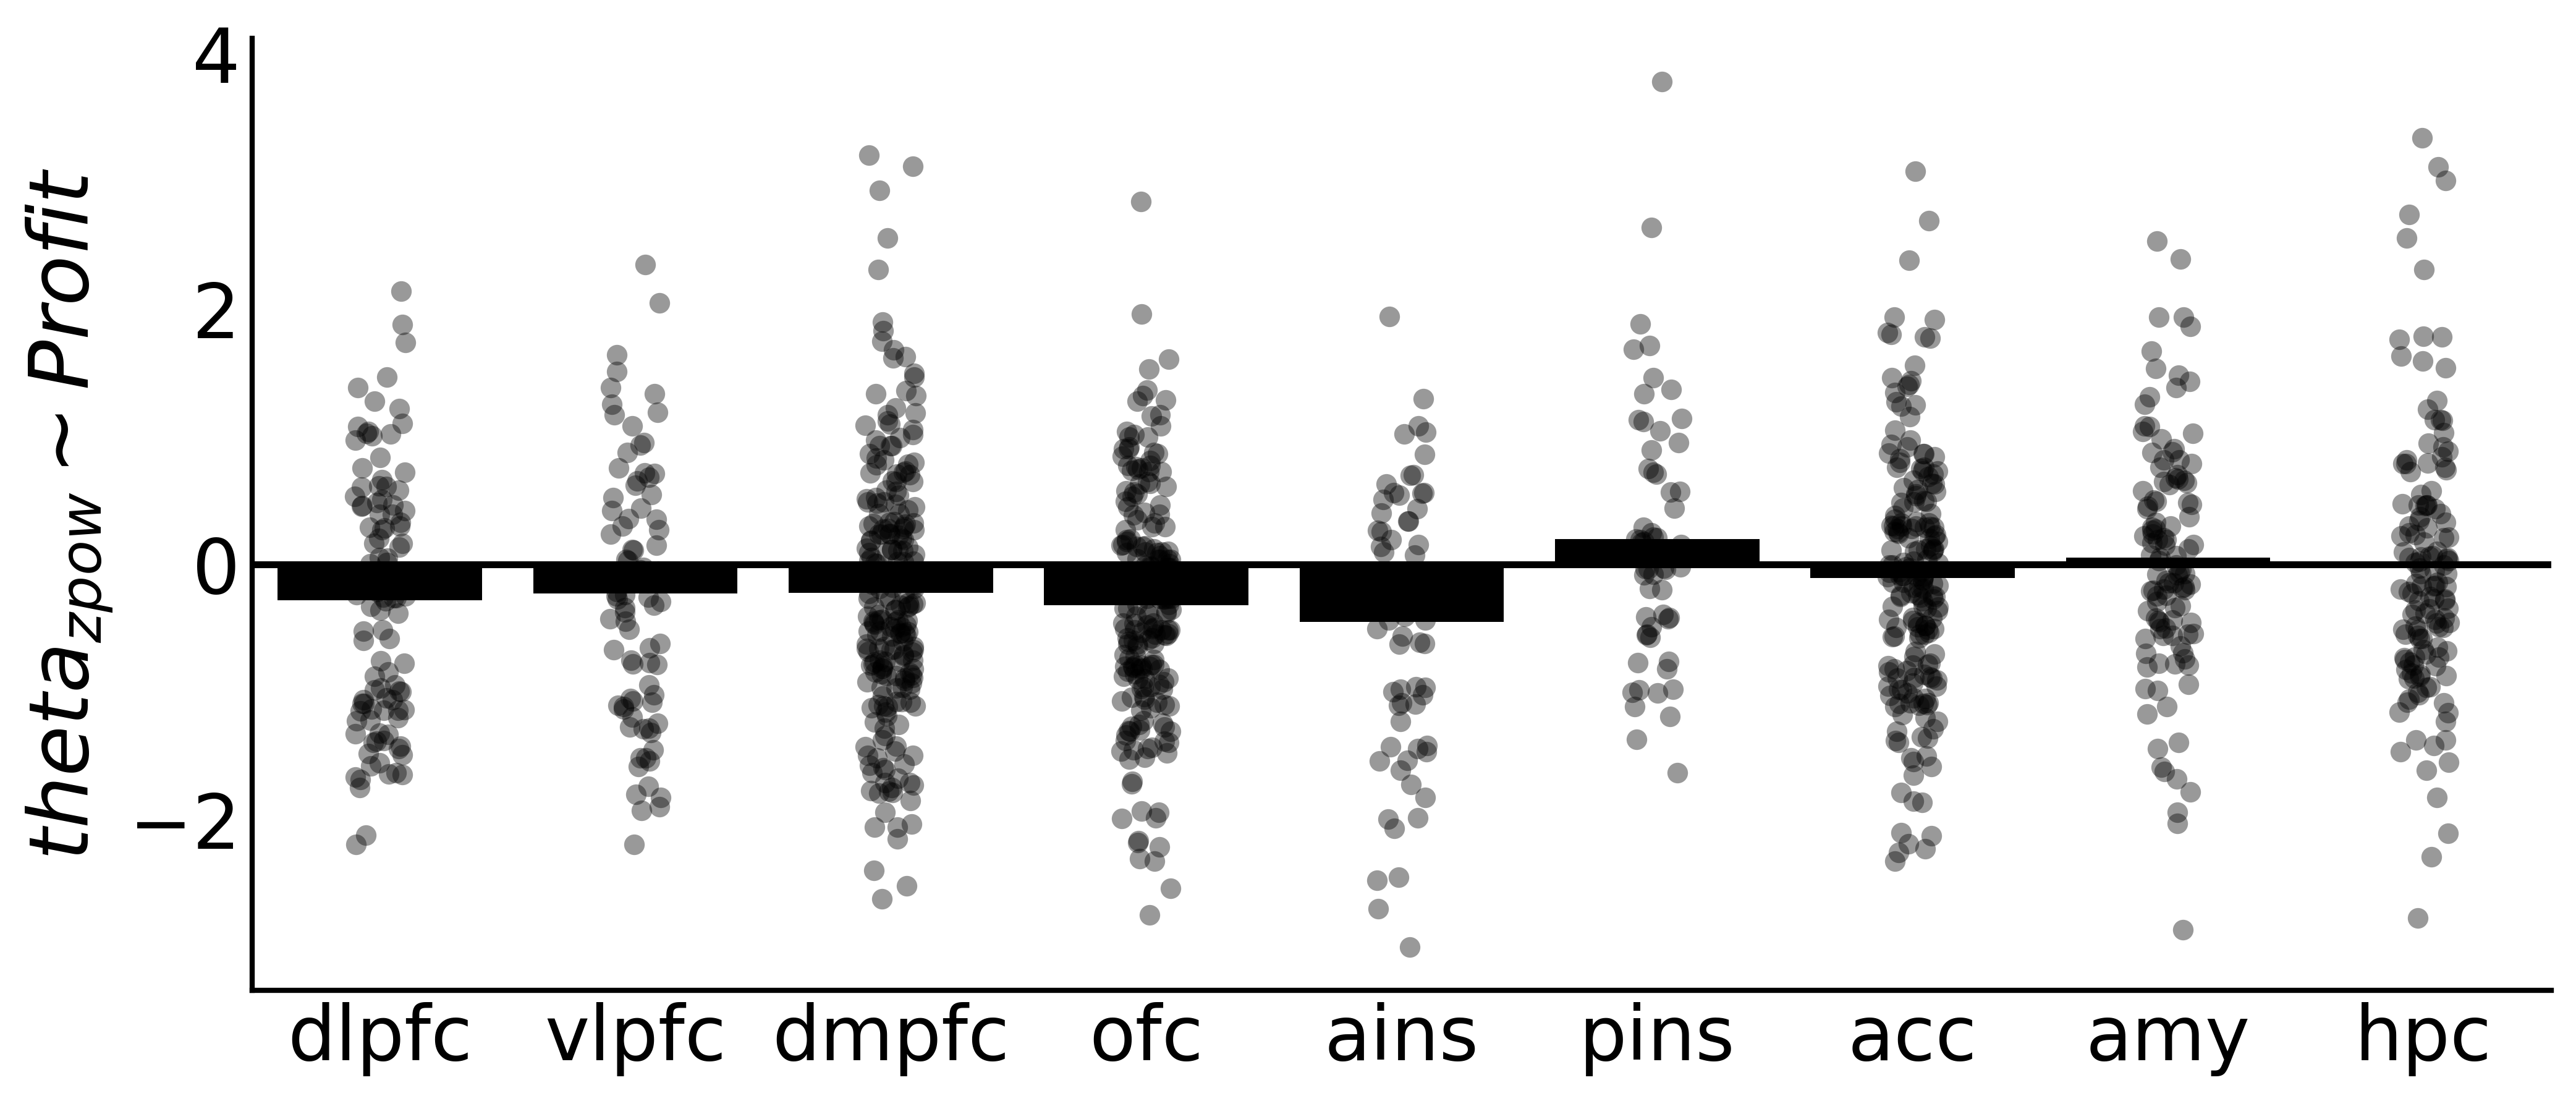

In [55]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim Profit$'


plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

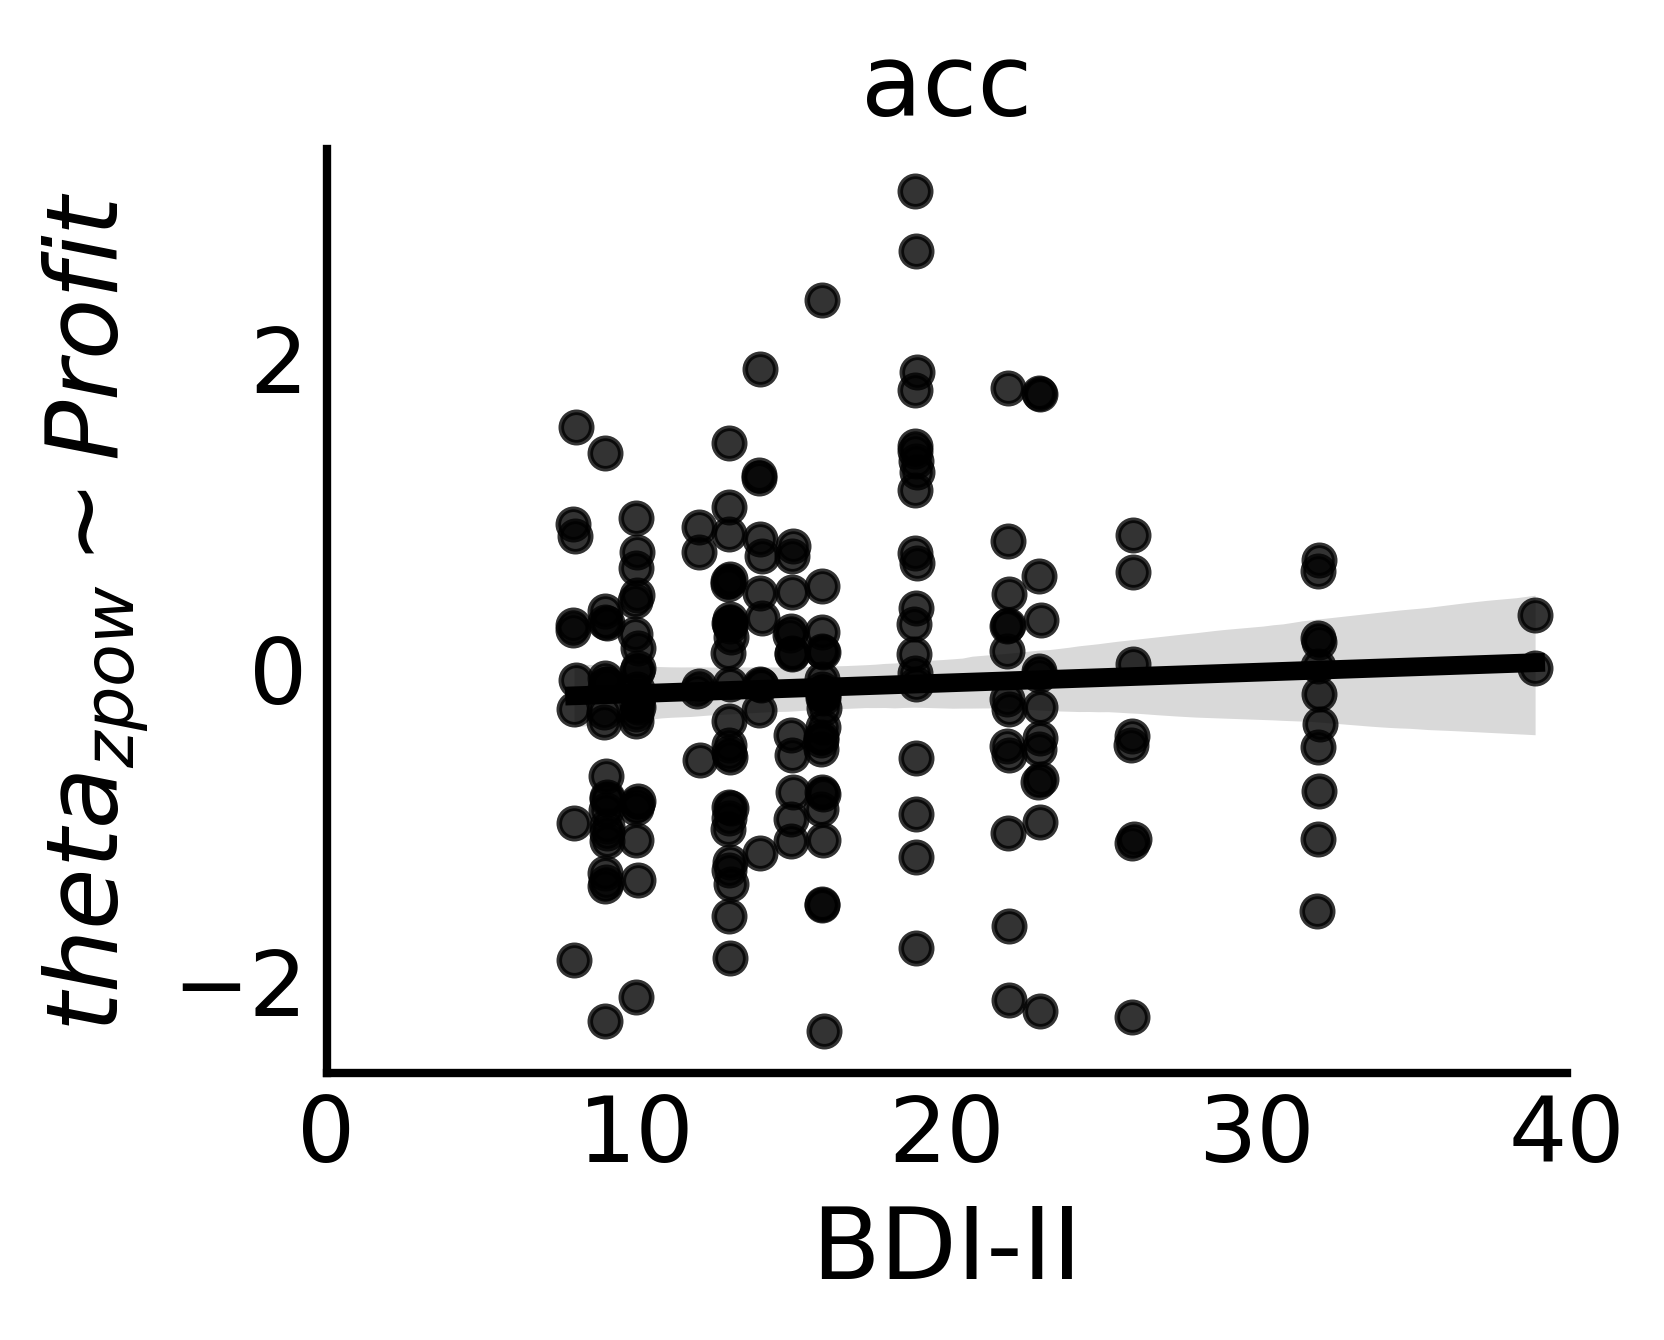

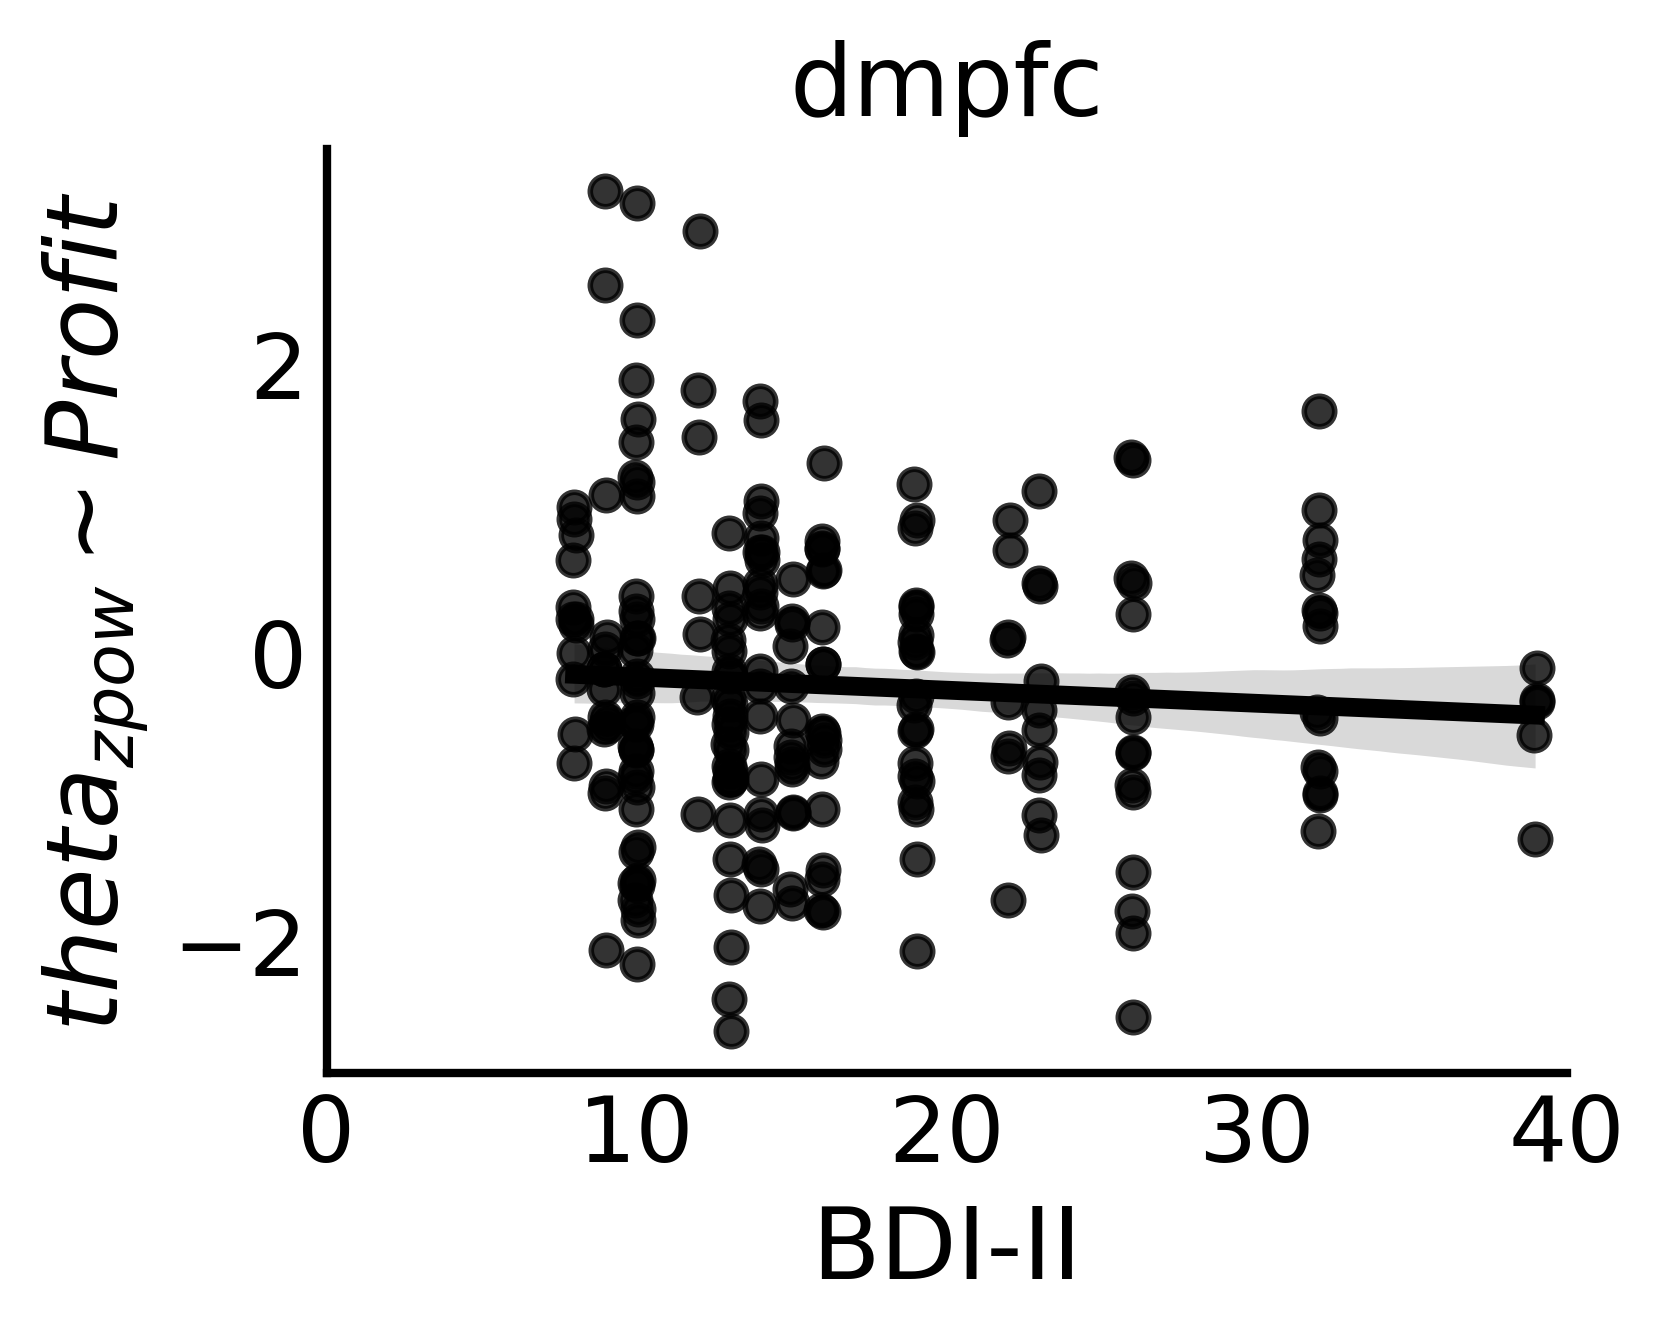

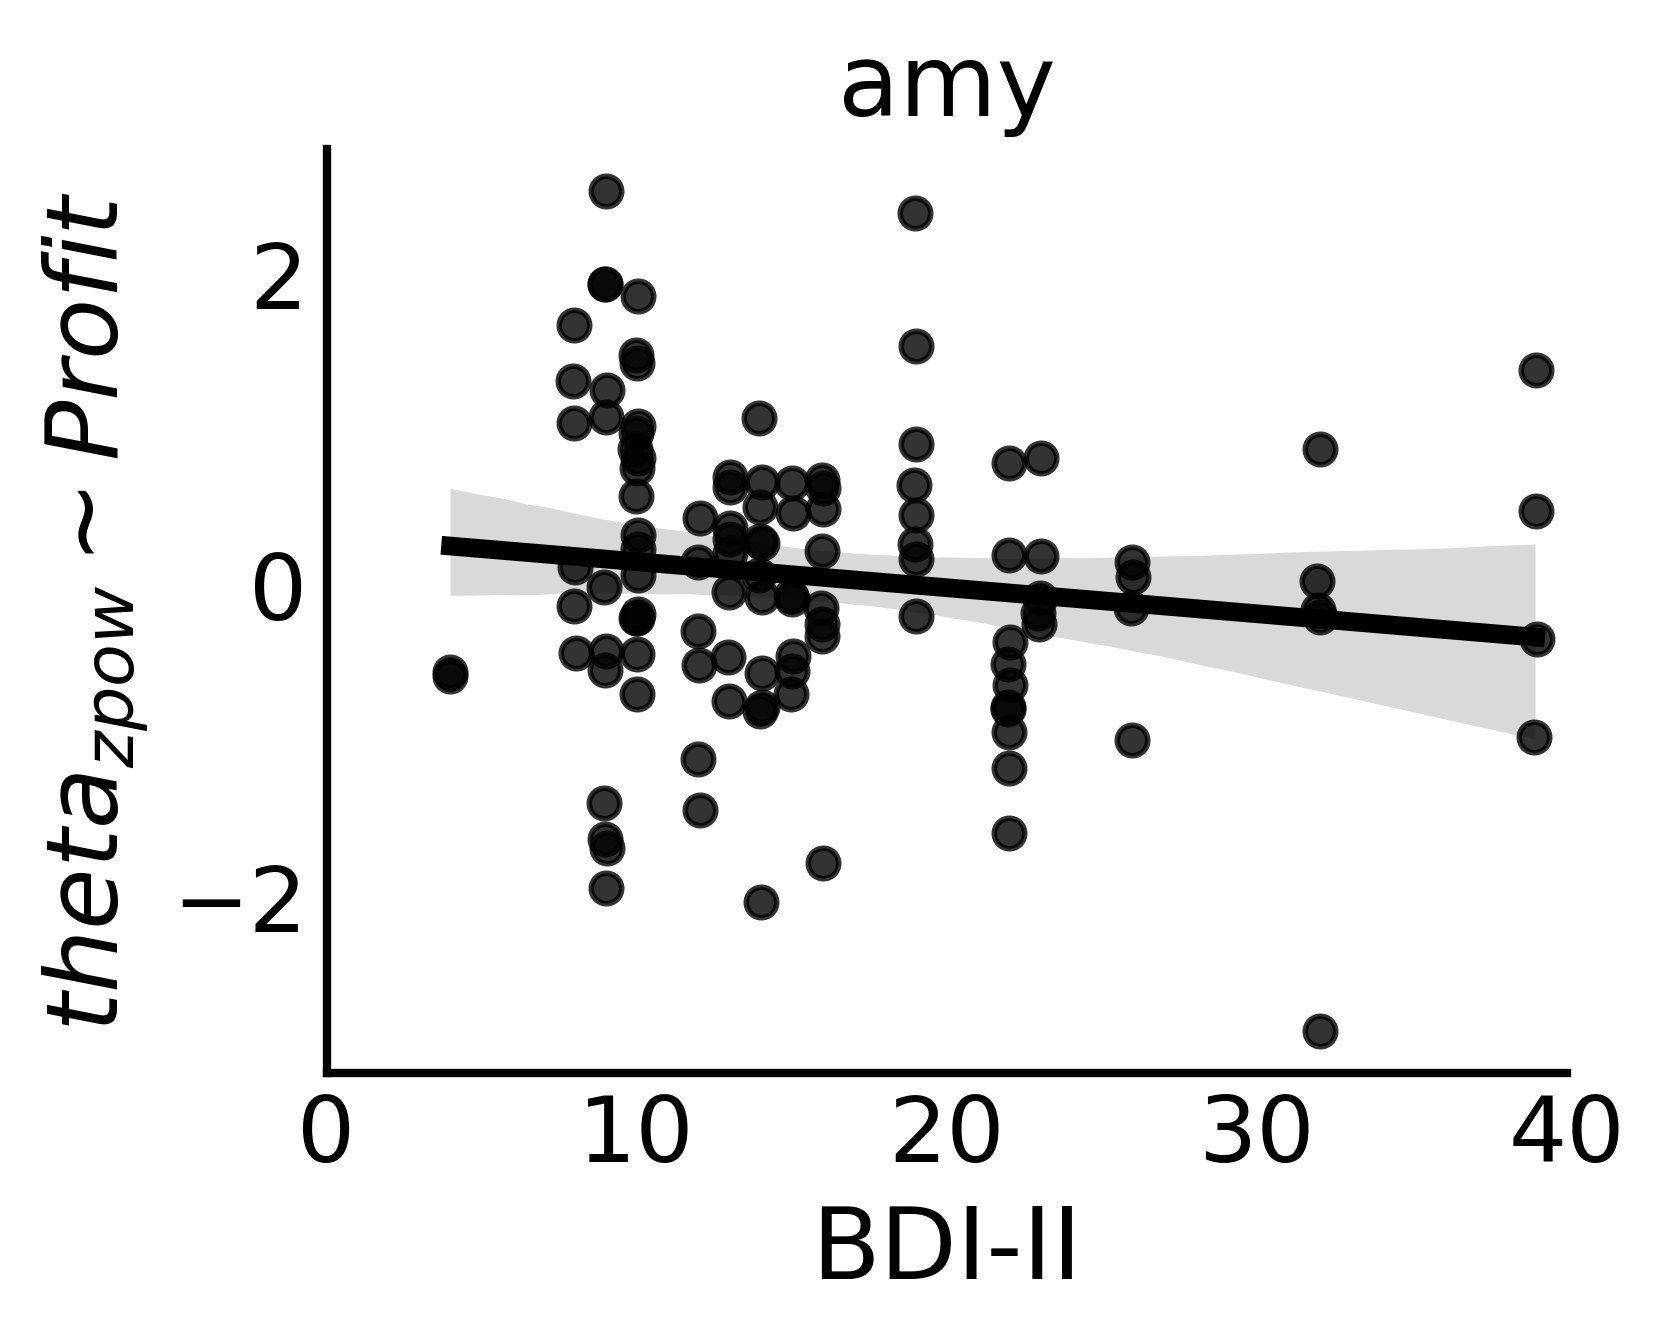

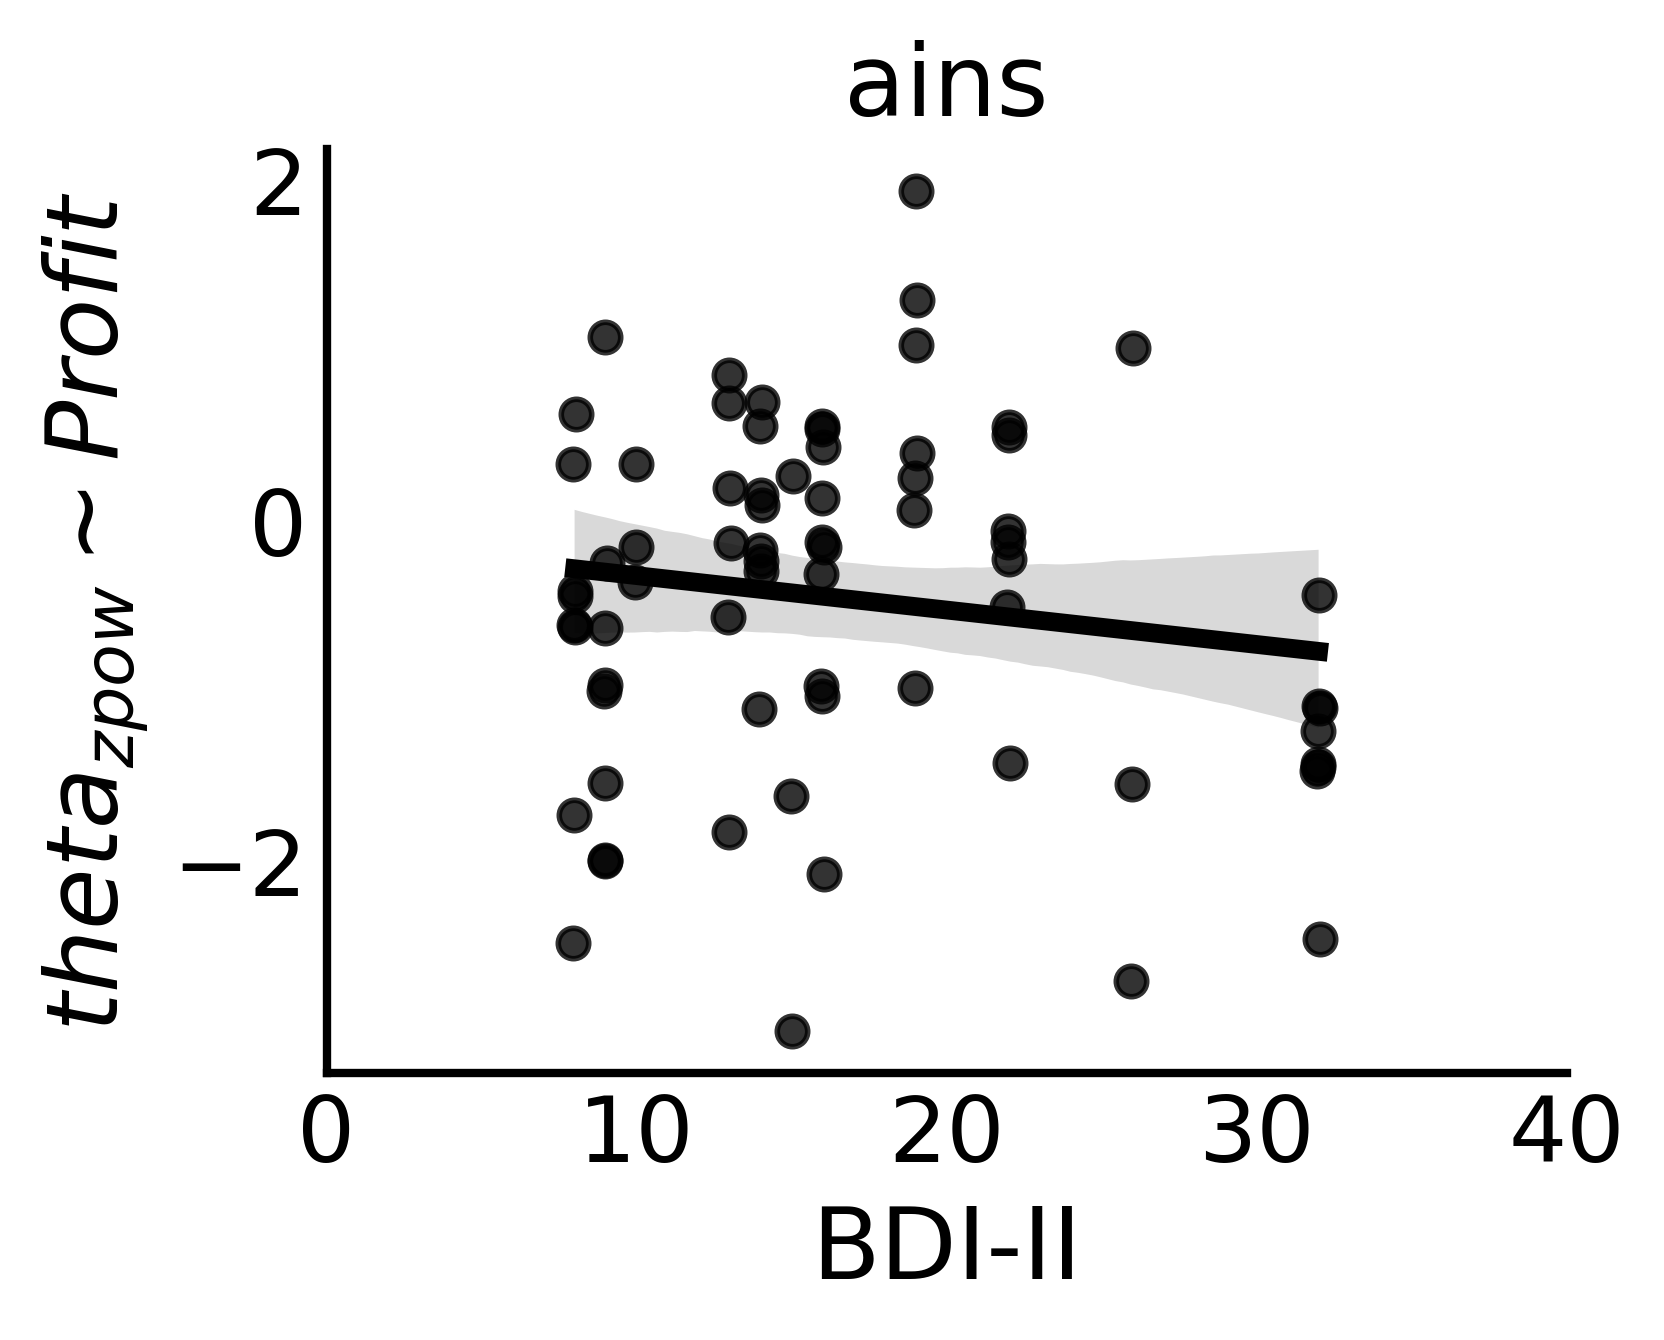

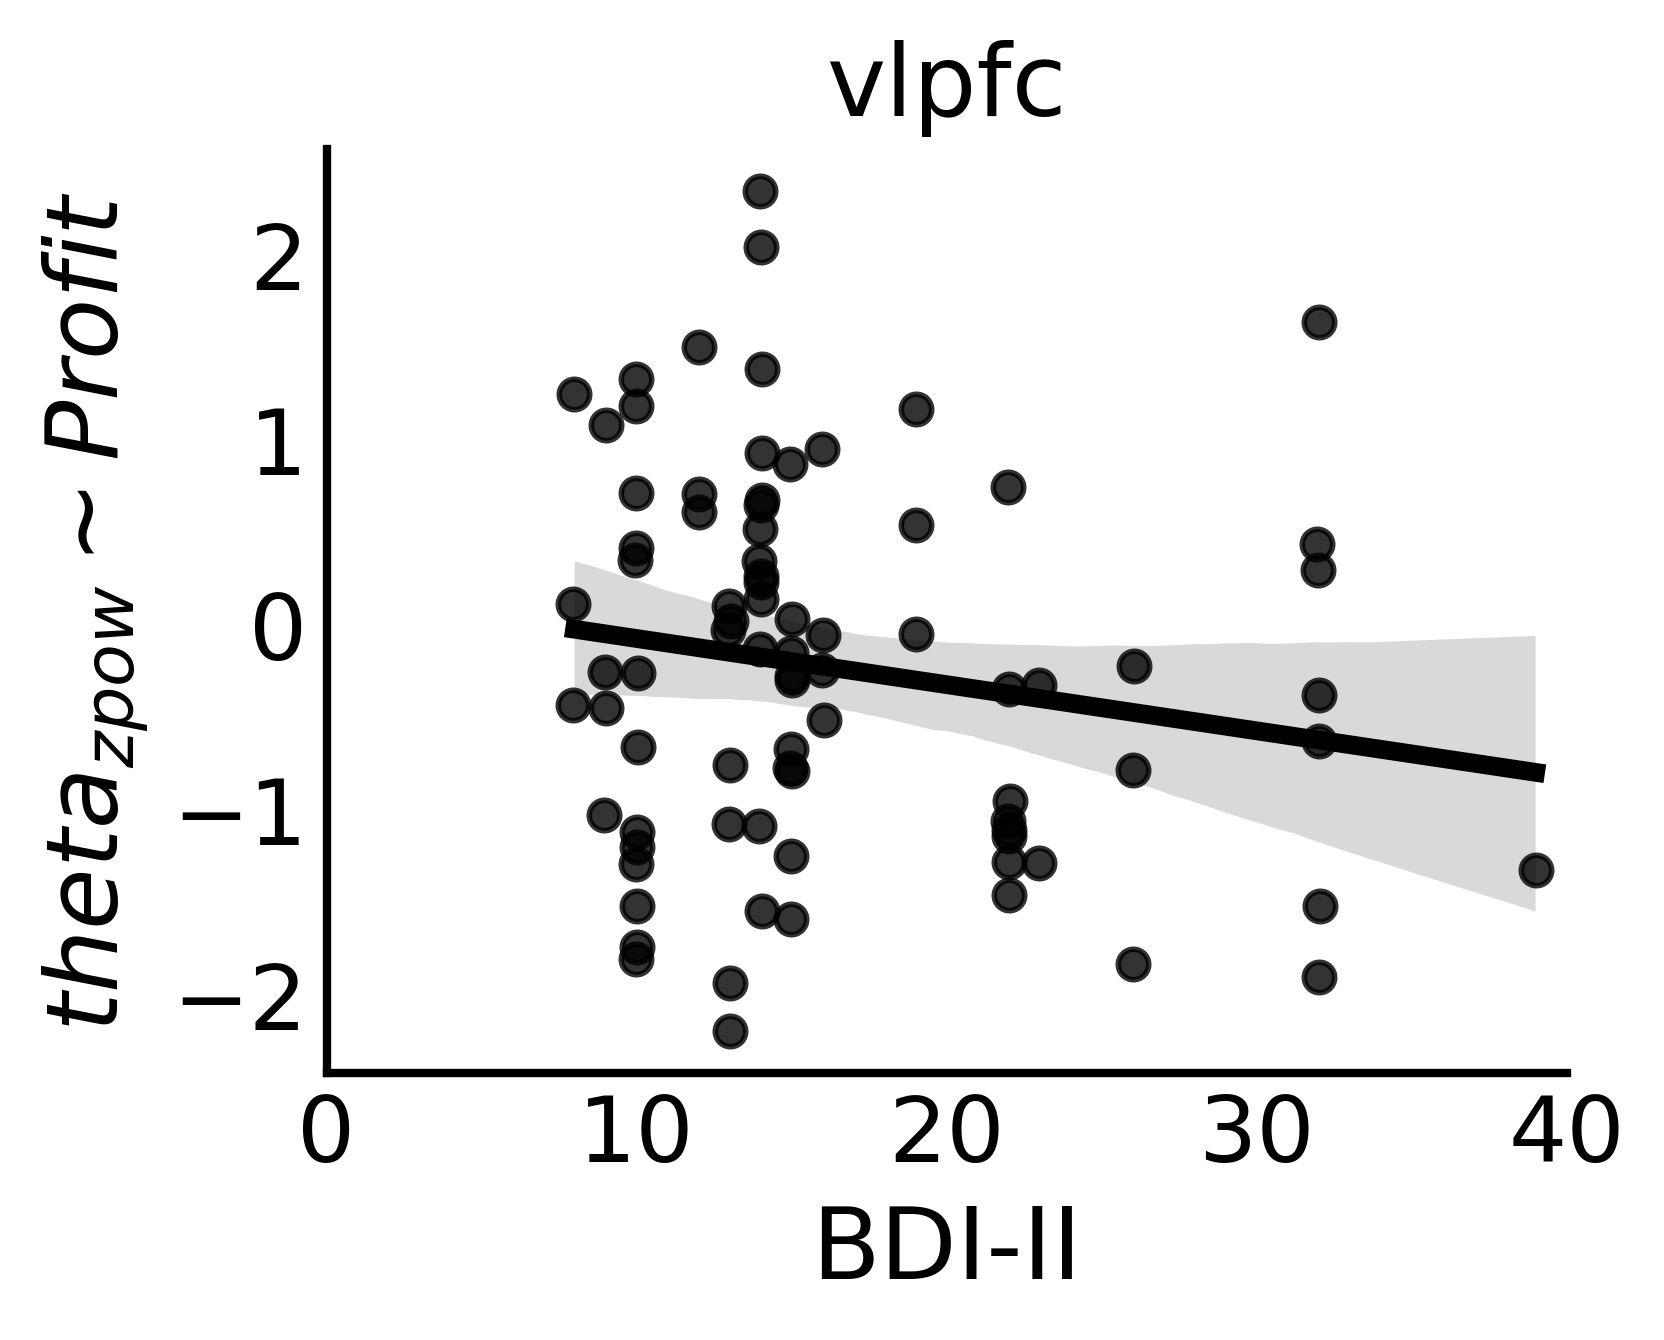

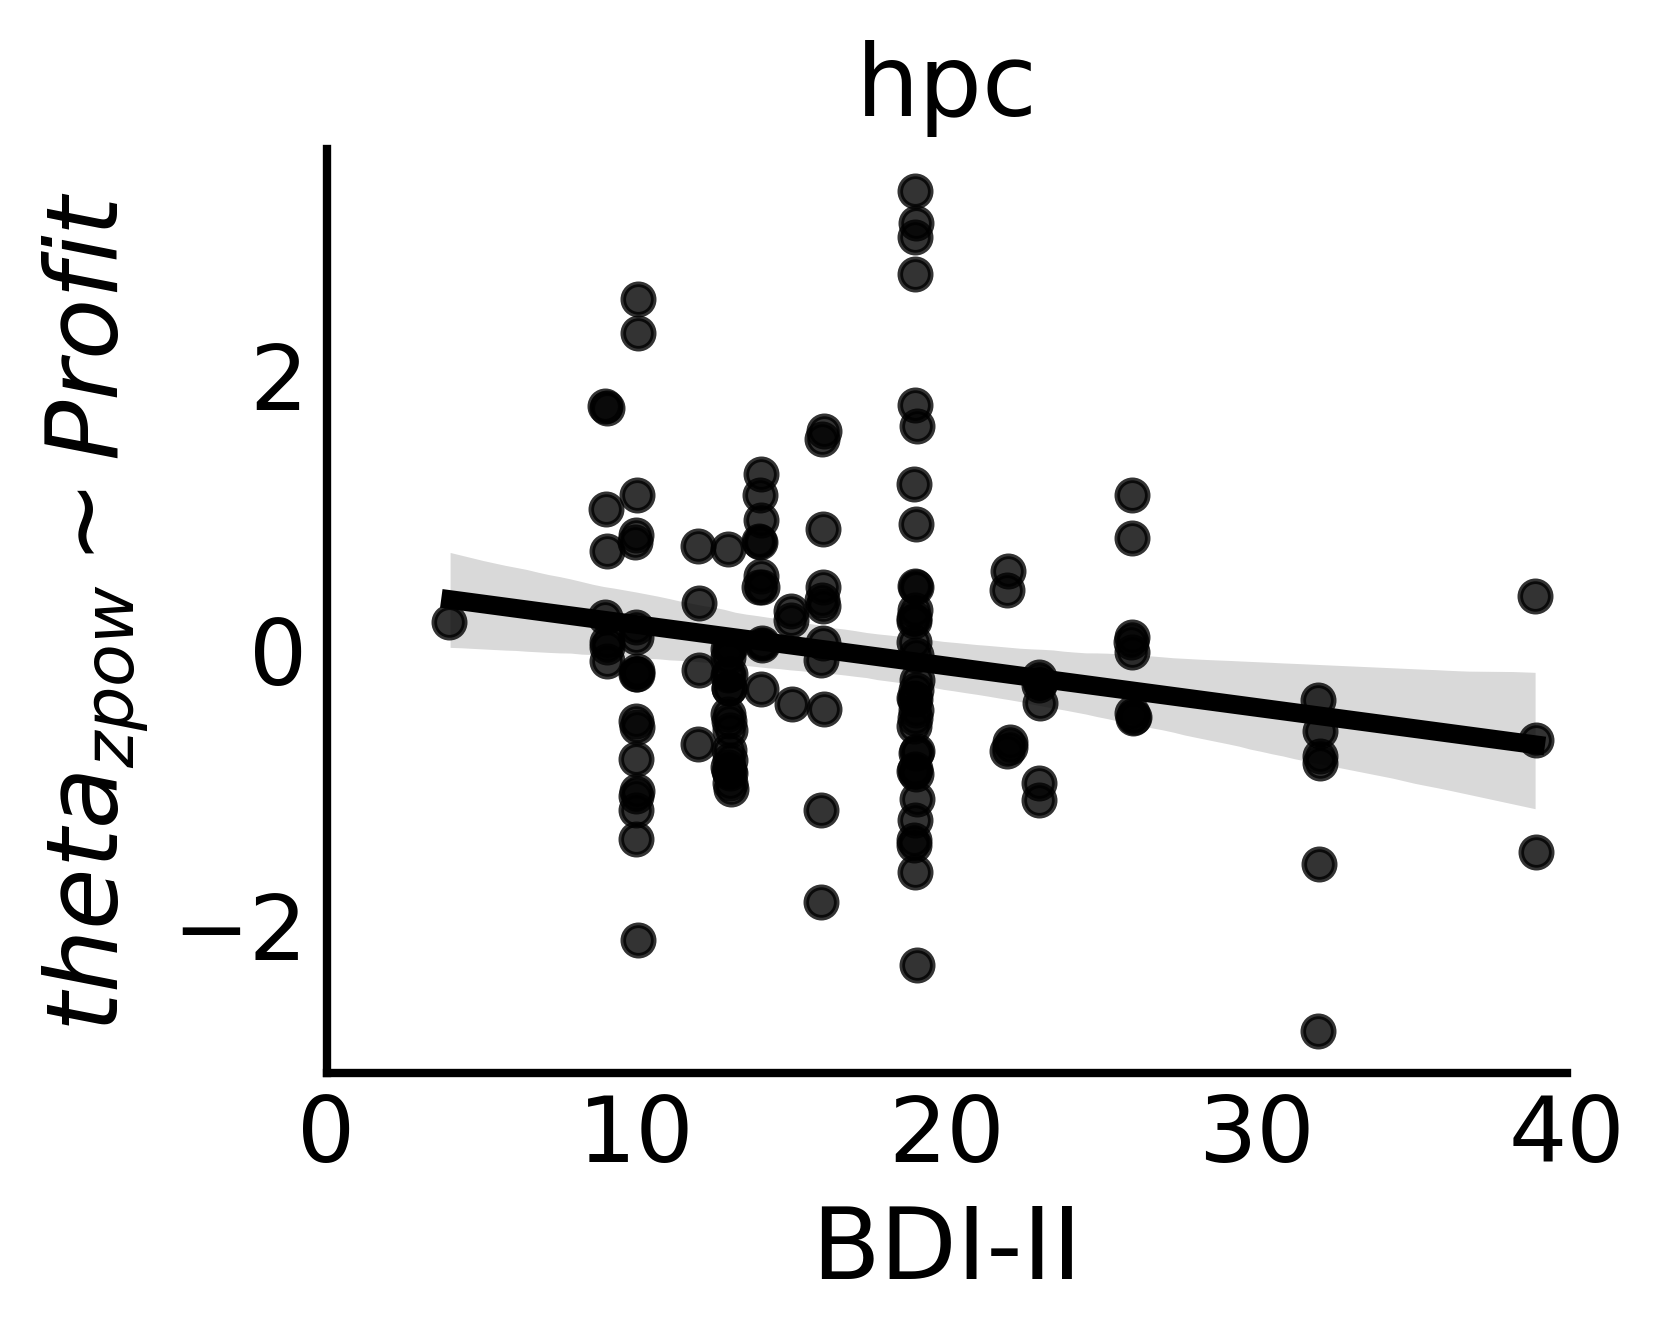

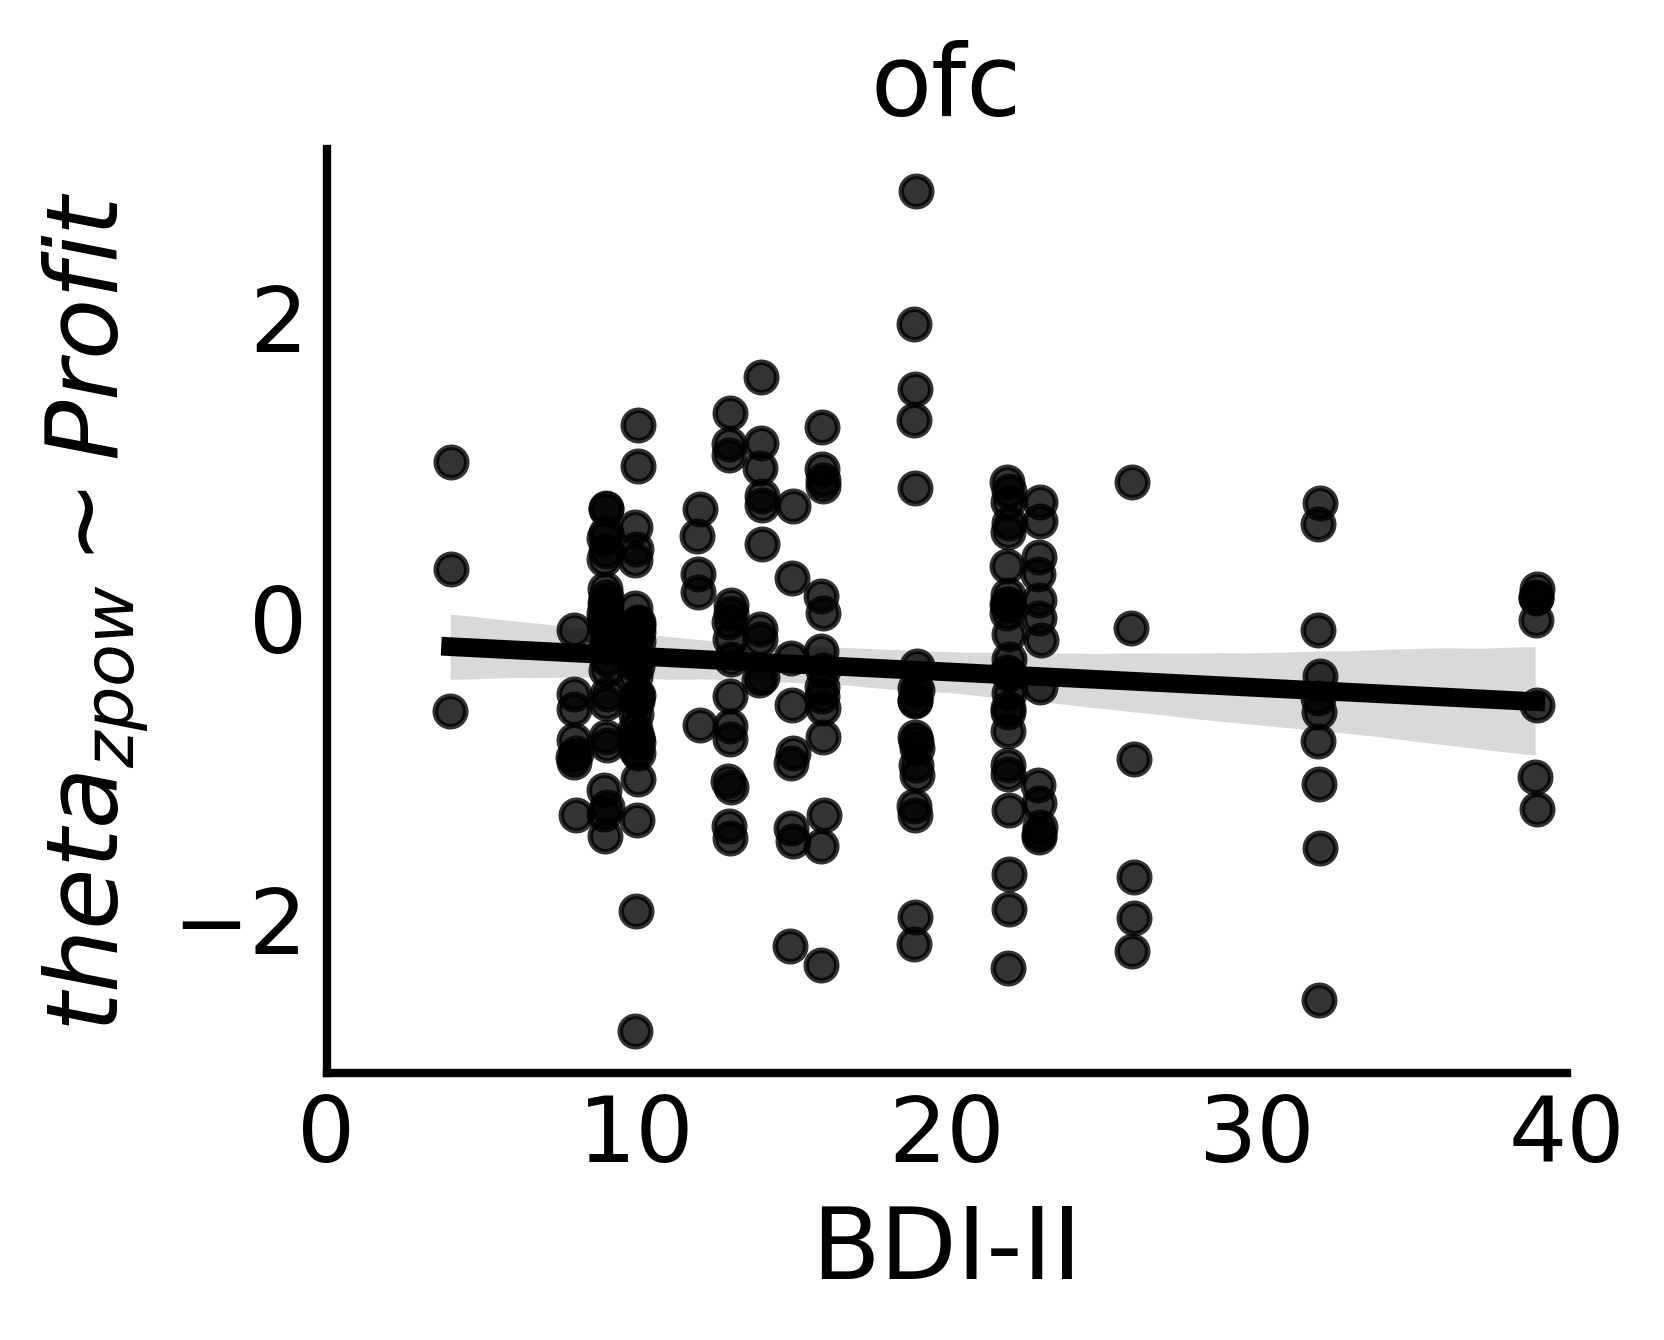

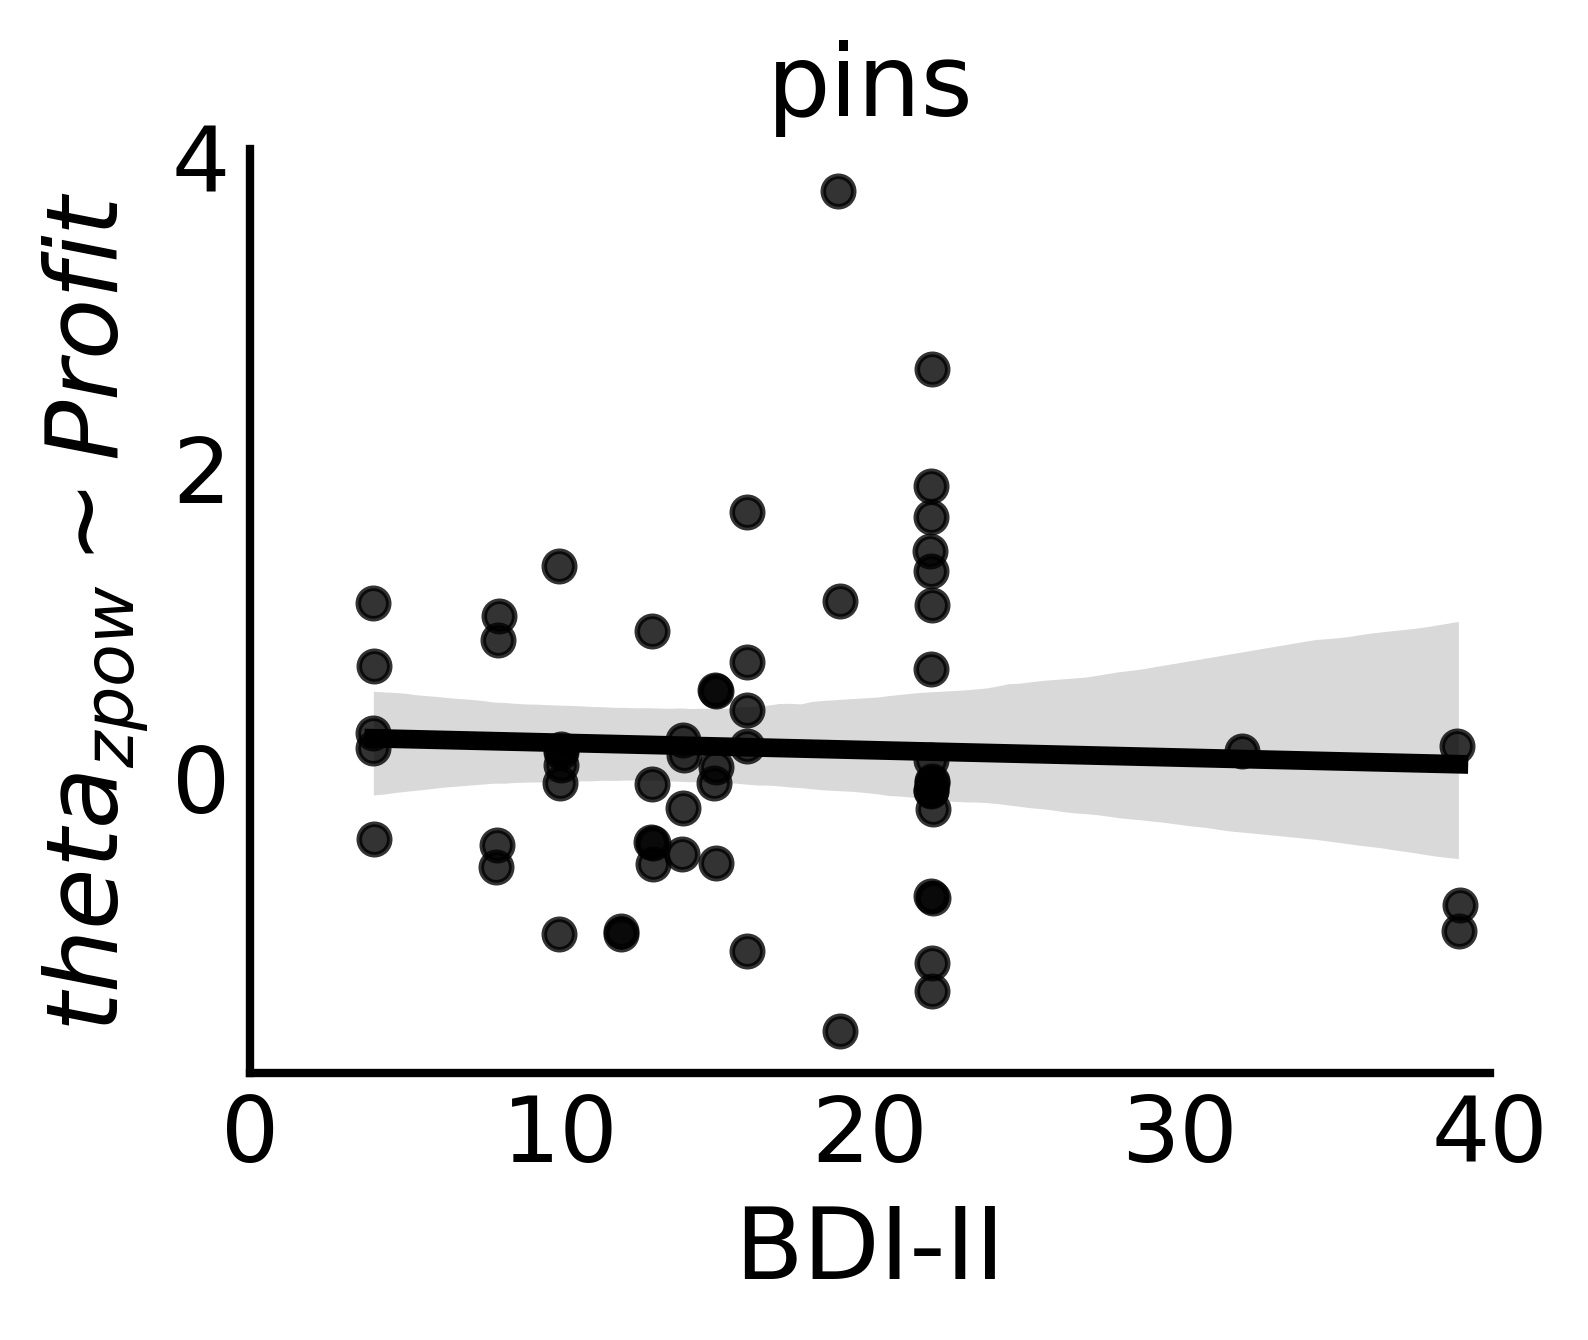

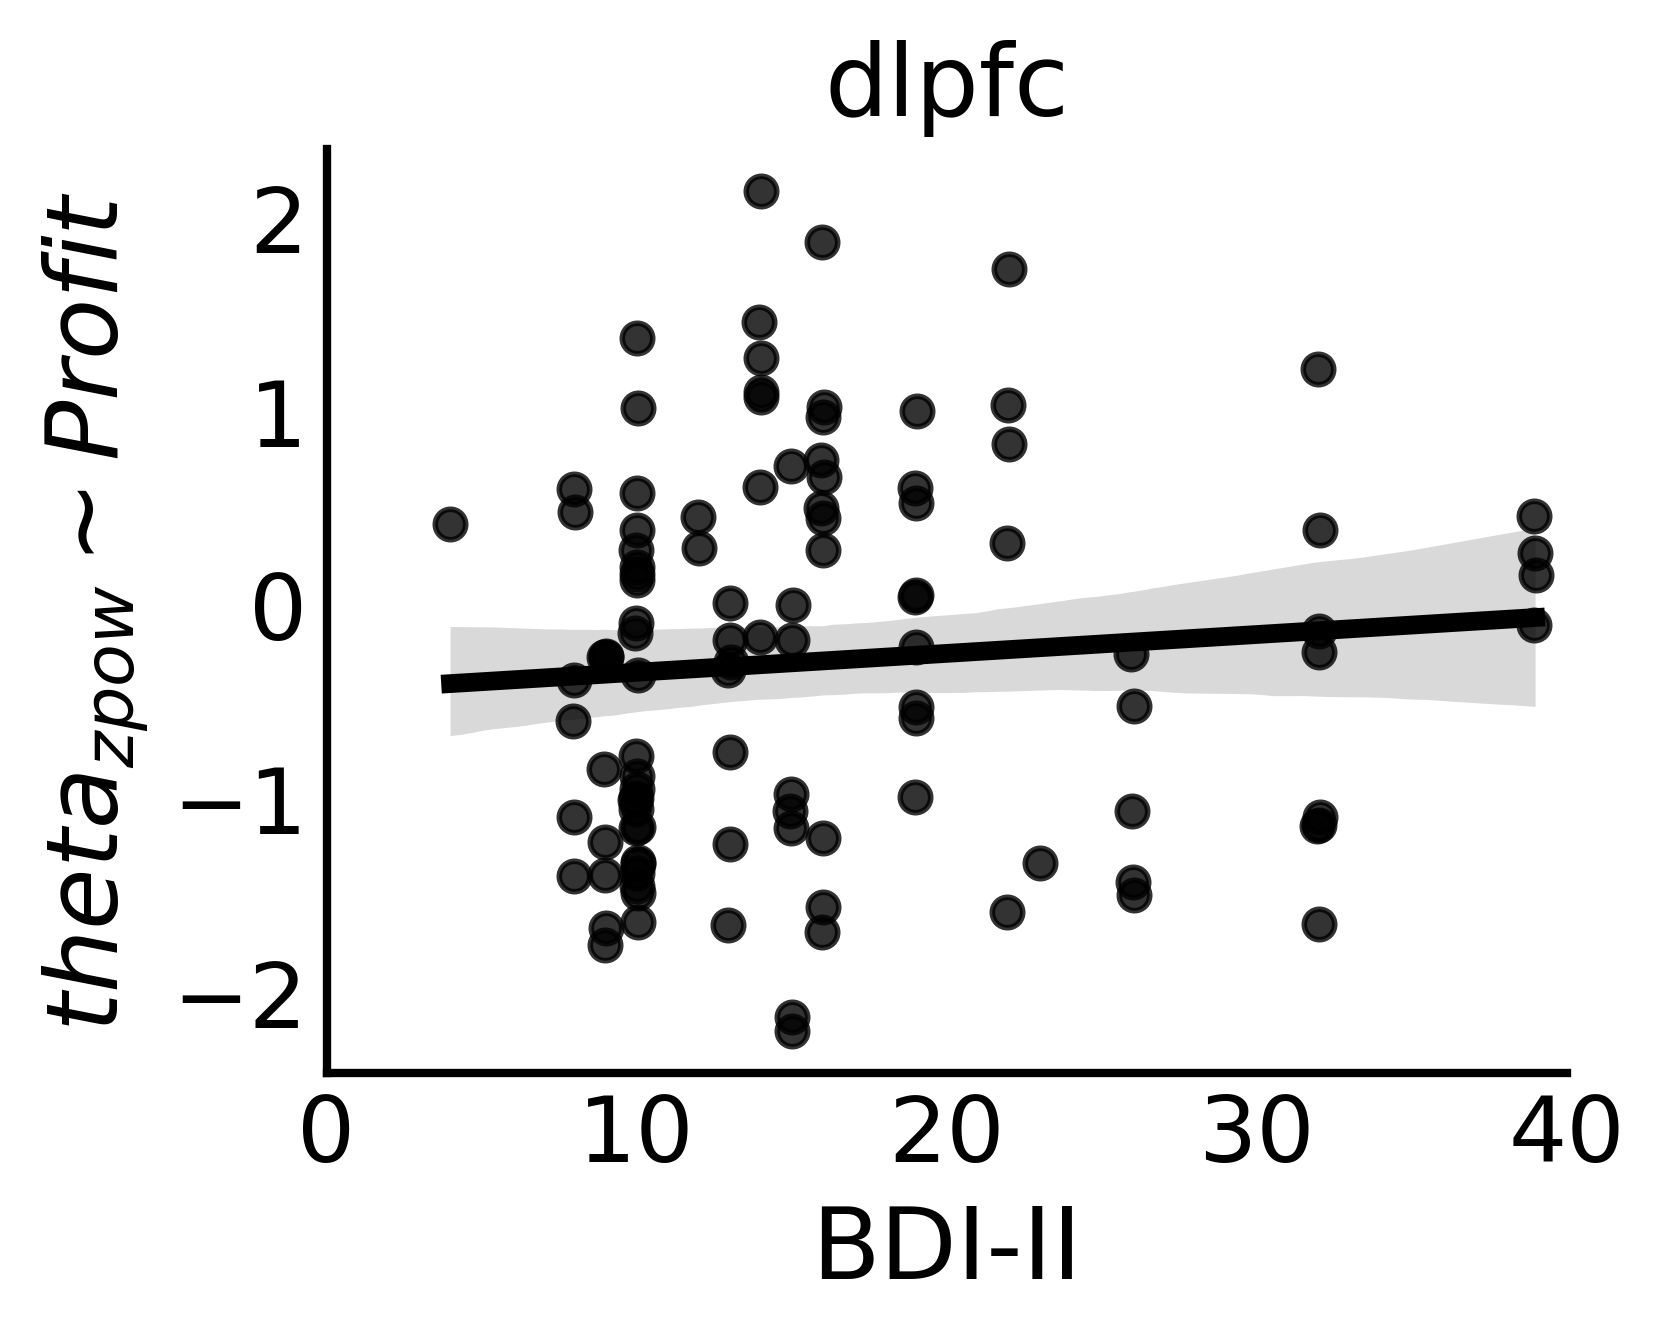

In [56]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_combomodel-bdi_Profit_coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [57]:
### robust regression bdi ~ cpe coefficients
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        10:37:47                                         
No. Iterations:                    21                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.8683      0.448     35.406     